In [712]:
import re
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from datetime import datetime, timedelta
import calendar
from IPython.display import HTML, display
import dataframe_image as dfi
import base64
from io import BytesIO

pd.set_option('display.max_columns', None)  # display all columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)  # display all columns
sns.set_theme(style="darkgrid")

data_quality_checks = True
display_styled_df_as_image = False  # display styled dataframes as images

In [713]:
# make dataframes horizontally scrollable when extracted to HTML (and in github preview)

# define a global flag to track if the patch has been applied, so it only runs once
if not getattr(pd.DataFrame, '_is_scrollable_patch_applied', False):

    original_repr_html = pd.DataFrame._repr_html_  # store the original method to avoid infinite recursion

    def custom_repr_html(self):
        """Wrap the DataFrame HTML representation in a scrollable div"""
        df_html = original_repr_html(self)  # use the original method to get the base HTML string
        scrollable_html = f"<div style='overflow-x: auto; max-width: 100%;'>{df_html}</div>"
        return scrollable_html
    
    pd.DataFrame._repr_html_ = custom_repr_html  # monkey-patch the original method
    pd.DataFrame._is_scrollable_patch_applied = True  # set the flag so this code block doesn't run again

In [714]:
# function to display styled dataframes as images, so colors are visible in github preview

# save original _repr_html_ method of the Styler class
if not getattr(pd.io.formats.style.Styler, '_is_original_styler_saved', False):
    original_styler_repr_html = pd.io.formats.style.Styler._repr_html_
    pd.io.formats.style.Styler._is_original_styler_saved = True  # set flag so we don't run this again

def custom_styler_repr_html(self):
    """Generates an embedded Base64 image of the styled dataframe."""
    # Use BytesIO to simulate a file in memory
    buffer = BytesIO()
    
    # Export the styler object to the buffer
    dfi.export(self, buffer, table_conversion='matplotlib', fontsize=10, dpi=800)

    # Encode the bytes to Base64
    img_bytes = buffer.getvalue()
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')

    # Return an HTML image tag with embedded data
    # constrain width while increasing dpi to get higher resolution
    return f'<img src="data:image/png;base64,{img_base64}" style="width: 100%; max-width: 700px;" />' 

def display_as_image(styler):
    """Displays the styled dataframe as an image."""
    pd.io.formats.style.Styler._repr_html_ = custom_styler_repr_html  # monkey-patch the Styler class
    display(styler)
    pd.io.formats.style.Styler._repr_html_ = original_styler_repr_html

## 1. Prepare Data

In [715]:
# Helper functions
def parse_duration(duration, output='minutes'):
    """
    Convert a duration string of the form '~1h23m45s' (with some components possibly missing) to minutes
    (default), or seconds, or hours depending on the `output` parameter.

    Parameters:
    -----------
    duration : str
        Duration string to parse.
    output : str, optional
        Output format: 'minutes' (default), 'seconds', or 'hours'.

    Returns:
    --------
    int or None
        Total duration in minutes, or None if the format is invalid.
    """
    assert output in ['minutes', 'seconds', 'hours']
    pattern = r'^~?(?:(\d+)h)?(?:(\d+)m)?(?:(\d+)s)?$'  # ~xxhxxmxxs, with some components possibly missing  
    m = re.search(pattern, duration)
    if not m:
        return None
    total_minutes = 60 * int((m.group(1)) or 0) + int((m.group(2)) or 0) + int((m.group(3)) or 0) / 60
    if output == 'seconds':
        total_minutes *= 60
    elif output == 'hours':
        total_minutes /= 60
    return total_minutes

def one_rep_max(row):
    """
    Calculate one rep max (1RM) estimate for a given set.

    Parameters:
    -----------
    row : pd.Series
        Series containing 'weight' and 'reps' columns.

    Returns:
    --------
    float or None
        Estimated 1RM, or None if weight or reps are invalid.
    """
    float_pattern = r"^\d+\.?\d*$"
    if not (row['weight'] and row['reps'] and re.fullmatch(float_pattern, row['weight'])):
        return None

    if not row['reps'].isdigit():
        return float(row['weight'])

    if int(row['reps']) <= 0:
        return None

    return float(row['weight']) * (1 + (int(row['reps'])-1) / 30)

#### 1.1 Generate Set-Level Dataframe
(i.e. each row corresponds to a workout set)

In [716]:
def parse_workout(raw_lines):
    """
    Parse raw data for a single workout into dataframe.

    Parameters
    ----------
    raw_lines : list
        List of raw data lines of a single workout.

    Returns
    -------
    pd.DataFrame
        Dataframe containing parsed workout data.
    """
    line_counter = 0

    # extract date from first line
    line = raw_lines[0]
    whitespace = ' \t\n\r'
    line = line.strip(whitespace + '-').rstrip(':')
    if re.match(r'^\d{4}-\d{2}-\d{2}', line):  # check that it's a date
        date = line
        line_counter += 1
    else:
        raise ValueError(f"{line} isn't a properly formated date")

    # extract time from second line
    line = raw_lines[line_counter]
    line = line.strip(whitespace + '-').replace('~','')
    if re.match(r'^\d{1,2}:\d{2}(a|p)m to \d{1,2}:\d{2}(a|p)m$', line):  # check that it's a time
        input_format = '%Y-%m-%d %I:%M%p'  # e.g. '2025-01-02 4:45pm'
        output_format = '%Y-%m-%d %H:%M:%S'  # e.g. '2025-01-02 16:45:00'
        start_time, end_time = line.split(" to ")
        start_datetime = datetime.strptime(f'{date} {start_time}', input_format)
        start_datetime = start_datetime.strftime(output_format)
        end_datetime = datetime.strptime(f'{date} {end_time}', input_format)
        # fix the case when is passed over midnight
        if re.match(r'^\d{1,2}:\d{2}pm to \d{1,2}:\d{2}am$', line):  # check if time passes over midnight
            end_datetime = end_datetime + pd.Timedelta(days=1)
        end_datetime = end_datetime.strftime(output_format)
        line_counter += 1
    else:
        raise ValueError(f"time isn't correctly formated for {date}")
    
    # extract out exercises and sets/reps
    workout_data = []
    exercise_count = 0
    for i in range(line_counter, len(raw_lines)):
        line = raw_lines[i]

        # skip notes, which are indented with at least two tabs
        if line.startswith('\t\t') or line.startswith('\t- Notes'):
            continue
        
        # skip lines with no square brackets (these are notes or stretches)
        if not re.search(r'\[', line):
            continue

        assert not line.endswith(',\n'), f"line ends with comma in {date}: {line}"

        exercise_count += 1

        # extract out exercise name, and set information
        line = line.strip(whitespace + '-')
        start_str = re.search(r'\S*\[', line)  # string that indicates start of sets/reps
        if line[start_str.end()-2] == ')':  # exercise name ends with a parenthesis
            pos = re.search(r'\S*\([^()]*\)\[', line).start()
        else:
            pos = start_str.start()  # position that splits the exercise name from the sets/reps
        exercise = line[:pos].strip().capitalize()
        sets = line[pos:].strip()

        # check if multiple weights used for different sets, then split those into a list
        if len(re.findall(r'\[', sets)) > 1:
            sets_list = sets.split('],')
            weighted_sets = []
            for j, s in enumerate(sets_list):
                if j == len(sets_list) - 1:  # last set
                    weighted_sets.append(s.strip())
                else:
                    weighted_sets.append(s.strip() + ']')

                assert sets.count('[') == sets.count(']'), f"mismatched brackets in {date}: {line}"
        else:
            weighted_sets = [sets]
        
        # extract out individual sets/reps
        set_count = 1
        for s in weighted_sets:
            in_line_comments = s[s.rfind(']')+1:].strip()
            # remove characters after the last closing bracket
            s = s[:s.rfind(']')+1]
            # get weight and reps
            pos = re.search(r'\[', s).start()  # position that splits the weight from the sets/reps
            weight = s[:pos]
            # if weight is in the form 2x# or #x2, then just count the unilateral weight
            weight = weight.strip()
            if weight.count('x') == 1 and (weight.startswith('2x') or weight.endswith('x2')):
                weight = weight.removeprefix('2x').removesuffix('x2')
                # count total weight for some exercises
                if exercise in ['Bulgarian split squat', 'Dumbbell rdl', "Farmer's walk",
                                'Seated dumbbell shoulder press', 'Shrugs']:
                    weight = str(2 * float(weight))
            # map some non-numeric weights to numeric
            if weight in ['(Yellow 1)', '(Red 2)', '(Green 4)', '(Blue 6)', '(Black 8)']:
                weight = weight[-2]
            # if weight is in brackets, then remove those brackets
            if weight and weight[0] == '(' and weight[-1] == ')':
                weight = weight[1:-1]
            # get list of reps
            reps_list = s[pos:].lstrip('[').rstrip(']').split(',')
            for reps in reps_list:
                # extract side for unilateral exercises
                reps = reps.strip()
                if reps[-1] == 'f':  # went to failure
                    reps = reps[:-1]
                if reps[0] in ('R','L'):
                    side = reps[0]
                    reps = reps[1:]
                else:
                    side = None
                set_info = {
                    'date': date,
                    'exercise_count': exercise_count,
                    'set_count': set_count,
                    'exercise': exercise,
                    'weight': weight,
                    'reps': reps,
                    'side': side,
                    'comments': in_line_comments,
                    'start_datetime': start_datetime,
                    'end_datetime': end_datetime,
                }
                workout_data.append(set_info)

                set_count += 1

    df = pd.DataFrame.from_records(workout_data)
    return df

def parse_workout_data(path, workout_type='lifting'):
    """
    Parse raw workout data into dataframe.

    Parameters
    ----------
    path : str
        Path to raw data file.
    workout_type : str
        Type of exercise. Either 'lifting' or 'cardio'.

    Returns
    -------
    pd.DataFrame
        Dataframe containing parsed workout data.
    """

    assert workout_type in ['lifting', 'cardio'], 'workout_type must be either "lifting" or "cardio"'

    # extract raw data into workouts
    workouts = []
    with open(path, 'r') as file:
        # get first line of file
        line = file.readline()
        assert re.match(r'(\t|-|\s)*\d{4}-\d{2}-\d{2}', line), 'first line must be in yyyy-mm-dd format'
        raw_lines = [line]
        # read the rest of the file line-by-line
        for line in file:
            # check if line is a not date, since being a date would indicate the start of a new workout
            if not re.match(r'(\t|-|\s)*\d{4}-\d{2}-\d{2}', line):
                raw_lines.append(line)
            else:  # new workout
                workouts.append(raw_lines)
                raw_lines = [line]
        # append last workout
        workouts.append(raw_lines)
    # put all workout data into a single dataframe
    dfs = []
    for i in range(0, len(workouts)):
        df = parse_workout(workouts[i])
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    
    # format dataframe and calculate 1 rep max (1RM) estimates
    df.loc[:, 'date'] = pd.to_datetime(df['date'])

    # if reps is a duration (e.g. ~1h23m45s, or 1m), then convert to minutes
    df['rep_duration_minutes'] = df.apply(lambda row: parse_duration(row['reps']), axis=1)
    df['rep_duration_seconds'] = df['rep_duration_minutes'] * 60
    # df['rep_duration_hours'] = df['rep_duration_minutes'] / 60

    # add workout type column
    df['workout_type'] = workout_type

    if workout_type == 'lifting':
        # add 1 rep max (1RM) estimates
        float_pattern = r"^\d+\.?\d*$"
        df['1RM'] = df.apply(one_rep_max, axis=1)
    elif workout_type == 'cardio':
        ...
    
    return df

In [717]:
# raw data paths
lifting_path = '/Users/stevenhobbs/Documents/Programming/exercise-data-analysis/raw_data/lifting.txt'
prehab_path = '/Users/stevenhobbs/Documents/Programming/exercise-data-analysis/raw_data/prehab.txt'
cardio_path = '/Users/stevenhobbs/Documents/Programming/exercise-data-analysis/raw_data/cardio.txt'

# parse raw workout data into a dataframe
lifting_df = parse_workout_data(lifting_path)
prehab_df = parse_workout_data(prehab_path)
cardio_df = parse_workout_data(cardio_path, 'cardio')
set_df = pd.concat([lifting_df, prehab_df, cardio_df], ignore_index=True)

In [718]:
# Cardio exercise frequencies
mask = set_df['workout_type'] == 'cardio'
cardio_exercises = pd.DataFrame(set_df.loc[mask, 'exercise'].value_counts()).reset_index()

# DATA QUALITY CHECK: Ensure that the same cardio exercise isn't written in multiple different ways
if data_quality_checks:
    display(cardio_exercises)

exercise  count
0                 Treadmill    106
1                    Stairs     57
2              Outdoor bike     28
3               Outdoor run     23
4                       Ddr      6
5            Rowing machine      4
6                  Skipping      2
7  Stand up paddle boarding      1
8             Rock climbing      1
9                Elliptical      1

In [719]:
# add duration columns for the most common cardio exercises
n_exercises = 4  # number of cardio exercises to track
mask = set_df['workout_type'] == 'cardio'
most_common_cardio_exercises = list(set_df.loc[mask, 'exercise'].value_counts().index[:n_exercises])
for exercise in most_common_cardio_exercises:
    set_df[f'{exercise}_hours'] = set_df['rep_duration_minutes'] * \
        ((set_df['workout_type'] == 'cardio') & (set_df['exercise'] == exercise)) / 60
cardio_duration_columns = [f'{exercise}_hours' for exercise in most_common_cardio_exercises]
set_df['other_cardio_exercise_hours'] = (set_df['workout_type'] == 'cardio') * \
        (set_df['rep_duration_minutes'] / 60 - set_df[cardio_duration_columns].sum(axis=1))
cardio_duration_columns.append('other_cardio_exercise_hours')

In [720]:
# specify how much Zone 2 duration to allocate for each cardio intensity (in 'weight' column)
zone2_values = {
    'Zone 1-2': 0.5,
    'Zone 2': 1,
    'Zone 2-3': 0.5
}

zone3_values = {
    'Zone 2-3': 0.5,
    'Zone 3': 1,
    'Zone 3-4': 0.5,
}

zone4_values = {
    'Zone 3-4': 0.5,
    'Zone 4': 1,
    'Zone 4-5': 0.5,
}

# specify which cardio intensities count at a Zone 5 workout
zone5_values = [
    'Zone 4-5',
    'Zone 5',
    'Zone 5 intervals',
]

# TODO: add interval tracking (mainly for Zone 5)
# other zone values not used
used_zone_values = list(zone2_values) + list(zone3_values) + list(zone4_values) + zone5_values
used_zone_values = set(used_zone_values)
mask = (set_df['workout_type'] == 'cardio') & (~set_df['weight'].isin(used_zone_values))
other_zone_values = set_df.loc[mask, 'weight'].value_counts()
other_zone_values.index.name = 'Intensity'
other_zone_values = pd.DataFrame(other_zone_values).reset_index()
# set_df.loc[set_df['workout_type'] == 'cardio', 'weight'].value_counts()

# DATA QUALITY CHECK: Ensure other workout intensities shouldn't be classified in Zone 2, 3, 4, or 5
if data_quality_checks:
    display(other_zone_values)

Intensity  count
0            Zone 1     10
1  Zone 4 intervals      3
2  Zone 3 intervals      1

In [721]:
# add cardio intensity zones and durations
cardio_mask = set_df['workout_type'] == 'cardio'
set_df.loc[cardio_mask, 'zone_2'] = set_df.loc[cardio_mask, 'weight'].isin(zone2_values)
set_df.loc[cardio_mask, 'zone_3'] = set_df.loc[cardio_mask, 'weight'].isin(zone3_values)
set_df.loc[cardio_mask, 'zone_4'] = set_df.loc[cardio_mask, 'weight'].isin(zone4_values)
set_df.loc[cardio_mask, 'zone_5'] = set_df.loc[cardio_mask, 'weight'].isin(zone5_values)
set_df.loc[cardio_mask, 'zone_2_hours'] = set_df.loc[cardio_mask, 'weight'].map(zone2_values) * \
                                          set_df.loc[cardio_mask, 'rep_duration_minutes'] / 60
set_df.loc[cardio_mask, 'zone_3_hours'] = set_df.loc[cardio_mask, 'weight'].map(zone3_values) * \
                                            set_df.loc[cardio_mask, 'rep_duration_minutes'] / 60
set_df.loc[cardio_mask, 'zone_4_hours'] = set_df.loc[cardio_mask, 'weight'].map(zone4_values) * \
                                          set_df.loc[cardio_mask, 'rep_duration_minutes'] / 60
set_df.loc[cardio_mask, 'zone_2_hours'] = set_df.loc[cardio_mask, 'zone_2_hours'].fillna(0)
set_df.loc[cardio_mask, 'zone_3_hours'] = set_df.loc[cardio_mask, 'zone_3_hours'].fillna(0)
set_df.loc[cardio_mask, 'zone_4_hours'] = set_df.loc[cardio_mask, 'zone_4_hours'].fillna(0)
# TODO?: Could be more precise by checking for partial morning sessions
morning_mask = (pd.to_datetime(set_df.loc[cardio_mask, 'start_datetime']).dt.hour > 4) & \
               (pd.to_datetime(set_df.loc[cardio_mask, 'start_datetime']).dt.hour < 12)
morning_cardio_mask = morning_mask & cardio_mask
set_df.loc[morning_cardio_mask, 'zone_2_morning_hours'] = set_df.loc[morning_cardio_mask, 'zone_2_hours']

# rest day after workout (i.e. no exercise the next day except Zone 1)
set_df['date'] = pd.to_datetime(set_df['date'], format='%Y-%m-%d', errors='coerce')  # to avoid warning
set_df.set_index('date', inplace=True)  # temporarily set index for faster lookups
def next_day_rest_day(row):
    tomorrow = row.name + timedelta(days=1)
    if tomorrow not in set_df.index:  # true if no exercise the next day
        return True
    ser = set_df.loc[tomorrow, 'weight']
    if type(ser) == str:  # true if the only exercise the next day is Zone 1
        return ser == 'Zone 1'
    return (ser == 'Zone 1').all()
set_df['next_day_rest_day'] = set_df.apply(next_day_rest_day, axis=1)
set_df.reset_index(inplace=True)
set_df['rest_day_after_zone_5'] = set_df['next_day_rest_day'] & set_df['zone_5']

cardio_zone_columns = ['zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_2_hours', 'zone_3_hours', 'zone_4_hours', 'zone_2_morning_hours']

##### Assign Muscle Groups to Exercises

In [722]:
# Assign muscle groups to each exercise, and identify common exercises that aren't specified in the dictionary

muscle_groups_dict = {
    # Full body
    "Farmer's walk": ['grip', 'forearms', 'traps', 'core'],
    "One-arm farmer's walk": ['grip', 'forearms', 'traps', 'core'],
    'Deadlift': ['glutes', 'hamstrings', 'back', 'core', 'traps', 'grip', 'forearms'],  # forearms are mainly used for double overhand deadlifts

    # Chest
    'Bench press (smith machine)': ['chest', 'shoulders', 'triceps'],
    'Incline bench press (smith machine)': ['chest', 'shoulders', 'triceps'],
    'Decline bench press (smith machine)': ['chest', 'shoulders', 'triceps'],
    'Dumbbell bench press': ['chest', 'shoulders', 'triceps'],
    'Dumbbell incline (30) bench press': ['chest', 'shoulders', 'triceps'],
    'Dumbbell incline (20) bench press': ['chest', 'shoulders', 'triceps'],
    'Incline (45) bench press (smith machine)': ['chest', 'shoulders', 'triceps'],
    'Incline standing cable fly': 'chest',
    'Pec deck': 'chest',
    'Dips': ['chest', 'triceps', 'shoulders'],
    'Dips (negatives)': ['chest', 'triceps', 'shoulders'],
    'Push-ups': ['chest', 'triceps', 'shoulders'],
    'Push-ups (wide)': ['chest', 'triceps', 'shoulders'],
    'Push-ups (knee)': ['chest', 'triceps', 'shoulders'],
    'Push-ups (incline)': ['chest', 'triceps', 'shoulders'],
    'Push-ups (incline knee)': ['chest', 'triceps', 'shoulders'],
    'Dumbbell fly': 'chest',
    'Dumbbell fly (incline 2)': 'chest',
    'Dumbbell fly (incline 3)': 'chest',
    
    # Back (TODO? distinguish between lats, traps, rhomboids, erector spinae, etc.)
    'Lat pulldown': ['back', 'biceps', 'grip'],
    'Supinated lat pulldown': ['back', 'biceps'],
    'Single-arm lat pulldown': ['back', 'biceps'],
    'Mid row (horizontal grip)': ['back', 'biceps'],
    'Mid row (vertical grip)': ['back', 'biceps'],
    'Bent over row (smith machine)': ['back', 'biceps'],
    'One-arm dumbbell row': ['back', 'biceps'],
    'Dumbbell incline (3) row': ['back', 'biceps'],
    'Pull-ups': ['back', 'biceps', 'grip'],
    'Wide grip pull-up': ['back', 'biceps', 'grip'],
    'Neutral grip pull-up': ['back', 'biceps', 'grip'],
    'Rock climb pull-up': ['back', 'biceps', 'grip'],
    'Chin ups': ['back', 'biceps'],
    'Pull-up negatives': ['back', 'biceps'],
    'T raises (incline 30)': 'back',
    'A raises (incline 30)': 'back',
    'Y raises (incline 30)': ['back', 'shoulders'],
    'Seated cable row': ['back', 'biceps'],

    # Quadriceps
    'Bulgarian split squat': ['quadriceps', 'glutes', 'core'],
    'Sumo squat': ['quadriceps', 'glutes'],
    'Squats': ['quadriceps', 'glutes', 'core'],
    'Squats (smith machine)': ['quadriceps', 'glutes', 'core'],
    'Front squat (smith machine)': ['quadriceps', 'glutes'],
    'Vmo squats': 'quadriceps',
    'Hackenschmidt squat': ['quadriceps', 'glutes'],
    'One legged stand up': ['quadriceps', 'glutes'],
    'Leg extension': 'quadriceps',
    'Isometric leg extension': 'quadriceps',
    'Wall sit': ['quadriceps', 'glutes'],
    'Reverse step ups (2.5")': ['quadriceps', 'glutes'],
    'Reverse step ups (4.25")': ['quadriceps', 'glutes'],
    'Reverse step ups (5.5")': ['quadriceps', 'glutes'],
    'Reverse step ups (4")': ['quadriceps', 'glutes'],
    'Reverse step ups (6")': ['quadriceps', 'glutes'],
    'Dumbbell lateral step downs (2.5")': ['quadriceps', 'glutes'],
    'Dumbbell lateral step downs (4.25")': ['quadriceps', 'glutes'],
    'Dumbbell lateral step downs (5.5")': ['quadriceps', 'glutes'],
    'Dumbbell lateral step downs (4")': ['quadriceps', 'glutes'],
    'Dumbbell lateral step downs (6")': ['quadriceps', 'glutes'],
    'Peterson step ups (2.5")': 'quadriceps',
    'Peterson step ups (4.25")': 'quadriceps',
    'Peterson step ups (5.5")': 'quadriceps',
    'Peterson step ups (4")': 'quadriceps',
    'Peterson step ups (6")': 'quadriceps',
    
    # Hamstrings
    'Seated leg curl': 'hamstrings',
    'Dumbbell rdl': ['hamstrings', 'glutes'],
    'Single-leg rdls': ['hamstrings', 'glutes'],
    'Hamstring curls with sliders': ['hamstrings', 'glutes', 'core'],

    # Glutes
    'Hip thrusts': ['glutes', 'hamstrings'],
    'Hip thrusts (single leg)': ['glutes', 'hamstrings'],
    'Banded clamshell': 'glutes',
    'Banded side steps': 'glutes',
    'Lying ankle-weighted side leg raises': 'glutes',
    'Ankle weighted kickbacks (angled 30 degrees out)': 'glutes',
    'Single-leg kickbacks': 'glutes',
    'Abductor raises': 'glutes',

    # Hip flexors
    'Alternating ankle-weighted knee raises': 'hip flexors',
    'L-sit seated leg raise': 'hip flexors',

    # Adductors
    'Adductor raises': 'adductors',

    # Shoulders
    # TODO: might distinguish between anterior (front), lateral (side), and posterior (rear) deltoids
    'Lateral dumbbell raise': 'shoulders',
    'Lateral dumbbell raise (super rom)': 'shoulders',
    'Laying lateral dumbbell raise': 'shoulders',
    'Cable lateral raise': 'shoulders',
    'Reverse pec deck': 'shoulders',
    'One arm reverse pec deck': 'shoulders',
    'Face pulls': ['shoulders', 'back'],
    'Alternating front dumbbell raise': 'shoulders',
    'Rear deltoid dumbbell raise': 'shoulders',
    'Seated (incline 6) front dumbbell raises': 'shoulders',
    'Seated bent forward rear-delt row': 'shoulders',
    'Bent forward rear-delt row': 'shoulders',
    'Dumbbell shoulder press (seated)': ['shoulders', 'triceps'],
    'Dumbbell shoulder press (standing)': ['shoulders', 'triceps'],
    'Arnold press (seated)': ['shoulders', 'triceps'],
    'Arnold press (standing)': ['shoulders', 'triceps'],
    'Single-arm overhead carry': ['shoulders', 'core'],
    'W raises (incline 30)': ['shoulders', 'rotator cuffs'],

    # Biceps
    'One-arm preacher curl': 'biceps',
    'One-arm preacher hammer curl': ['biceps', 'forearms'],
    'Alternating bicep curl': 'biceps',
    'Alternating hammer curl': ['biceps', 'forearms'],
    'Seated alternating bicep curl': 'biceps',
    'Seated bicep curl': 'biceps',
    'Seated bicep curl (incline 6)': 'biceps',
    'Ez-bar curl (standing)': 'biceps',
    'Ez-bar preacher curl': 'biceps',
    'Face away bayesian cable curl': 'biceps',
    'Bicep curl': 'biceps',
    'Hammer curl': ['biceps', 'forearms'],
    'Concentration curl': 'biceps',

    # Triceps
    'One-arm dumbbell tricep extension (incline 20)': 'triceps',
    'Tricep push down': 'triceps',
    'Overhead cable bar tricep extension': 'triceps',
    'Bench dip': 'triceps',
    'Push-ups (diamond)': ['triceps', 'chest', 'shoulders'],
    'Skull crusher (incline 3)': 'triceps',
    'Close-grip bench press (smith machine)': ['triceps', 'chest'],
    'Tricep cable kickbacks': 'triceps',

    # Calves
    'Single-leg calf raise': 'calves',
    'Calf raise': 'calves',
    'Bent leg calf raises (one-legged)': 'calves',
    'Fhl calf raises': 'calves',
    'Fhl calf raises (one-legged)': 'calves',
    'Slant calf raises (one-legged)': 'calves',
    
    # Grip
    'Elastic expand': 'grip',
    'Elastic expand hold': 'grip',
    'Elastic expand (3 second holds)': 'grip',
    'Elastic expand (hold and rotate)': 'grip',
    'Elastic expand (hold up and down)': 'grip',
    'Crush': 'grip',
    'Crush (coc)': 'grip',
    'Crush (black) (1 second hold + slow eccentric)': 'grip',
    'Isometric crush': 'grip',
    'Isometric crush (individual fingers)': 'grip',
    'Thumb pinch': 'grip',
    'Front thumb pinch': 'grip',
    'Dead hang': 'grip',
    'Pinch block (3 second holds)': 'grip',

    # Forearms
    'Wrist roll (forward)': 'forearms',
    'Wrist roll (backward)': 'forearms',
    'Wrist twist (forward)': 'forearms',
    'Wrist twist (backward)': 'forearms',
    'Dumbbell wrist extension': 'forearms',
    'Dumbbell wrist curl': 'forearms',
    'Mace ulnar deviation': 'forearms',
    'Mace radial deviation': 'forearms',
    'Mace wrist rotation (weight on top)': 'forearms',
    'Mace wrist rotation (weight on bottom)': 'forearms',

    # Core
    'Incline (20) sit ups': 'core',
    'Incline (30) sit ups': 'core',
    'Plank': 'core',
    'Side plank': 'core',
    'Side plank (knee version)': 'core',
    'Kettlebell russian twists': 'core',
    'Bicycle': 'core',
    'Dead bug': 'core',
    'Bird dog': 'core',
    
    # Traps
    'Shrugs': 'traps',

    # Pelvic floor
    'Kegels (3 seconds hold)': 'pelvic floor',

    # Neck
    'Neck lift (left)': 'neck',
    'Neck lift (right)': 'neck',
    'Neck lift (back)': 'neck',
    'Neck lift (front)': 'neck',
    'Neck retract (front)': 'neck',
    'Neck retract (back)': 'neck',
    'Lying nod': 'neck',

    # Bite
    'Jawzrsize': 'bite',

    # Tibialis
    'Tibialis raises (standing)': 'tibialis',

    # Foot
    'Towel scrunches with your toes': 'foot',
    'Arch doming': 'foot',
}

# make sure all values are lists
muscle_groups_dict = {k: v if isinstance(v, list) else [v] for k, v in muscle_groups_dict.items()}

# add muscle groups to each set
set_df['muscle_groups'] = set_df['exercise'].map(muscle_groups_dict)
set_df['primary_muscle_group'] = set_df['muscle_groups'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
mask = set_df['muscle_groups'].isna()
set_df.loc[mask, 'muscle_groups'] = set_df.loc[mask, 'muscle_groups'].apply(lambda x: [])
set_df['compound_lift'] = set_df['muscle_groups'].apply(lambda x: len(x) > 1)

# set count for each lifting exercise, counting unilateral exercises as 0.5 sets per side
exercise_set_counts = set_df.loc[set_df['workout_type'] == 'lifting', ['exercise', 'side']] \
    .groupby('exercise')['side'].agg(lambda x: sum(1 if pd.isna(i) else 0.5 for i in x)) \
    .reset_index().rename(columns={'side': 'set_count'}).sort_values(by='set_count', ascending=False)

# make dataframe with each key value pair as a row
muscle_groups = pd.DataFrame(muscle_groups_dict.items(), columns=['exercise', 'muscle_groups'])

# merge muscle groups into exercise set counts
exercise_set_counts = exercise_set_counts.merge(muscle_groups, on='exercise', how='left') \
                                         .sort_values(by='set_count', ascending=False)

# DATA QUALITY CHECK: Ensure frequently performed exercises have muscle groups assigned
    # (there shouldn't be any exercises with high set counts in the dataframe below)
if data_quality_checks:
    # exercises with high set counts without a muscle group
    mask = (exercise_set_counts['set_count'] > 10) & (exercise_set_counts['muscle_groups'].isna())
    exercises_without_a_muscle_group = exercise_set_counts[mask]
    if len(exercises_without_a_muscle_group) > 0:
        print(f"Exercises with high set counts that aren't assigned a muscle group:")
        display(exercises_without_a_muscle_group.head(10))

In [723]:
# Specific muscle groups to track
tracked_muscle_groups = [
    'back',
    'biceps',
    'calves',
    'chest',
    'core',
    'glutes',
    'grip',
    'forearms',
    'hamstrings',
    'neck',
    'quadriceps',
    'shoulders',
    'traps',
    'triceps',
]

# get unique muscle groups
muscle_groups = set(sum((i for i in list(muscle_groups_dict.values())), []))
# muscle_groups

In [724]:
# DATA QUALITY CHECK: Ensure treadmill Zone 2 comments are properly formatted for speed and incline
    # (the dataframe below should be empty)
if data_quality_checks:
    pattern = r'^\(\d{1,2}(?:\.\d)?%, \d{1,2}(?:\.\d)?mph\)$'  # e.g. '(12.5%, 2.2mph)'
    mask = (set_df['exercise'] == 'Treadmill') & \
           (set_df['weight'] == 'Zone 2') & \
           ~set_df['comments'].str.contains(pattern, regex=True)
    if mask.any():
        display(set_df[mask][['date', 'comments']])

In [725]:
# Add speed and incline columns for zone 2 treadmill cardio sessions
mask = (set_df['exercise'] == 'Treadmill') & (set_df['weight'] == 'Zone 2')
set_df.loc[mask, 'treadmill incline (%)'] = \
    set_df.loc[mask, 'comments'].str.split('%, ', n=1, expand=True)[0].str.removeprefix('(').astype(float)
set_df.loc[mask, 'treadmill speed (mph)'] = \
    set_df.loc[mask, 'comments'].str.split('%, ', n=1, expand=True)[1].str.rstrip('mph)').astype(float)

In [726]:
def time_under_tension(row):
    """
    Calculate the time under tension for a given set.

    Parameters
    ----------
    row : pandas.Series
        A row from the set_df dataframe.

    Returns
    -------
    float
        The time under tension in seconds.
    """
    if row['workout_type'] != 'lifting':
        return None
    if not row['reps'].isnumeric():
        return parse_duration(row['reps'], 'seconds')
    # quick rep exercises
    quick_rep_exercise_prefixes = ['Elastic expand', 'Crush', 'Jawzrsize']
    for prefix in quick_rep_exercise_prefixes:
        if row['exercise'].startswith(prefix):
            return int(row['reps']) * 1  # 1 second per rep
    # compound exercises
    if row['compound_lift']:
        return int(row['reps']) * 4  # 4 seconds per rep
    # other exercises
    return int(row['reps']) * 3  # 2 seconds per rep

set_df['time_under_tension_seconds'] = set_df.apply(time_under_tension, axis=1)
set_df['time_under_tension_minutes'] = set_df['time_under_tension_seconds'] / 60
set_df['numeric_reps'] = set_df['reps'].apply(lambda x: int(x) if x.isnumeric() else None)

# DATA QUALITY CHECK: Ensure time under tension is non-negative
    # (the dataframe below should be empty)
if data_quality_checks:
    mask = set_df['time_under_tension_seconds'] < 0
    if mask.any():
        display(set_df[mask][['date', 'exercise', 'reps', 'time_under_tension_seconds']])

In [727]:
# add new exercise indicator
cols = ['exercise', 'start_datetime']
df = set_df[cols].groupby('exercise')['start_datetime'].min().reset_index()
df['set_count'] = 1  # only count first set as a new exercise
cols.append('set_count')
# extra join and groupby for edge case where a new exercise is on two lines within the same workout
df = set_df[cols + ['exercise_count']].merge(df, how='inner')
df = df.groupby(cols)['exercise_count'].min().reset_index()
df['new_exercise'] = 1
set_df = set_df.merge(df, how='left')
set_df['new_exercise'] = set_df['new_exercise'].fillna(0)
set_df['new_exercise_lifting'] = set_df['new_exercise'] * (set_df['workout_type'] == 'lifting')
set_df['new_exercise_cardio'] = set_df['new_exercise'] * (set_df['workout_type'] == 'cardio')

In [728]:
# add miscellaneous columns
set_df['year'] =  pd.to_datetime(set_df['date']).dt.year

In [729]:
# final set level dataframe (i.e. each row corresponds to a workout set)
set_df.sort_values(by='date', ascending=True).tail(5)

date  exercise_count  set_count                       exercise  \
7    2025-12-17               3          1                       Push-ups   
5    2025-12-17               2          3  Laying lateral dumbbell raise   
0    2025-12-17               1          1                       Pull-ups   
8181 2025-12-18               2          1                    Outdoor run   
8180 2025-12-18               1          1                    Outdoor run   

                weight reps  side               comments       start_datetime  \
7                        23  None                         2025-12-17 19:08:00   
5                13.75    8     R                         2025-12-17 19:08:00   
0                         7  None                         2025-12-17 19:08:00   
8181  Zone 5 intervals  16m  None  (1m15s intervals, x3)  2025-12-18 16:01:00   
8180          Zone 2-3  81m  None                         2025-12-18 16:01:00   

             end_datetime  rep_duration_minutes  rep_duration_seconds  \
7     2025-12-17 20:14:00                   NaN                   NaN   
5     2025-12-17 20:14:00                   NaN                   NaN   
0     2025-12-17 20:14:00                   NaN                   NaN   
8181  2025-12-18 17:37:00                  16.0                 960.0   
8180  2025-12-18 17:37:00                  81.0                4860.0   

     workout_type        1RM  Treadmill_hours  Stairs_hours  \
7         lifting        NaN              NaN           NaN   
5         lifting  16.958333              NaN           NaN   
0         lifting        NaN              NaN           NaN   
8181       cardio        NaN              0.0           0.0   
8180       cardio        NaN              0.0           0.0   

      Outdoor bike_hours  Outdoor run_hours  other_cardio_exercise_hours  \
7                    NaN                NaN                          NaN   
5                    NaN                NaN                          NaN   
0                    NaN                NaN                          NaN   
8181                 0.0           0.266667                          0.0   
8180                 0.0           1.350000                          0.0   

     zone_2 zone_3 zone_4 zone_5  zone_2_hours  zone_3_hours  zone_4_hours  \
7       NaN    NaN    NaN    NaN           NaN           NaN           NaN   
5       NaN    NaN    NaN    NaN           NaN           NaN           NaN   
0       NaN    NaN    NaN    NaN           NaN           NaN           NaN   
8181  False  False  False   True         0.000         0.000           0.0   
8180   True   True  False  False         0.675         0.675           0.0   

      zone_2_morning_hours  next_day_rest_day  rest_day_after_zone_5  \
7                      NaN              False                  False   
5                      NaN              False                  False   
0                      NaN              False                  False   
8181                   NaN               True                   True   
8180                   NaN               True                  False   

                    muscle_groups primary_muscle_group  compound_lift  \
7     [chest, triceps, shoulders]                chest           True   
5                     [shoulders]            shoulders          False   
0            [back, biceps, grip]                 back           True   
8181                           []                 None          False   
8180                           []                 None          False   

      treadmill incline (%)  treadmill speed (mph)  \
7                       NaN                    NaN   
5                       NaN                    NaN   
0                       NaN                    NaN   
8181                    NaN                    NaN   
8180                    NaN                    NaN   

      time_under_tension_seconds  time_under_tension_minutes  numeric_reps  \
7                           92.0          

#### 1.2 Generate Workout-Level Dataframe

In [730]:
def muscle_group_count(muscle_group, df, count_exercises=False):
    """
    Count number of exercises or sets for a given muscle group in a dataframe.
    
    Parameters
    ----------
    muscle_group : str
        Muscle group to count.
    df : pd.DataFrame
        Dataframe to count exercises or sets in.
    count_exercises : bool, optional
        If True, count number of exercises. If False, count number of sets.
    
    Returns
    -------
    int
        Number of exercises or sets for the given muscle group.
    """
    if count_exercises:
        df = df[df['set_count'] == 1]  # only count first set of each exercise
    muscle_groups = 1 * (df['muscle_groups'].apply(lambda x: isinstance(x, list) and muscle_group in x))
    if count_exercises:
        return sum(muscle_groups)
    factors = 0.5 * (df['side'].isna()) + 0.5  # counting unilateral exercises as 0.5 sets per side
    return sum(muscle_groups * factors)


workout_df = set_df.groupby(['date', 'start_datetime', 'end_datetime', 'workout_type'])
workout_df = workout_df.apply(
    lambda df: pd.Series(
        # summary statistics for each workout
        {'exercise_count': df['exercise_count'].max(),
         'set_count': len(df),
         'bilateral_set_count': sum(1 if pd.isna(i) else 0.5 for i in df['side']),
         'reps': sum(df['numeric_reps'])} |  # don't use .sum() because it ignores NaN
        # set counts for each muscle group
        {f'{muscle_group}_set_count': muscle_group_count(muscle_group, df)
            for muscle_group in tracked_muscle_groups} |
        # exercise counts for each muscle group
        {f'{muscle_group}_exercise_count': muscle_group_count(muscle_group, df, True)
            for muscle_group in tracked_muscle_groups} |
        # cardio exercise types & durations
        {col: sum(df[col]) for col in cardio_duration_columns + cardio_zone_columns} |
        # other metrics
        {'next_day_rest_day': df['next_day_rest_day'].max(),  # is the following day a rest day
         'rest_day_after_zone_5': df['rest_day_after_zone_5'].max(),
         'compound_lift_set_count': df['compound_lift'].sum(),  # number of compound lifts
         'time_under_tension_seconds': df['time_under_tension_seconds'].sum(),  # time under tension
         'average_rep_range': df['numeric_reps'].mean()} |  # average rep range
        # new exercises
        {'new_exercise_count': sum(df['new_exercise']),
         'new_exercise_lifting_count': sum(df['new_exercise_lifting']),
         'new_exercise_cardio_count': sum(df['new_exercise_cardio'])}
    ), include_groups=False).reset_index()
datetime_format = '%Y-%m-%d %H:%M:%S'  # e.g. '2025-01-02 16:45:00'
# lifting exercise count
workout_df['lifting_exercise_count'] = workout_df['exercise_count'] * (workout_df['workout_type'] == 'lifting')
# add workout duration columns
workout_df['cardio_workout_count'] = 1 * (workout_df['workout_type'] == 'cardio')
workout_df['lifting_workout_count'] = 1 * (workout_df['workout_type'] == 'lifting')
workout_df['workout_duration_seconds'] = workout_df.apply(lambda row: \
                    (datetime.strptime(row['end_datetime'],  datetime_format) - \
                     datetime.strptime(row['start_datetime'], datetime_format)).total_seconds(), axis=1)
workout_df['workout_duration_minutes'] = workout_df['workout_duration_seconds'] / 60
workout_df['workout_duration_hours'] = workout_df['workout_duration_minutes'] / 60
cardio = workout_df['workout_type'] == 'cardio'
lifting = workout_df['workout_type'] == 'lifting'
workout_df.loc[cardio, 'cardio_duration_minutes'] = workout_df.loc[cardio, 'workout_duration_minutes']
workout_df.loc[cardio, 'cardio_duration_hours'] = workout_df.loc[cardio, 'workout_duration_hours']
workout_df.loc[lifting, 'lifting_duration_minutes'] = workout_df.loc[lifting, 'workout_duration_minutes']
workout_df.loc[lifting, 'lifting_duration_hours'] = workout_df.loc[lifting, 'workout_duration_hours']
workout_df.loc[lifting, 'time_under_tension_minutes'] = \
    workout_df.loc[lifting, 'time_under_tension_seconds'] / 60
workout_df.loc[lifting, 'rest_time_seconds'] = \
    workout_df.loc[lifting, 'workout_duration_seconds'] - workout_df.loc[lifting, 'time_under_tension_seconds']
workout_df.loc[lifting, 'rest_time_minutes'] = workout_df.loc[lifting, 'rest_time_seconds'] / 60
workout_df.loc[lifting, 'rest_time_minutes_per_set'] = \
    workout_df.loc[lifting, 'rest_time_minutes'] / workout_df.loc[lifting, 'set_count']
workout_df['compound_lift_set_proportion'] = \
    workout_df['compound_lift_set_count'] / workout_df['set_count']
# add week, month, year
workout_df['week'] = pd.to_datetime(workout_df['date']).dt.to_period('W')
workout_df['month'] = pd.to_datetime(workout_df['date']).dt.to_period('M')
workout_df['year'] = pd.to_datetime(workout_df['date']).dt.year
# set set_count to 0 for cardio
workout_df.loc[cardio, 'set_count'] = 0
workout_df.loc[cardio, 'bilateral_set_count'] = np.nan
workout_df.tail()

date       start_datetime         end_datetime workout_type  \
565 2025-12-13  2025-12-13 18:25:00  2025-12-13 19:41:00      lifting   
566 2025-12-14  2025-12-14 14:51:00  2025-12-14 16:14:00       cardio   
567 2025-12-16  2025-12-16 19:21:00  2025-12-16 20:40:00      lifting   
568 2025-12-17  2025-12-17 19:08:00  2025-12-17 20:14:00      lifting   
569 2025-12-18  2025-12-18 16:01:00  2025-12-18 17:37:00       cardio   

     exercise_count  set_count  bilateral_set_count   reps  back_set_count  \
565               3          8                  8.0    NaN             4.0   
566               2          0                  NaN    NaN             0.0   
567              16         37                 26.0    NaN             0.0   
568               3          9                  7.0  100.0             3.0   
569               2          0                  NaN    NaN             0.0   

     biceps_set_count  calves_set_count  chest_set_count  core_set_count  \
565               0.0               0.0              2.0             4.0   
566               0.0               0.0              0.0             0.0   
567               0.0               5.0              0.0             6.0   
568               3.0               0.0              2.0             0.0   
569               0.0               0.0              0.0             0.0   

     glutes_set_count  grip_set_count  forearms_set_count  \
565               4.0             6.0                 4.0   
566               0.0             0.0                 0.0   
567               5.0             0.0                 0.0   
568               0.0             3.0                 0.0   
569               0.0             0.0                 0.0   

     hamstrings_set_count  neck_set_count  quadriceps_set_count  \
565                   4.0             0.0                   0.0   
566                   0.0             0.0                   0.0   
567                   3.0             0.0                   4.0   
568                   0.0             0.0                   0.0   
569                   0.0             0.0                   0.0   

     shoulders_set_count  traps_set_count  triceps_set_count  \
565                  2.0              4.0                2.0   
566                  0.0              0.0                0.0   
567                  0.0              0.0                0.0   
568                  4.0              0.0                2.0   
569                  0.0              0.0                0.0   

     back_exercise_count  biceps_exercise_count  calves_exercise_count  \
565                    1                      0                      0   
566                    0                      0                      0   
567                    0                      0                      3   
568                    1                      1                      0   
569                    0                      0                      0   

     chest_exercise_count  core_exercise_count  glutes_exercise_count  \
565                     1                    1                      1   
566                     0                    0                      0   
567                     0                    4                      4   
568                     1                    0                      0   
569                     0                    0                      0   

     grip_exercise_count  forearms_exercise_count  hamstrings_exercise_count  \
565                    2                        1                          1   
566                    0                        0                          0   
567                    0                        0                          2   
568                    1                        0                          0   
569                    0                        0                          0   

     neck_exercise_count  quadriceps_exercise_count  shoulders_exercise_count  \
565                    0                    

In [731]:
# # DATA QUALITY CHECK: Ensure there are no workouts with negative or very long durations
#     # (the dataframe below should be empty
# if data_quality_checks:
#     mask = (workout_df['workout_duration_minutes'] <= 0) | (workout_df['workout_duration_hours'] > 4)
#     if mask.any():
#         display(workout_df[mask])

In [732]:
# DATA QUALITY CHECK: Ensure there are no workouts with many sets and very short durations
if data_quality_checks:
    mask = (workout_df['workout_type'] == 'lifting') & \
           (workout_df['workout_duration_minutes'] < 20) & \
           (workout_df['set_count'] > 20)
    if mask.any():
        display(workout_df[mask])

#### 1.3 Generate Week-Level Dataframe

In [733]:
# Generate weekly summary statistics dataframe

weekly_workout_df = workout_df.groupby('week') \
    .agg(workout_count=('date', 'count'),
         **{col: (col, 'sum') for col in workout_df.columns[4:-5]}) \
    .reset_index()
weekly_workout_df['avg_cardio_duration_minutes'] = weekly_workout_df['cardio_duration_minutes'] / \
                                                    weekly_workout_df['cardio_workout_count']
weekly_workout_df['avg_lifting_duration_minutes'] = weekly_workout_df['lifting_duration_minutes'] / \
                                                     weekly_workout_df['lifting_workout_count']
weekly_workout_df['avg_lifting_bilateral_set_count'] = weekly_workout_df['bilateral_set_count'] / \
                                                        weekly_workout_df['lifting_workout_count']
weekly_workout_df['week'] = weekly_workout_df['week'].dt.to_timestamp()

# add rows for missing weeks and fill with 0s (so weekly average plots are accurate)
min_date = workout_df['date'].min()
max_date = workout_df['date'].max()
all_weeks = pd.date_range(start=min_date, end=max_date, freq='D').to_period('W').unique()
all_weeks = pd.DataFrame(all_weeks, columns=['week'])
all_weeks['week'] = all_weeks['week'].dt.to_timestamp()
weekly_workout_df = pd.merge(all_weeks, weekly_workout_df, how='left', on='week')
weekly_workout_df['year'] = pd.to_datetime(weekly_workout_df['week']).dt.year
for col in weekly_workout_df.columns:
    if col.startswith('avg_'):
        continue
    weekly_workout_df[col] = weekly_workout_df[col].fillna(0)

weekly_workout_df.tail(5)

week  workout_count  exercise_count  set_count  bilateral_set_count  \
125 2025-11-17            1.0             1.0        0.0                  0.0   
126 2025-11-24            2.0             2.0        0.0                  0.0   
127 2025-12-01            8.0            25.0       97.0                 62.5   
128 2025-12-08            6.0            14.0       25.0                 22.0   
129 2025-12-15            3.0            21.0       46.0                 33.0   

      reps  back_set_count  biceps_set_count  calves_set_count  \
125    0.0             0.0               0.0               0.0   
126    0.0             0.0               0.0               0.0   
127  991.0             7.0               6.0               5.0   
128   58.0            11.0               4.0               0.0   
129  100.0             3.0               3.0               5.0   

     chest_set_count  core_set_count  glutes_set_count  grip_set_count  \
125              0.0             0.0               0.0             0.0   
126              0.0             0.0               0.0             0.0   
127              5.0             6.0               8.0            35.5   
128              3.0            11.0               8.0            16.0   
129              2.0             6.0               5.0             3.0   

     forearms_set_count  hamstrings_set_count  neck_set_count  \
125                 0.0                   0.0             0.0   
126                 0.0                   0.0             0.0   
127                 6.0                   5.0             0.0   
128                10.0                   7.0             0.0   
129                 0.0                   3.0             0.0   

     quadriceps_set_count  shoulders_set_count  traps_set_count  \
125                   0.0                  0.0              0.0   
126                   0.0                  0.0              0.0   
127                   4.0                  5.0              6.0   
128                   1.0                  5.0             10.0   
129                   4.0                  4.0              0.0   

     triceps_set_count  back_exercise_count  biceps_exercise_count  \
125                0.0                  0.0                    0.0   
126                0.0                  0.0                    0.0   
127                5.0                  3.0                    3.0   
128                3.0                  4.0                    2.0   
129                2.0                  1.0                    1.0   

     calves_exercise_count  chest_exercise_count  core_exercise_count  \
125                    0.0                   0.0                  0.0   
126                    0.0                   0.0                  0.0   
127                    3.0                   2.0                  2.0   
128                    0.0                   2.0                  4.0   
129                    3.0                   1.0                  4.0   

     glutes_exercise_count  grip_exercise_count  forearms_exercise_count  \
125                    0.0                  0.0                      0.0   
126                    0.0                  0.0                      0.0   
127                    4.0                  9.0                      2.0   
128                    3.0                  6.0                      3.0   
129                    4.0                  1.0                      0.0   

     hamstrings_exercise_count  neck_exercise_count  \
125                        0.0                  0.0   
126                        0.0                  0.0   
127                        2.0                  0.0   
128                        2.0                  0.0   
129                        2.0                  0.0   

     quadriceps_exercise_count  shoulders_exercise_count  \
125                        0.0                       0.0   
126                        0.0                       0.0   
127                        3.0                       2.0   

#### 1.4 Generate Month-Level Dataframe

In [734]:
# Generate monthly summary statistics dataframe

monthly_workout_df = workout_df.groupby('month') \
    .agg(workout_count=('date', 'count'),
         **{col: (col, 'sum') for col in workout_df.columns[4:-4]}) \
    .reset_index()
monthly_workout_df['avg_cardio_duration_minutes'] = monthly_workout_df['cardio_duration_minutes'] / \
                                                    monthly_workout_df['cardio_workout_count']
monthly_workout_df['avg_lifting_duration_minutes'] = monthly_workout_df['lifting_duration_minutes'] / \
                                                     monthly_workout_df['lifting_workout_count']
monthly_workout_df['avg_lifting_bilateral_set_count'] = monthly_workout_df['bilateral_set_count'] / \
                                                        monthly_workout_df['lifting_workout_count']
monthly_workout_df['compound_lift_set_proportion'] = \
    monthly_workout_df['compound_lift_set_count'] / monthly_workout_df['set_count']
monthly_workout_df['new_exercise_lifting_proportion'] = \
    monthly_workout_df['new_exercise_lifting_count'] / monthly_workout_df['lifting_exercise_count']
monthly_workout_df['month'] = monthly_workout_df['month'].dt.to_timestamp()
monthly_workout_df['year'] = pd.to_datetime(monthly_workout_df['month']).dt.year

# each row is a month
monthly_workout_df.tail(5)
# monthly_workout_df.columns

month  workout_count  exercise_count  set_count  bilateral_set_count  \
26 2025-08-01             28             131        267                208.5   
27 2025-09-01             19              71        180                127.5   
28 2025-10-01             17              94        238                163.0   
29 2025-11-01             16              37         81                 53.0   
30 2025-12-01             17              60        168                117.5   

      reps  back_set_count  biceps_set_count  calves_set_count  \
26  1521.0            16.0              15.0              23.0   
27  1671.0             9.0              12.0              16.0   
28  1572.0            16.0              19.0              19.0   
29   863.0            10.0               7.0               4.0   
30  1149.0            21.0              13.0              10.0   

    chest_set_count  core_set_count  glutes_set_count  grip_set_count  \
26             12.0            33.0              54.0            27.5   
27              9.0            16.0              21.0            30.5   
28             10.0            17.0              31.0            17.0   
29              6.0             3.0               7.0            20.0   
30             10.0            23.0              21.0            54.5   

    forearms_set_count  hamstrings_set_count  neck_set_count  \
26                23.0                  24.0             0.0   
27                15.0                   4.0             0.0   
28                 9.0                   9.0             8.0   
29                 5.0                   3.0             0.0   
30                16.0                  15.0             0.0   

    quadriceps_set_count  shoulders_set_count  traps_set_count  \
26                  33.0                 22.0             12.0   
27                  21.0                 13.0             11.0   
28                  25.0                 19.0              5.0   
29                   4.0                 12.5              3.0   
30                   9.0                 14.0             16.0   

    triceps_set_count  back_exercise_count  biceps_exercise_count  \
26               15.0                    7                      7   
27               14.0                    5                      6   
28               16.0                    8                      8   
29                7.5                    7                      4   
30               10.0                    8                      6   

    calves_exercise_count  chest_exercise_count  core_exercise_count  \
26                     16                     4                   18   
27                      9                     3                    8   
28                     11                     5                   10   
29                      2                     3                    1   
30                      6                     5                   10   

    glutes_exercise_count  grip_exercise_count  forearms_exercise_count  \
26                     35                   10                       10   
27                     12                   11                        7   
28                     17                    6                        4   
29                      3                    7                        3   
30                     11                   16                        5   

    hamstrings_exercise_count  neck_exercise_count  quadriceps_exercise_count  \
26                         13                    0                         23   
27                          2                    0                         14   
28                          5                    6                         14   
29                          1                    0                          2   
30                          6                    0                          8   

    shoulders_exercise_count  traps_exercise_count  triceps_exercise_count  \
26                         8                 

#### 1.5 Generate Year-Level Dataframe

In [735]:
yearly_workout_df = monthly_workout_df.groupby('year') \
    .agg(**{col: (col, 'sum') for col in monthly_workout_df.columns[1:-5]}) \
    .reset_index()

# add start and end dates
yearly_workout_df['start_date'] = yearly_workout_df['year'].astype(str) + '-01-01'
yearly_workout_df['end_date'] = yearly_workout_df['year'].astype(str) + '-12-31'
first_date = str(workout_df['date'].min())[:10]
last_date = str(workout_df['date'].max())[:10]
yearly_workout_df.loc[0, 'start_date'] = first_date
yearly_workout_df.loc[len(yearly_workout_df)-1, 'end_date'] = last_date
yearly_workout_df['start_date'] = pd.to_datetime(yearly_workout_df['start_date'])
yearly_workout_df['end_date'] = pd.to_datetime(yearly_workout_df['end_date'])
yearly_workout_df['days'] = (yearly_workout_df['end_date'] - yearly_workout_df['start_date']).dt.days + 1
yearly_workout_df['days_in_year'] = yearly_workout_df['year'] \
    .apply(lambda x: 366 if calendar.isleap(int(x)) else 365)

# add weekly average columns
for col in yearly_workout_df.columns[1:-4]:
    new_col = f'weekly_avg_{col}'
    yearly_workout_df[new_col] = yearly_workout_df[col] / (yearly_workout_df['days'] / 7)
# add average duration columns
yearly_workout_df['avg_cardio_duration_minutes'] = yearly_workout_df['cardio_duration_minutes'] / \
                                                   yearly_workout_df['cardio_workout_count']
yearly_workout_df['avg_lifting_duration_minutes'] = yearly_workout_df['lifting_duration_minutes'] / \
                                                    yearly_workout_df['lifting_workout_count']
yearly_workout_df['avg_lifting_bilateral_set_count'] = yearly_workout_df['bilateral_set_count'] / \
                                                       yearly_workout_df['lifting_workout_count']
# add compound lift set proportion
yearly_workout_df['compound_lift_set_proportion'] = \
    yearly_workout_df['compound_lift_set_count'] / yearly_workout_df['set_count']

# add bilateral exercise 1RM
exercises = ['Deadlift', 'Bench press (smith machine)', 'Lat pulldown', "Farmer's walk",
             'Bulgarian split squat', 'Sumo squat', 'Laying lateral dumbbell raise',
             'Alternating bicep curl']
columns = ['year', 'exercise', '1RM']
df = set_df.loc[set_df['exercise'].isin(exercises), columns].copy()
df = df.groupby(['year', 'exercise'], dropna=False).agg({'1RM': 'max'})
pivot = pd.pivot_table(df, index='year', columns='exercise', values='1RM', dropna=False)
pivot.dropna(how='all', axis=1, inplace=True)  # drop columns with all NaN
pivot.columns = [f'{col} 1RM' for col in pivot.columns]
pivot.reset_index(inplace=True)
yearly_workout_df = yearly_workout_df.merge(pivot, on=['year'], how='left')

# add unilateral exercise 1RM
exercises = ['One-arm preacher curl', 'One-arm dumbbell tricep extension (incline 20)', 'Crush (coc)']
columns = ['year', 'exercise', 'side', '1RM']
df = set_df.loc[set_df['exercise'].isin(exercises), columns].copy()
df = df.groupby(['year', 'exercise', 'side'], dropna=False).agg({'1RM': 'max'})
pivot = pd.pivot_table(df, index='year', columns=['exercise', 'side'], values='1RM', dropna=False)
pivot.columns = pivot.columns.to_series().str.join(' (') + ') 1RM'  # flatten and rename columns
pivot.reset_index(inplace=True)
yearly_workout_df = yearly_workout_df.merge(pivot, on=['year'], how='left')

# add max reps for bodyweight exercises
exercises = ['Dips', 'Push-ups', 'Pull-ups']
columns = ['year', 'exercise', 'weight', 'reps']
df = set_df.loc[set_df['exercise'].isin(exercises), columns].copy()
df = df[df['weight'].isin(["", 0]) | df['weight'].isnull()] # filter on bodyweight (i.e. no weight used)
df.loc[:,'reps'] = df['reps'].astype(float)
df.drop('weight', axis=1, inplace=True)
df = df.groupby(['year', 'exercise'], dropna=False).agg({'reps': 'max'})
pivot = pd.pivot_table(df, index='year', columns='exercise', values='reps', dropna=False)
pivot.columns = [f'{col} max reps' for col in pivot.columns]
pivot.reset_index(inplace=True)
yearly_workout_df = yearly_workout_df.merge(pivot, on=['year'], how='left')

# add max duration (seconds) for bodyweight exercises
exercises = ['Dead hang', 'Plank']
columns = ['year', 'exercise', 'weight', 'rep_duration_seconds']
df = set_df.loc[set_df['exercise'].isin(exercises), columns].copy()
df = df[df['weight'].isin(["", 0]) | df['weight'].isnull()] # filter on bodyweight (i.e. no weight used)
df.drop('weight', axis=1, inplace=True)
df = df.groupby(['year', 'exercise'], dropna=False).agg({'rep_duration_seconds': 'max'})
pivot = pd.pivot_table(df, index='year', columns='exercise', values='rep_duration_seconds', dropna=False)
pivot.columns = [f'{col} max duration (seconds)' for col in pivot.columns]
pivot.reset_index(inplace=True)
yearly_workout_df = yearly_workout_df.merge(pivot, on=['year'], how='left')

# add max Zone 2 treadmill speed for various inclines
inclines = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
mask = set_df['treadmill speed (mph)'].notna() & \
       (set_df['exercise'] == 'Treadmill') & \
       (set_df['weight'] == 'Zone 2') & \
       (set_df['treadmill incline (%)'].isin(inclines)) & \
       (set_df['rep_duration_minutes'] >= 45)  # filter out sessions < 45 minutes
df = set_df.loc[mask, ['year', 'treadmill incline (%)', 'treadmill speed (mph)']].copy()
zero_df = pd.DataFrame({'treadmill incline (%)': inclines, 'treadmill speed (mph)': 0, 'year': 2023})
df = pd.concat([df, zero_df], ignore_index=True) # add zeros to ensure all inclines are included
df = df.groupby(['year', 'treadmill incline (%)'], dropna=False).agg({'treadmill speed (mph)': 'max'})
pivot = pd.pivot_table(df, index='year', columns='treadmill incline (%)',
                       values='treadmill speed (mph)', dropna=False)
pivot.columns = [f'Treadmill Zone 2 incline {i}% max speed' for i in inclines]
pivot.reset_index(inplace=True)
yearly_workout_df = yearly_workout_df.merge(pivot, on=['year'], how='left')

# add max duration for an outdoor run
mask = (workout_df['Outdoor run_hours'].notna()) & \
       (workout_df['Outdoor run_hours'] > 0)
df = workout_df.loc[mask, ['year', 'Outdoor run_hours']].copy()
df = df.groupby('year').agg({'Outdoor run_hours': 'max'})
df = df.rename(columns={'Outdoor run_hours': 'Outdoor run max duration (hours)'})
yearly_workout_df = yearly_workout_df.merge(df, on=['year'], how='left')

# add prehab workout count
mask = (prehab_df['exercise_count'] == 1) & (prehab_df['set_count'] == 1)
df = prehab_df.loc[mask, 'date'].to_frame()
df['year'] = pd.to_datetime(df['date']).dt.year
df = df.groupby('year').size().to_frame('prehab_workout_count')
yearly_workout_df = yearly_workout_df.merge(df, on=['year'], how='left')

# Rest days
yearly_workout_df['rest_day_after_zone_5_rate'] = \
    yearly_workout_df['rest_day_after_zone_5'] / yearly_workout_df['zone_5']

# deload weeks, which are defined as:
    # 6+ consecutive rest days (with the possible exceptions of Zone 1 and Zone 1-2 cardio), and
    # no deload in the previous 21 days
min_deload_length_days = 6
min_days_between_deloads = 21
dates = sorted(set_df[~set_df['weight'].isin(['Zone 1', 'Zone 1-2'])]['date'].unique())
date_lb = dates[0] - timedelta(days=1)  # initialize date lower bound
deloads = []
for i in range(len(dates)-1):
    date = dates[i]
    if date < date_lb:
        continue
    next_date = dates[i+1]
    if next_date - date > timedelta(days=min_deload_length_days):
        deloads.append((date, next_date))
        date_lb = next_date + timedelta(days=min_days_between_deloads-1)
df = pd.DataFrame(deloads, columns=['start_date', 'end_date'])
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['mid_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
# df['length_days'] = (df['end_date'] - df['start_date']).dt.days
# df['days_since_last'] = (df['start_date'] - df['end_date'].shift(1)).dt.days.astype("Int64")
df['year'] = df['mid_date'].dt.year
df = df.groupby('year').size().reset_index(name='deload_count')
yearly_workout_df = yearly_workout_df.merge(df, on=['year'], how='left')

# Workouts with exercises engaging specific muscle groups
mask = set_df['workout_type'] == 'lifting'
df = set_df.loc[mask, ['year', 'start_datetime', 'muscle_groups']].explode('muscle_groups').drop_duplicates()
df = df[df['muscle_groups'].isin(tracked_muscle_groups)]
df = df.groupby(['year', 'muscle_groups']).agg(workout_count=('start_datetime', 'nunique')).reset_index()
df = df.pivot(index='year', columns='muscle_groups', values=['workout_count'])
df = df.reset_index().fillna(0).astype(int)
df.columns = ['year'] + [f'{c} workout count' for c in df.columns.get_level_values(1)[1:]]  # flatten multiindex
yearly_workout_df = yearly_workout_df.merge(df, on=['year'], how='left')

# Workouts with exercises primarily targeting specific muscle groups
mask = set_df['workout_type'] == 'lifting'
df = set_df.loc[mask, ['year', 'start_datetime', 'primary_muscle_group']].drop_duplicates()
df = df[df['primary_muscle_group'].isin(tracked_muscle_groups)]
df = df.groupby(['year', 'primary_muscle_group']).agg(workout_count=('start_datetime', 'nunique')).reset_index()
df = df.pivot(index='year', columns='primary_muscle_group', values=['workout_count'])
df = df.reset_index().fillna(0).astype(int)
df.columns = ['year'] + [f'primary {c} workout count' for c in df.columns.get_level_values(1)[1:]]  # flatten multiindex
yearly_workout_df = yearly_workout_df.merge(df, on=['year'], how='left')

yearly_workout_df

year  workout_count  exercise_count  set_count  bilateral_set_count  \
0  2023             94             540       1597               1337.5   
1  2024            214            1265       3886               3010.5   
2  2025            262            1015       2697               1979.0   

      reps  back_set_count  biceps_set_count  calves_set_count  \
0   9523.0           128.5             212.5              48.0   
1  17975.0           305.0             361.5              98.0   
2  16875.0           265.0             287.0             126.0   

   chest_set_count  core_set_count  glutes_set_count  grip_set_count  \
0            134.0            13.0              62.0           222.0   
1            238.0           207.0             249.0           672.0   
2            131.0           270.0             306.0           473.5   

   forearms_set_count  hamstrings_set_count  neck_set_count  \
0               245.0                  75.0             3.0   
1               555.5                 145.5           213.0   
2               259.5                 150.0           128.0   

   quadriceps_set_count  shoulders_set_count  traps_set_count  \
0                  49.0                137.0             38.0   
1                 184.5                530.0            119.0   
2                 157.0                260.5            152.0   

   triceps_set_count  back_exercise_count  biceps_exercise_count  \
0              116.0                   46                     79   
1              270.5                  111                    128   
2              207.5                  111                    122   

   calves_exercise_count  chest_exercise_count  core_exercise_count  \
0                     19                    51                   10   
1                     39                    90                   85   
2                     64                    51                  116   

   glutes_exercise_count  grip_exercise_count  forearms_exercise_count  \
0                     29                   75                      106   
1                    100                  223                      263   
2                    145                  158                      108   

   hamstrings_exercise_count  neck_exercise_count  quadriceps_exercise_count  \
0                         24                    1                         23   
1                         52                  123                         76   
2                         58                  100                         89   

   shoulders_exercise_count  traps_exercise_count  triceps_exercise_count  \
0                        58                    14                      49   
1                       205                    45                     108   
2                       106                    57                      83   

   Treadmill_hours  Stairs_hours  Outdoor bike_hours  Outdoor run_hours  \
0        17.966667      2.016667            0.000000           0.000000   
1        28.250000     24.400000            0.000000           0.000000   
2        50.733333     20.466667           33.766667          14.333333   

   other_cardio_exercise_hours  zone_2  zone_3  zone_4  zone_5  zone_2_hours  \
0                     1.133333    21.0     3.0     0.0     3.0     18.191667   
1                     1.266667    53.0     0.0     0.0     2.0     49.891667   
2                     7.436667   105.0     8.0     7.0    25.0    100.553333   

   zone_3_hours  zone_4_hours  zone_2_morning_hours  next_day_rest_day  \
0      1.558333      0.000000              0.000000                 48   
1      0.000000      0.000000              0.000000                116   
2      4.175000      1.991667              1.966667                 72   

   rest_day_after_zone_5  compound_lift_set_count  time_under_tension_seconds  \
0                      2                      293                     51158.0   
1                      2                      944                    111

## 2. Goals

In [736]:
# Display yearly goals vs actuals with progress status

def goal_type_map(row):
    """
    Map metric to goal type.
    
    Parameters
    ----------
    row : pandas.Series
        A row of the dataframe.
    
    Returns
    -------
    str
        The goal type.
    """
    if row['Metric'].endswith(' 1RM') \
                or row['Metric'].endswith(' max reps') \
                or row['Metric'].endswith(' max speed') \
                or row['Metric'].endswith(' max duration (seconds)') \
                or row['Metric'].endswith(' max duration (hours)'):
        return 'max performance'
    elif row['Metric'].endswith('proportion'): \
        return 'proportion'
    elif row['Metric'].startswith('weekly_avg'):
        return 'weekly average'
    elif row['Metric'].startswith('avg') \
                or row['Metric'].endswith('_rate'):
        return 'other average'
    else:
        return 'cumulative'

# add status column based on progress towards goals
def get_progress_status(row, year_proportion=1):
    """
    Set progress status based on progress towards goals.
    
    Parameters
    ----------
    row : pandas.Series
        A row of the dataframe.
    year_proportion : float, optional
        The proportion of the year that has passed.
    
    Returns
    -------
    str
        The progress status.
    """
    # don't prorate for max performance or proportion goals
    if row['goal_type'] == 'max performance':
        if row['Current'] >= row['Goal Total']:
            return 'Accomplished'
        else:
            return 'In Progress'
    # so far ahead of weekly average goal that I can't fail even if I stop working out
    if row['goal_type'] == 'weekly average' and row['Current'] * year_proportion >= row['Goal Total']:
        return 'Accomplished'
    # prorate for cumulative goals
    elif row['goal_type'] == 'cumulative' and row['Current'] >= row['Goal Total']:
        return 'Accomplished'
    elif row['Current'] >= row['Scaled Target']:
        return 'On Track'
    elif row['Current'] >= 0.75 * row['Scaled Target']:
        return 'Slightly Behind'
    else:
        return 'Behind'

# add color column based on progress towards goals
def get_progress_color(row):
    """
    Set color based on progress towards goals.
    
    Parameters
    ----------
    row : pandas.Series
        A row of the dataframe.
    
    Returns
    -------
    str
        The color.
    """
    status = row['Status']
    if status == 'Accomplished':
        color = "#42C042" # forest green
        # color = "#2E972E" # forest green
    elif status == 'On Track':
        color = "#BFE0BF" # light green (old color "#9AD19A") D4EDD0
    elif status == 'Slightly Behind':
        color = '#F7F5A2' # light yellow (old color "#FFFFAD")
    elif status == 'Behind':
        color = '#FFC4C4' # light red (old color "#FFCCCB")
    elif status == 'In Progress':
        color = "#f0f0f3"  # light gray (old color "#DEDEDE")
    return len(row) * [f'background-color: {color}; color: black']

goal_year = '2025'

goals_dict = {
    '2025': { # TODO will move these goals into 2026, just putting them here for now for the charts
        # workout counts
        'workout_count': 325,
        'lifting_workout_count': 175,
        'cardio_workout_count': 150,
        'zone_2': 125,
        'zone_3': 15,
        'zone_4': 10,
        'zone_5': 20, # 40
        'prehab_workout_count': 25,
        # workout durations
        'workout_duration_hours': 325,
        'lifting_duration_hours': 175,
        'cardio_duration_hours': 150,
        'zone_2_hours': 125,
        'zone_3_hours': 15,
        'zone_4_hours': 10,
        'zone_2_morning_hours': 25,
        'weekly_avg_workout_duration_hours': round(325/52, 1),
        'weekly_avg_lifting_duration_hours': round(175/52, 1),
        'weekly_avg_cardio_duration_hours': round(150/52, 1),
        # set counts
        'weekly_avg_back_set_count': 10,
        'weekly_avg_chest_set_count': 10,
        'weekly_avg_glutes_set_count': 10,
        'weekly_avg_hamstrings_set_count': 10,
        'weekly_avg_quadriceps_set_count': 10,
        'weekly_avg_biceps_set_count': 15,
        'weekly_avg_triceps_set_count': 15,
        'weekly_avg_shoulders_set_count': 15,
        'weekly_avg_core_set_count': 15,
        'weekly_avg_calves_set_count': 15,
        'weekly_avg_grip_set_count': 15,
        'weekly_avg_forearms_set_count': 15,
        'weekly_avg_bilateral_set_count': 80,
        # workout counts by muscle group
        'back workout count': 80,
        'chest workout count': 80,
        'glutes workout count': 80,
        'hamstrings workout count': 80,
        'quadriceps workout count': 80,
        'biceps workout count': 100,
        'triceps workout count': 100,
        'shoulders workout count': 100,
        'core workout count': 100,
        'calves workout count': 100,
        'grip workout count': 100,
        'forearms workout count': 100,
        # workout counts by primary muscle group
        'primary back workout count': 65,
        'primary chest workout count': 65,
        'primary glutes workout count': 65,
        'primary hamstrings workout count': 65,
        'primary quadriceps workout count': 65,
        'primary biceps workout count': 50,
        'primary triceps workout count': 50,
        'primary shoulders workout count': 50,
        'primary core workout count': 50,
        'primary calves workout count': 50,
        'primary grip workout count': 50,
        'primary forearms workout count': 50,
        # workout average
        'avg_lifting_bilateral_set_count': 20,
        'avg_lifting_duration_minutes': 60,
        'avg_cardio_duration_minutes': 70,
        'compound_lift_set_proportion': 0.3,
        # rest days
        'rest_day_after_zone_5_rate': 0.5,
        'deload_count': 5,
        # lifting 1RM
        'Bench press (smith machine) 1RM': 150,
        'Lat pulldown 1RM': 155,
        'Deadlift 1RM': 220,
        "Farmer's walk 1RM": 145,
        'Bulgarian split squat 1RM': 75,
        'Sumo squat 1RM': 68,
        'Laying lateral dumbbell raise 1RM': 20,
        'Alternating bicep curl 1RM': 60,
        'One-arm preacher curl (L) 1RM': 33,
        'One-arm preacher curl (R) 1RM': 32,
        'One-arm dumbbell tricep extension (incline 20) (L) 1RM': 38,
        'One-arm dumbbell tricep extension (incline 20) (R) 1RM': 39,
        'Crush (coc) (L) 1RM': 140,
        'Crush (coc) (R) 1RM': 148,
        # max reps for bodyweight exercises
        'Push-ups max reps': 25,
        'Pull-ups max reps': 10,
        'Dips max reps': 12,
        # max duration (seconds) for bodyweight exercises
        'Dead hang max duration (seconds)': 120,
        'Plank max duration (seconds)': 150,
        'Outdoor run max duration (hours)': 2.5,
        # incline treadmill Zone 2 max speeds (mph) (sessions ≥45 minutes)
        'Treadmill Zone 2 incline 0% max speed': 5.00,
        'Treadmill Zone 2 incline 1% max speed': 4.66,
        'Treadmill Zone 2 incline 2% max speed': 4.32,
        'Treadmill Zone 2 incline 3% max speed': 4.16,
        'Treadmill Zone 2 incline 4% max speed': 4.01,
        'Treadmill Zone 2 incline 5% max speed': 3.86,
        'Treadmill Zone 2 incline 6% max speed': 3.71,
        'Treadmill Zone 2 incline 7% max speed': 3.57,
        'Treadmill Zone 2 incline 8% max speed': 3.43,
        'Treadmill Zone 2 incline 9% max speed': 3.29,
        'Treadmill Zone 2 incline 10% max speed': 3.15,
        'Treadmill Zone 2 incline 11% max speed': 3.02,
        'Treadmill Zone 2 incline 12% max speed': 2.89,
        'Treadmill Zone 2 incline 13% max speed': 2.76,
        'Treadmill Zone 2 incline 14% max speed': 2.63,
        'Treadmill Zone 2 incline 15% max speed': 2.50,
    },
    '2026': {
        ...
    },
}

# map metrics to human readable descriptions
descriptions = {
    # workout counts
    'workout_count': 'Total workout sessions',
    'lifting_workout_count': 'Total lifting sessions',
    'cardio_workout_count': 'Total cardio sessions',
    'zone_2': 'Total zone 2 cardio sessions',
    'zone_3': 'Total zone 3 cardio sessions',
    'zone_4': 'Total zone 4 cardio sessions',
    'zone_5': 'Total zone 5 cardio sessions',
    'prehab_workout_count': 'Total running prehab sessions',
    # workout durations
    'workout_duration_hours': 'Total workout hours',
    'lifting_duration_hours': 'Total lifting hours',
    'cardio_duration_hours': 'Total cardio hours',
    'zone_2_hours': 'Total zone 2 cardio hours',
    'zone_3_hours': 'Total zone 3 cardio hours',
    'zone_4_hours': 'Total zone 4 cardio hours',
    'zone_2_morning_hours': 'Total morning zone 2 cardio hours',
    'weekly_avg_workout_duration_hours': 'Average weekly workout hours',
    'weekly_avg_lifting_duration_hours': 'Average weekly lifting hours',
    'weekly_avg_cardio_duration_hours': 'Average weekly cardio hours',
    # set counts
    'weekly_avg_back_set_count': 'Average weekly back sets',
    'weekly_avg_chest_set_count': 'Average weekly chest sets',
    'weekly_avg_glutes_set_count': 'Average weekly glute sets',
    'weekly_avg_hamstrings_set_count': 'Average weekly hamstring sets',
    'weekly_avg_quadriceps_set_count': 'Average weekly quadricep sets',
    'weekly_avg_biceps_set_count': 'Average weekly bicep sets',
    'weekly_avg_triceps_set_count': 'Average weekly tricep sets',
    'weekly_avg_shoulders_set_count': 'Average weekly shoulder sets',
    'weekly_avg_core_set_count': 'Average weekly core sets',
    'weekly_avg_calves_set_count': 'Average weekly calf sets',
    'weekly_avg_grip_set_count': 'Average weekly grip sets',
    'weekly_avg_forearms_set_count': 'Average weekly forearms sets',
    'weekly_avg_bilateral_set_count': 'Average weekly sets',
    # workout counts by muscle group
    'back workout count': 'Back workout count',
    'chest workout count': 'Chest workout count',
    'glutes workout count': 'Glutes workout count',
    'hamstrings workout count': 'Hamstrings workout count',
    'quadriceps workout count': 'Quadriceps workout count',
    'biceps workout count': 'Biceps workout count',
    'triceps workout count': 'Triceps workout count',
    'shoulders workout count': 'Shoulders workout count',
    'core workout count': 'Core workout count',
    'calves workout count': 'Calves workout count',
    'grip workout count': 'Grip workout count',
    'forearms workout count': 'Forearms workout count',
    # workout counts by primary muscle group
    'primary back workout count': 'Primary back workout count',
    'primary chest workout count': 'Primary chest workout count',
    'primary glutes workout count': 'Primary glutes workout count',
    'primary hamstrings workout count': 'Primary hamstrings workout count',
    'primary quadriceps workout count': 'Primary quadriceps workout count',
    'primary biceps workout count': 'Primary biceps workout count',
    'primary triceps workout count': 'Primary triceps workout count',
    'primary shoulders workout count': 'Primary shoulders workout count',
    'primary core workout count': 'Primary core workout count',
    'primary calves workout count': 'Primary calves workout count',
    'primary grip workout count': 'Primary grip workout count',
    'primary forearms workout count': 'Primary forearms workout count',
    # workout average
    'avg_lifting_bilateral_set_count': 'Average set count per workout',
    'avg_lifting_duration_minutes': 'Average lifting session duration (minutes)',
    'avg_cardio_duration_minutes': 'Average cardio session duration (minutes)',
    'compound_lift_set_proportion': 'Proportion of compound lift sets',
    # rest days
    'rest_day_after_zone_5_rate': 'Rest day after zone 5 cardio rate',
    'deload_count': 'Deload week count',
    # lifting 1RM
    'Alternating bicep curl 1RM': 'Alternating bicep curl 1RM', 
    'Bench press (smith machine) 1RM': 'Bench press (smith machine) 1RM',
    'Bulgarian split squat 1RM': 'Bulgarian split squat 1RM',
    'Deadlift 1RM': 'Deadlift 1RM',
    "Farmer's walk 1RM": "Farmer's walk 1RM",
    'Lat pulldown 1RM': 'Lat pulldown 1RM',
    'Laying lateral dumbbell raise 1RM': 'Laying lateral dumbbell raise 1RM',
    'Sumo squat 1RM': 'Sumo squat 1RM',
    'Crush (coc) (L) 1RM': 'Crush (coc) (L) 1RM',
    'Crush (coc) (R) 1RM': 'Crush (coc) (R) 1RM',
    'One-arm dumbbell tricep extension (incline 20) (L) 1RM': 'One-arm dumbbell tricep extension (L) 1RM',
    'One-arm dumbbell tricep extension (incline 20) (R) 1RM': 'One-arm dumbbell tricep extension (R) 1RM',
    'One-arm preacher curl (L) 1RM': 'One-arm preacher curl (L) 1RM',
    'One-arm preacher curl (R) 1RM': 'One-arm preacher curl (R) 1RM',
    # max reps for bodyweight exercises
    'Push-ups max reps': 'Push-up reps',
    'Pull-ups max reps': 'Pull-up reps',
    'Dips max reps': 'Dip reps',
    # max duration for bodyweight exercises
    'Dead hang max duration (seconds)': 'Dead hang duration (seconds)',
    'Plank max duration (seconds)': 'Plank duration (seconds)',
    'Outdoor run max duration (hours)': 'Outdoor run max duration (hours)',
}
# incline treadmill Zone 2 max speeds (mph) (sessions ≥45 minutes)
descriptions.update({f'Treadmill Zone 2 incline {i}% max speed':
                     f'Treadmill Zone 2 incline {i}% speed (mph)' for i in inclines})

goal_description_map = {k: f'{v} ≥ {goals_dict[goal_year][k]}' for k, v in descriptions.items()}

# make dataframe comparing goals vs actuals
df = pd.DataFrame(goals_dict[goal_year].items(), columns=['Metric', 'Goal Total'])
year_mask = yearly_workout_df['year'] == int(goal_year)
df['Current'] = yearly_workout_df.loc[year_mask, df['Metric'].values].values[0]
df['Current'] = df['Current'].astype(float).fillna(0)
df['Goal'] = df['Metric'].map(goal_description_map)
df['goal_type'] = df.apply(goal_type_map, axis=1)

# add prorated target column
end_date = pd.to_datetime(yearly_workout_df.loc[year_mask, 'end_date'].values[0])
days_so_far = end_date.dayofyear
days_in_year = 366 if end_date.is_leap_year else 365
year_proportion = days_so_far / days_in_year
df['Scaled Target'] = df['Goal Total'].astype(float)
df.loc[df['goal_type'] == 'cumulative', 'Scaled Target'] = (df['Goal Total'].astype(float) * year_proportion)
df['Scaled %'] = (df['Current'] / df['Scaled Target'] * 100).astype(int).astype(str) + '%'
df['Status'] = df.apply(get_progress_status, year_proportion=year_proportion, axis=1)

# style dataframe with colors (doesn't show up on github preview)
df = df[['Goal', 'Current', 'Scaled Target', 'Scaled %', 'Status']]
styled_df = df.style.apply(get_progress_color, axis=1)
styled_df = styled_df.format(formatter={'Current': '{:.1f}', 'Scaled Target': '{:.2f}'})

# add horizontal lines
horizontal_line_positions = [8, 18, 31, 43, 55, 59, 61, 75, 78, 81]

styles = [{'selector': f'.row{i}', 'props': 'border-top: 1px solid black'} for i in horizontal_line_positions]
styled_df.set_table_styles(styles, overwrite=False)

# add table styling
styled_df.set_table_styles([
    {'selector': 'th.row_heading.level0', 'props': 'border-right: 1px solid black'}, # add vertical line after index
    {'selector': 'tbody', 'props': 'border: 1px solid black'}, # add border around table
    {'selector': 'thead', 'props': 'border: 1px solid black'}, # add border around header
], overwrite=False)

# add caption title
styled_df = styled_df.set_caption(f'{goal_year} Goals')
styled_df.set_table_styles([{
        'selector': 'caption',
        'props': [
            ('font-size', '200%'),
            ('font-weight', 'bold'),
            ('text-align', 'center'), # Captions are centered by default, but this is explicit
            ('padding-bottom', '7px'),
        ]
    }], overwrite=False, axis=0)


idx = yearly_workout_df[yearly_workout_df['year'] == int(goal_year)].index[0]  # goal year index
goal_prorate_factor = (yearly_workout_df.loc[idx, 'days'] / yearly_workout_df.loc[idx, 'days_in_year']).item()


# display dataframe
if display_styled_df_as_image:
    display_as_image(styled_df)
else:
    display(styled_df)

## 3. Plot Workout Volume & Variety

In [737]:
# Helper functions

def count_days_of_week(row):
    """
    Count the number of days of the week between start_date and end_date
    
    Parameters
    ----------
    row : Series
        A row from the DataFrame containing 'start_date' and 'end_date' columns.
    
    Returns
    -------
    int
        The number of days of the week between start_date and end_date.
    """
    start_date = pd.to_datetime(row['start_date'])
    end_date = pd.to_datetime(row['end_date'])
    all_dates = pd.date_range(start=start_date, end=end_date)
    day_counts = all_dates.day_name().value_counts()
    return day_counts.get(row['day_of_week'], 0)

def get_days_of_week_count_df(workout_df):
    """
    Count the number of days of the week for each year
    
    Parameters
    ----------
    workout_df : DataFrame
        A DataFrame containing 'date' column.
    
    Returns
    -------
    DataFrame
        A DataFrame containing 'year', 'start_date', 'end_date', 'day_of_week', and 'day_count' columns.
    """
    years = sorted(workout_df['year'].unique().tolist())
    years_dicts = [{'year': year,
                    'start_date': f'{year}-01-01',
                    'end_date': f'{year}-12-31'}
                   for year in years]
    years_df = pd.DataFrame(years_dicts)
    # update first date in first year and last date in last year based on the data
    first_date = str(workout_df['date'].min())[:10]
    last_date = str(workout_df['date'].max())[:10]
    years_df.loc[0, 'start_date'] = first_date
    years_df.loc[len(years)-1, 'end_date'] = last_date
    # cross join with days of week
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_of_week_totals = pd.merge(years_df, pd.DataFrame(days_of_week, columns=['day_of_week']), how='cross')
    # add total counts of each day of week per year
    day_of_week_totals['day_count'] = day_of_week_totals.apply(count_days_of_week, axis=1)
    return day_of_week_totals

def get_hour_array(start_datetime, end_datetime):
    """
    Get the number of minutes in each hour of the week between start_datetime and end_datetime.

    Parameters
    ----------
    start_datetime : datetime
        The start datetime.
    end_datetime : datetime
        The end datetime.

    Returns
    -------
    list
        A list of the number of minutes in each hour of the week between start_datetime and end_datetime.
    """
    hour_of_week_minutes = 7 * 24 * [0]  # minutes in each hour of the week
    duration = (end_datetime - start_datetime).seconds / 60
    current_hour = start_datetime.dayofweek * 24 + start_datetime.hour
    next_date_hour = start_datetime.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    minutes_to_next_date_hour = (next_date_hour - start_datetime).seconds / 60

    while minutes_to_next_date_hour < duration:
        hour_of_week_minutes[current_hour] += minutes_to_next_date_hour
        duration -= minutes_to_next_date_hour
        current_hour = (current_hour + 1) % (7 * 24)
        minutes_to_next_date_hour = 60

    hour_of_week_minutes[current_hour] += duration
    return hour_of_week_minutes

def use_common_axis(ax1, ax2, axis='both'):
    """
    Use common axis (ticks, tick labels, lim) for both plots.
    Assumes both both axis start at the same minimum value.

    Parameters
    ----------
    ax1 : Axis
        The first axis.
    ax2 : Axis
        The second axis.
    axis : str, optional
        The axis to use. Can be 'x', 'y', or 'both'. Default is 'both'.
    """
    axes = [ax1, ax2]
    if axis in ('x', 'both'):
        # use common x-axis (ticks, tick labels, lim) for both plots
        i_min = 1 * (axes[0].get_xlim()[1] > axes[1].get_xlim()[1])  # axis index of smallest x-value
        i_max = 1 - i_min  # axis index of largest x-value
        axes[i_min].set_xticks(axes[i_max].get_xticks())
        axes[i_min].set_xlim(0, axes[i_max].get_xlim()[1])
        axes[i_min].set_xticklabels(axes[i_max].get_xticklabels())
    if axis in ('y', 'both'):
        # use common y-axis (ticks, tick labels, lim) for both plots
        i_min = 1 * (axes[0].get_ylim()[1] > axes[1].get_ylim()[1])  # axis index of smallest y-value
        i_max = 1 - i_min  # axis index of largest y-value
        axes[i_min].set_yticks(axes[i_max].get_yticks())
        axes[i_min].set_ylim(0, axes[i_max].get_ylim()[1])
        axes[i_min].set_yticklabels(axes[i_max].get_yticklabels())

In [738]:
def plot_monthly_set_count(muscle_groups, title='Monthly Set Counts for Selected Muscle Groups', goal=None):
    """
    Plot monthly set counts for selected muscle groups.
    
    Parameters
    ----------
    muscle_groups : list of str
        List of muscle groups to plot.
    title : str, optional
        Title of the plot. Default is 'Monthly Set Counts for Selected Muscle Groups'.
    goal : int, optional
        Monthly set goal. Default is 40. Makes a horizontal line on the plot.
    """
    df = pd.DataFrame(monthly_workout_df, columns=['month'] + [f'{mg}_set_count' for mg in muscle_groups])
    df.set_index('month', inplace=True)
    ax = sns.lineplot(data=df, dashes=False)
    handles, labels = ax.get_legend_handles_labels()  # get current legend details
    new_labels = [f'{mg.capitalize()}' for mg in muscle_groups]
    if goal:
        sns.lineplot(data=df, x='month', y=goal, color='gray', linewidth=1, linestyle='--')  # Add goal line
    plt.legend(handles=handles, labels=new_labels)
    plt.xticks(rotation=45)
    plt.xlabel('Month')
    plt.ylabel('Sets')
    plt.title(title)
    plt.show()

def plot_values(df, columns, x_axis='month', labels=None, xlabel='default', ylabel=None,
                title=None, goals=None, area=False, moving_average_window=None,
                legend_title=None, legend_loc='best', legend=True, plot_type='line', plot_kwargs={}):
    """
    Plot values for selected columns.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe to plot.
    columns : list of str
        List of columns to plot.
    x_axis : str, optional
        Column to use for x-axis. Default is 'month'.
    labels : list of str, optional
        List of legend labels. Default is None.
    ylabel : str, optional
        Label for y-axis. Default is None.
    title : str, optional
        Title of the plot. Default is None.
    goals : int or list, optional
        Monthly goal(s). Default is None. If int, makes a horizontal line on the plot. If list, 
        makes multiple horizontal lines.
    area : bool, optional
        If True, fill area under the line. Default is False.
    moving_average_window : int, optional
        Window size for moving average. Default is None.
    """
    if type(columns) == str:
        columns = [columns]
    df = pd.DataFrame(df, columns=[x_axis] + columns, copy=True)
    if x_axis == 'year':
        df['year'] = df['year'].astype(str)  # convert year to string for better plotting
    if x_axis == 'month':
        if df['month'].dtype == 'Period[M]':
            df['month'] = df['month'].dt.to_timestamp()  # convert month to datetime for better plotting
    df.set_index(x_axis, inplace=True)
    if moving_average_window:  # add moving average layer
        for column in columns:
            df[column] = df[column].rolling(window=moving_average_window).mean()
    # plot chart
    if plot_type == 'line':
        ax = sns.lineplot(data=df, dashes=False, legend=legend, **plot_kwargs)
    elif plot_type == 'bar':
        # TODO?: could generalize to a stacked or grouped bar chart to allow more columns
        assert len(columns) == 1, 'Only one column allowed for bar plot'
        ax = sns.barplot(data=df, x=df.index.name, y=columns[0], legend=legend, **plot_kwargs)
    if area:
        for line in ax.lines:
            x = line.get_xdata()
            y = line.get_ydata()
            ax.fill_between(x, 0, y, color=line.get_color(), alpha=0.2)
    handles, _ = ax.get_legend_handles_labels()  # get current legend details
    # Add lines for monthly goals
    if type(goals) in (int, float):
        line_color = 'grey' if plot_type == 'line' else 'black'  # harder to see grey lines on bar chart
        sns.lineplot(data=df, x=x_axis, y=goals, color=line_color, linewidth=1, linestyle='--')
    elif type(goals) == list and len(goals) > 1:
        colors = [line.get_color() for line in ax.lines]
        for i, g in enumerate(goals):
            # if plot_type == 'bar'
            #     sns.lineplot(data=df, x=x_axis, y=g, color=colors[i], linewidth=1, linestyle='--', alpha=0.7)
            sns.lineplot(data=df, x=x_axis, y=g, color=colors[i], linewidth=1, linestyle='--', alpha=0.7)
    if legend:
        plt.legend(handles=handles, labels=labels, loc=legend_loc, title=legend_title)
    plt.xticks(rotation=45)
    if x_axis == 'date':
        plt.xlabel(None)
    elif xlabel == 'default':
        plt.xlabel(x_axis.capitalize())
    else:
        plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_cumulative_lineplot_by_year(workout_df, columns, labels=None, goals=None, ylabel=None,
                                     title=None, tick_increment=20, legend=True, legend_title=None, area=False):
    """
    Plot cumulative line plot by year.
    
    Parameters
    ----------
    workout_df : DataFrame
        DataFrame containing workout data.
    columns : list of str
        List of columns to plot.
    labels : list of str, optional
        List of legend labels associated with each column. Default is None, in which case the
        column names are used.
    goals : int or list, optional
        Monthly goal. Default is None. If int, makes a horizontal line on the plot. If list, 
        makes multiple horizontal lines.
    ylabel : str, optional
        Y-axis label. Default is None.
    title : str, optional
        Title of the plot. Default is None.
    tick_increment : int, optional
        Tick increment for the y-axis. Default is 20.
    legend : bool, optional
        Whether to show the legend. Default is True.
    legend_title : str, optional
        Title for the legend. Default is None.
    area : bool, optional
        If True, fill area under the line. Default is False.
    """
    if labels is None:
        labels = columns
    if isinstance(goals, int) or isinstance(goals, float):
        goals = [goals]

    years = sorted(workout_df['year'].unique().tolist())
    n_years = len(years)
    fig, axes = plt.subplots(1, n_years, figsize=(2.3 * n_years, 5))

    # prepare data (create cumulative sums for each year)
    dfs = []
    for i, year in enumerate(years):
        df = workout_df.loc[workout_df['year'] == year, ['date', 'year'] + columns].copy()
        df = df.replace(0, np.nan)  # replace 0s with None for smoother cumulative sum lines
        df['date_int'] = df['date'].dt.dayofyear
        # join to filter on days in year (truncating first and last year)
        days_in_year = 366 if calendar.isleap(year) else 365
        min_date_int = 0
        max_date_int = days_in_year
        if i == 0:
            min_date_int = df['date_int'].min() - 1
        elif i == len(years) - 1: # exclude future months in the last year
            max_date_int = df['date_int'].max()
        date_int_df = pd.DataFrame(range(min_date_int, max_date_int + 1), columns=['date_int'])
        df.set_index('date_int', inplace=True)
        df.drop(columns=['year', 'date'], inplace=True)
        df = date_int_df.join(df, how='left', on='date_int')
        df.set_index('date_int', inplace=True)
        df.loc[min_date_int, columns] = 0  # add extra row for starting the year at 0
        df[columns] = df[columns].cumsum(axis=0)
        # df.loc[max_date_int, columns] = df.max(axis=0)  # .loc errors if two workouts on the last day
        col_indices = [df.columns.get_loc(c) for c in columns]
        df.iloc[-1, col_indices] = df.max(axis=0)  # make sure last row is max (if no exercise that day)
        df = df.dropna(how='all')  # drop empty rows
        dfs.append(df)
    # get max y-values (for consistent y-axis in plots)
    y_max = max(df.max().max() for df in dfs)
    if goals:
        y_max = max(y_max, max(goals))
    # round up to nearest multiple of 0.5 * tick_increment
    y_max = ((2 * y_max) // tick_increment + 1) * tick_increment / 2

    # plot line chart
    for i, year in enumerate(years):
        ax = axes[i]
        days_in_year = 366 if calendar.isleap(year) else 365
        # add initial lines
        sns.lineplot(data=dfs[i], ax=ax, dashes=False, legend=(i==0) and legend, linewidth=1.5, errorbar=None)
        if area:
            for line in ax.lines:
                x = line.get_xdata()
                y = line.get_ydata()
                ax.fill_between(x, 0, y, color=line.get_color(), alpha=0.2)
        # add goal lines to latest year
        if goals and i == len(years) - 1:
            for j, goal in enumerate(goals):
                if len(goals) == 1:
                    color = 'grey'
                    alpha = 1
                else:
                    color = f'C{j}'
                    alpha = 0.5
                sns.lineplot(x=[0,days_in_year+1], y=[0,goal], ax=ax, linewidth=1,
                             linestyle='--', color=color, alpha=alpha)
        # set lims, ticks, and labels
        if i == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_yticklabels([])
        ax.set_yticks(np.arange(0, y_max + tick_increment, tick_increment))
        ax.set_ylim(0, y_max)
        ax.set_xlim(-30, 366+30)
        ax.set_xticks(np.arange(0, 366, 91))
        ax.set_xticklabels([])
        ax.tick_params(which='major', bottom=True, length=2, color='darkgrey', direction='out')
        ax.set_xlabel(year)
    title = str(title) if title is not None else ''
    plt.suptitle(title, y=0.92, fontsize=ax.title.get_fontsize())
    # manually add legend
    if legend:
        handles, _ = axes[0].get_legend_handles_labels()
        axes[0].legend(handles=handles, title=legend_title, loc="upper left", labels=labels)
    plt.show()

def distribution_plot_by_year(df, column, xlabel=None, title=None):
    df = pd.DataFrame(df, columns=['workout_type', 'year'] + [column])
    max_val = df[column].max()
    ax = sns.kdeplot(data=df, x=column, hue='year', common_norm=False, legend=True,
                    clip=[0, 1.1 * max_val], palette='deep', bw_adjust=0.8)
    plt.xlabel(xlabel)
    plt.ylabel(None)
    plt.title(title)
    ax.get_legend().set_title('Year')
    plt.tight_layout()
    plt.show()

def scatterplot_by_year(df, x, y, size=None, size_label=None, palette='deep', title=None,
                        x_label=None, y_label=None, regplot=True, regplot_by_year=False):
    ax = sns.scatterplot(data=df, x=x, y=y, size=size,
                        alpha=0.7, hue='year', palette='deep')
    if regplot:
        if regplot_by_year:
            years = sorted(df['year'].unique().tolist())
            for i, year in enumerate(years):
                sns.regplot(data=df[df['year'] == year], ax=ax, x=x, y=y, scatter=False, lowess=True,
                            line_kws={'alpha': 1, 'color': f'C{i}', 'linestyle': '--'})
        else:
            sns.regplot(data=df, ax=ax, x=x, y=y, scatter=False, lowess=True,
                        line_kws={'alpha': 0.7, 'color': 'black', 'linestyle': '--'})
        
    plt.xlabel(x_label or x)
    plt.ylabel(y_label or y)
    plt.title(title)
    handles, labels = ax.get_legend_handles_labels()
    if size:
        labels[0] = 'Year'
        labels[labels.index(size)] = size_label or size
        legend_title = None
    else:
        legend_title = 'Year'
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', handles=handles, labels=labels, title=legend_title)
    plt.show()

def plot_2layer_heatmap_by_year(workout_df, columns, labels, title=None, legend_title=None,
                                cbar_label=None, cbar_max=None):
    """
    Plot a heatmap with two layers (e.g. lifting and cardio) for each year.

    Parameters
    ----------
    workout_df : pandas.DataFrame
        DataFrame containing the workout data.
    columns : list
        List of column names to plot.
    labels : list
        List of labels for the legend.
    title : str, optional
        Title of the plot. Default is None.
    legend_title : str, optional
        Title for the legend. Default is None.
    cbar_label : str, optional
        Label for the colorbar. Default is None.
    cbar_max : float, optional
        Maximum value for the colorbar. Default is None.
    """
    
    assert len(columns) == 2, "This function can only plot two layers, so len(columns) must be 2."

    # make custom colormaps with alpha gradients
    cmap0 = LinearSegmentedColormap.from_list("", ["white", "C0"])
    cmap1 = LinearSegmentedColormap.from_list("", ["white", "C1"])
    blue_colors = cmap0(np.arange(cmap0.N))
    orange_colors = cmap1(np.arange(cmap1.N))
    blue_colors[:, -1] = np.linspace(0, 1, cmap0.N)  # set the alpha channel to be a linear gradient
    orange_colors[:, -1] = np.linspace(0, 1, cmap1.N)
    cmap0 = ListedColormap(blue_colors)  # create a new colormap object
    cmap1 = ListedColormap(orange_colors)
    cmaps = [cmap0, cmap1]

    with sns.axes_style("white"):
        years = sorted(workout_df['year'].unique().tolist())
        n_years = len(years)
        fig, axes = plt.subplots(1, n_years, figsize=(2 * n_years, 5))

        for j in range(len(columns)):  # loop over heatmap layers (i.e. cardio and lifting)
            # initial data preparation
            df = workout_df.copy()
            df['date'] = pd.to_datetime(df['date']).dt.date
            df = df.groupby('date').agg(duration_minutes=(columns[j], 'sum')).reset_index()
            df['date'] = pd.to_datetime(df['date'])
            offset = 0
            xtick_labels = []
            pivots = []
            if cbar_max is None:
                # cbar_max = df['duration_minutes'].max()
                cbar_max = df['duration_minutes'].quantile(0.975)  # 97.5 percentile

            for i, year in enumerate(years):  # loop over heatmap years
                # prepare data
                daily = df[(df['date'].dt.year == int(year))].copy()
                dr = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')
                daily = daily.set_index('date').reindex(dr, fill_value=0).rename_axis('date').reset_index()
                daily['week'] = daily['date'].dt.isocalendar().week
                daily['weekday'] = daily['date'].dt.weekday  # 0=Mon..6=Sun
                # add/subtract 52 to weeks in December/january that loop past week 52 (so pivot doesn't error)
                mask = (daily['date'].dt.month == 12) & (daily['week'] <= 2)
                daily.loc[mask, 'week'] += 52
                mask = (daily['date'].dt.month == 1) & (daily['week'] >= 51)
                daily.loc[mask, 'week'] -= 52
                pivot = daily.pivot(index='week', columns='weekday', values='duration_minutes').fillna(0)
                # plot heatmap
                ax = axes[i]
                heatmap_kws = {'ax': ax, 'cmap': cmaps[j], 'vmin': 0, 'vmax': cbar_max}
                if i == n_years - 1:  # add colorbar to last heatmap
                    if j == 0:
                        cbar_ax = fig.add_axes((0.94, 0.12, 0.03, 0.6))
                        cbar_kws = {'label': ''}
                    else:
                        cbar_kws = {'label': cbar_label}
                        cbar_ax = fig.add_axes((0.972, 0.12, 0.03, 0.6))
                    heatmap = sns.heatmap(pivot, **heatmap_kws, cbar=True, cbar_ax=cbar_ax, cbar_kws=cbar_kws)
                    cbar = heatmap.collections[0].colorbar
                    if cbar is not None:
                        cbar.ax.tick_params(labelsize=10)  # adjust cbar label font size
                        cbar.set_ticks([])  # remove cbar ticks
                else:
                    sns.heatmap(pivot, **heatmap_kws, cbar=False)
                ax.set_xticks(np.arange(7) + 0.25)
                days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
                ax.set_xticklabels(days_of_week, rotation=65)
                if i == 0:
                    # change y-ticks from weeks to months
                    ax.set_yticks(np.arange(12) * 52/12 + 3)
                    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
                    ax.set_yticklabels(months, rotation=0)
                else:
                    ax.set_yticks([])
                ax.set_ylabel(None)
                ax.set_xlabel(None)
                ax.set_title(f'{year}')
        if title:
            plt.suptitle(f'         {title}')  # offset title to the right because of the colorbar
        # add legend
        if labels is None:
            labels = columns
        colors = [cmap.get_over() for cmap in cmaps]
        handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
        plt.legend(handles=handles, loc=(-2, 1.06), title=legend_title)
        plt.show()

def plot_stacked_grouped_bar_chart(df, x_major_column, x_minor_column, stack_columns,
                                   stack_labels=None, y_label='', title='', legend_title=''):
    """
    Plots a stacked grouped bar chart with the specified data and labels.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data to plot.
    x_major_column : str
        Column name for the major x-axis grouping.
    x_minor_column : str
        Column name for the minor x-axis grouping.
    stack_columns : list of str
        List of column names to stack.
    stack_labels : list of str, optional
        List of labels for the stacked columns. If None, uses stack_columns.
    y_label : str, optional
        Label for the y-axis.
    title : str, optional
        Title of the plot.
    legend_title : str, optional
        Title of the legend.
    """

    if stack_labels is None:
        stack_labels = stack_columns

    fig, ax = plt.subplots(figsize=(10, 5))

    x_major_values = df[x_major_column].unique().tolist()
    offset = 0
    xtick_labels = []
    # iterate over major x-axis groups
    for i, major_value in enumerate(x_major_values):
        df_major = df[df[x_major_column] == major_value]
        x_minor_values = df_major[x_minor_column].unique().tolist()
        x_positions = offset + np.arange(len(x_minor_values))  # the label locations
        bottoms = np.zeros(len(x_minor_values))
        # iterate over stack columns
        for j, stack_column in enumerate(stack_columns):
            heights = df_major[stack_column].values    
            ax.bar(x=x_positions, height=heights, color=f'C{j}', width=1, label=stack_labels[j], bottom=bottoms)
            bottoms += heights
        # add major x-axis label
        x_pos = offset + len(x_minor_values)/2 - 0.5
        ax.text(x_pos, -0.14, major_value, ha='center', va='top', transform=ax.get_xaxis_transform())
        # update offset and xtick labels
        offset += len(x_minor_values)
        xtick_labels.extend(x_minor_values)
        if i < len(x_major_values) - 1:
            offset += 1  # space between major groups
            xtick_labels.append('')  # empty label for space
    ax.set_xticks(range(offset))
    ax.set_xticklabels(xtick_labels, rotation=45)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    # reorder legend to match stack order
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[::-1][:len(stack_labels)]
    labels = labels[::-1][:len(stack_labels)]
    ax.legend(title=legend_title, handles=handles, labels=labels)
    plt.show()

#### 3.1 Set Counts

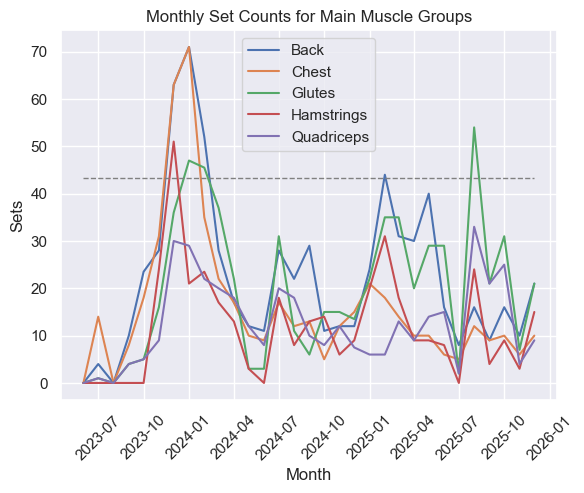

In [739]:
muscle_groups = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps']
goal = goals_dict[goal_year]['weekly_avg_back_set_count'] * 52/12
plot_monthly_set_count(muscle_groups, title='Monthly Set Counts for Main Muscle Groups', goal=goal)

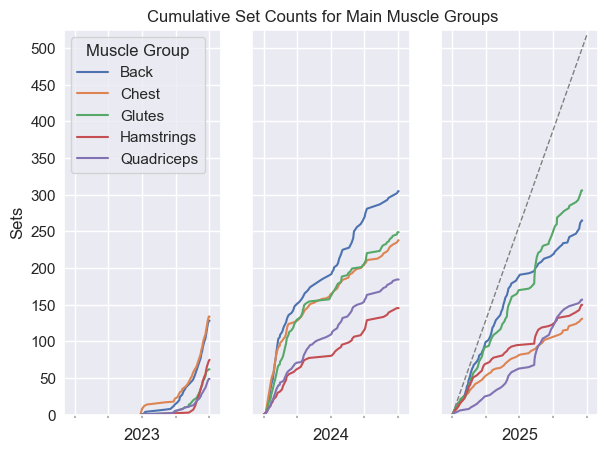

In [740]:
plot_cumulative_lineplot_by_year(workout_df,
                                 columns=[f'{mg}_set_count' for mg in muscle_groups],
                                 labels=[f'{mg.capitalize()}' for mg in muscle_groups],
                                 goals=goals_dict[goal_year]['weekly_avg_back_set_count'] * 52,
                                 ylabel='Sets',
                                 title='Cumulative Set Counts for Main Muscle Groups',
                                 tick_increment=50,
                                 legend_title='Muscle Group')

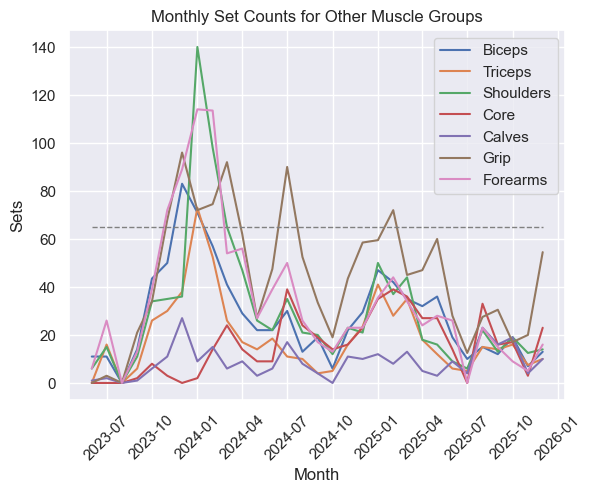

In [741]:
muscle_groups = ['biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
goal = goals_dict[goal_year]['weekly_avg_biceps_set_count'] * 52/12
plot_monthly_set_count(muscle_groups, title='Monthly Set Counts for Other Muscle Groups', goal=goal)

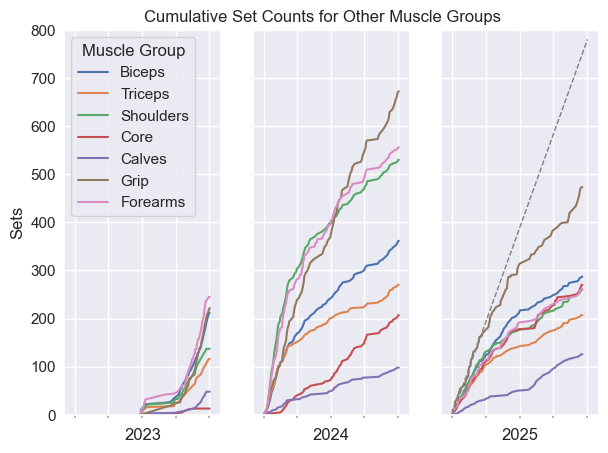

In [742]:
muscle_groups = ['biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
plot_cumulative_lineplot_by_year(workout_df,
                                 columns=[f'{mg}_set_count' for mg in muscle_groups],
                                 labels=[f'{mg.capitalize()}' for mg in muscle_groups],
                                 goals=goals_dict[goal_year]['weekly_avg_biceps_set_count'] * 52,
                                 ylabel='Sets',
                                 title='Cumulative Set Counts for Other Muscle Groups',
                                 tick_increment=100,
                                 legend_title='Muscle Group')

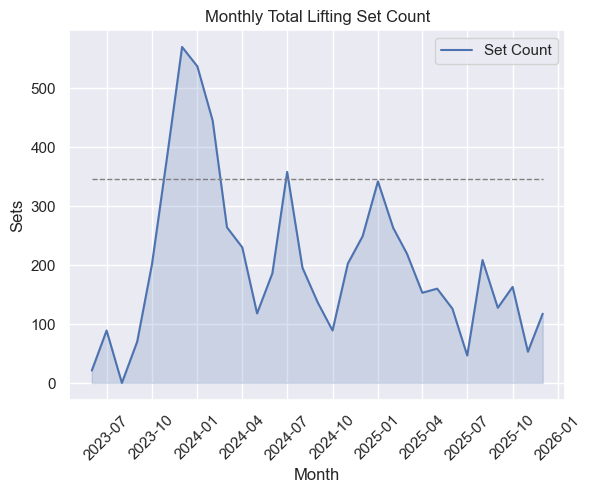

In [743]:
goal = goals_dict[goal_year]['weekly_avg_bilateral_set_count'] * 52/12
plot_values(monthly_workout_df, columns=['bilateral_set_count'], labels=['Set Count'],
            ylabel='Sets', title='Monthly Total Lifting Set Count', goals=goal, area=True)

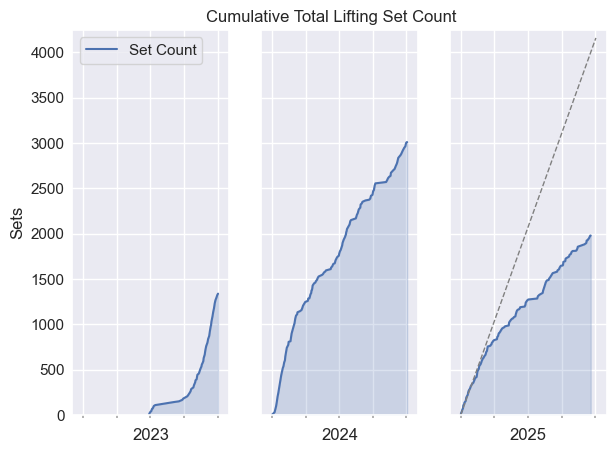

In [744]:
goal = goals_dict[goal_year]['weekly_avg_bilateral_set_count'] * 52
plot_cumulative_lineplot_by_year(workout_df, columns=['bilateral_set_count'], goals=goal,
                                 ylabel='Sets', labels=['Set Count'], tick_increment=500,
                                 title='Cumulative Total Lifting Set Count', area=True)

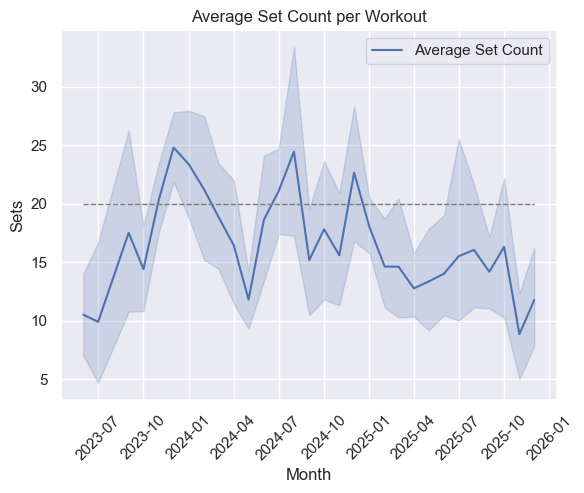

In [745]:
# sets per workout
column = 'bilateral_set_count'
plot_values(workout_df, columns=[column], labels=['Average Set Count'], x_axis='month',
            ylabel='Sets', title='Average Set Count per Workout',
            goals=goals_dict[goal_year][f'avg_lifting_{column}'])

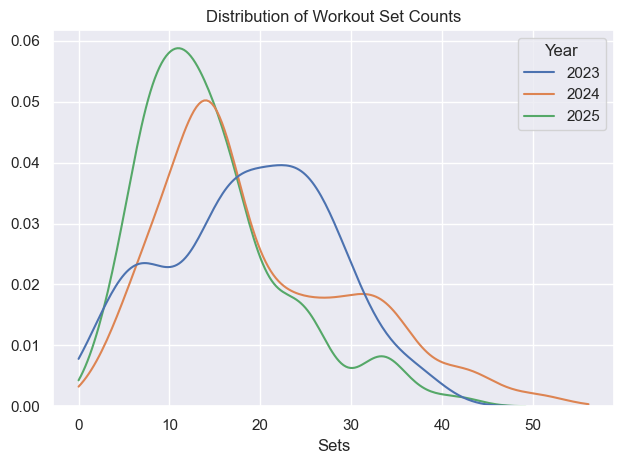

In [746]:
distribution_plot_by_year(workout_df, 'bilateral_set_count', xlabel='Sets',
                          title='Distribution of Workout Set Counts')

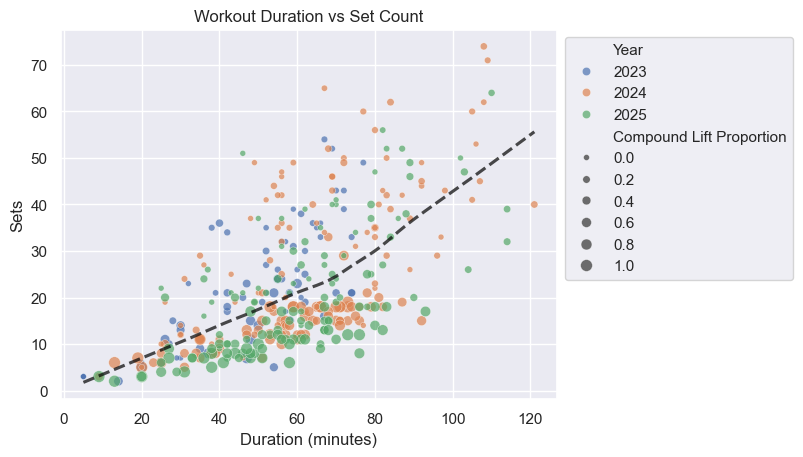

In [747]:
scatterplot_by_year(workout_df, x='lifting_duration_minutes', y='set_count',
                    size='compound_lift_set_proportion', size_label='Compound Lift Proportion',
                    title='Workout Duration vs Set Count',
                    x_label='Duration (minutes)', y_label='Sets')

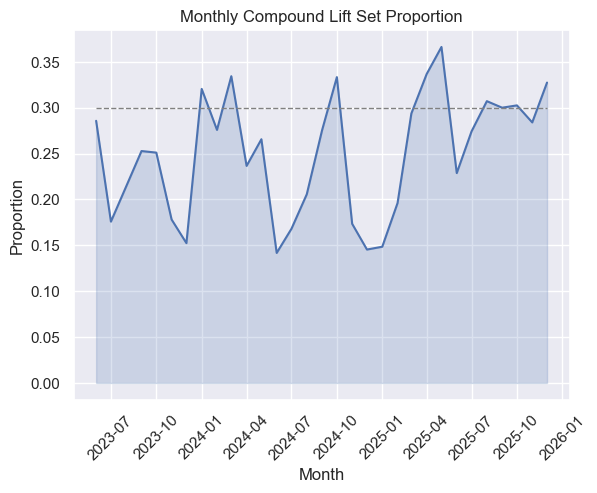

In [748]:
column = 'compound_lift_set_proportion'
plot_values(monthly_workout_df, columns=[column], ylabel='Proportion',
            title='Monthly Compound Lift Set Proportion',
            goals=goals_dict[goal_year][column], area=True, legend=None)

#### 3.2 Workout Counts

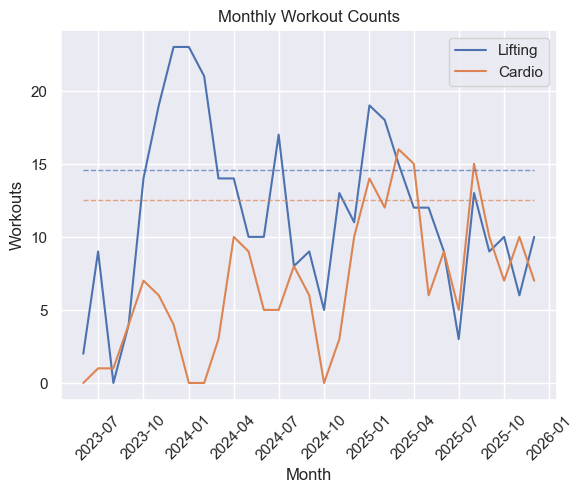

In [749]:
columns = ['lifting_workout_count', 'cardio_workout_count']
goals = [goals_dict[goal_year][c] / 12 for c in columns]
plot_values(monthly_workout_df, columns=columns, labels=['Lifting', 'Cardio'],
            ylabel='Workouts', title='Monthly Workout Counts', goals=goals)

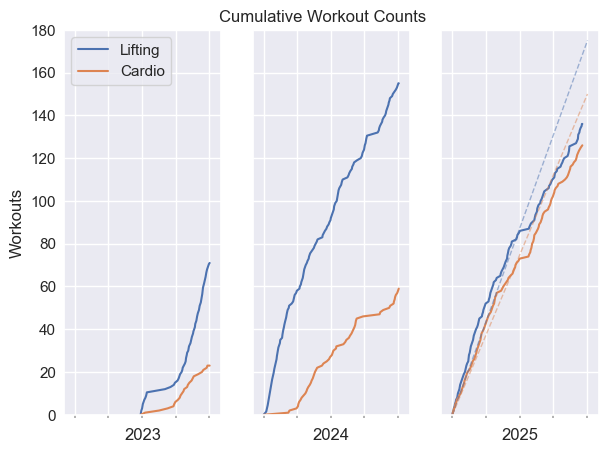

In [750]:
columns = ['lifting_workout_count', 'cardio_workout_count']
plot_cumulative_lineplot_by_year(workout_df,
                                 columns=columns,
                                 labels=['Lifting', 'Cardio'],
                                 goals=[goals_dict[goal_year][c] for c in columns],
                                 ylabel='Workouts',
                                 title='Cumulative Workout Counts')

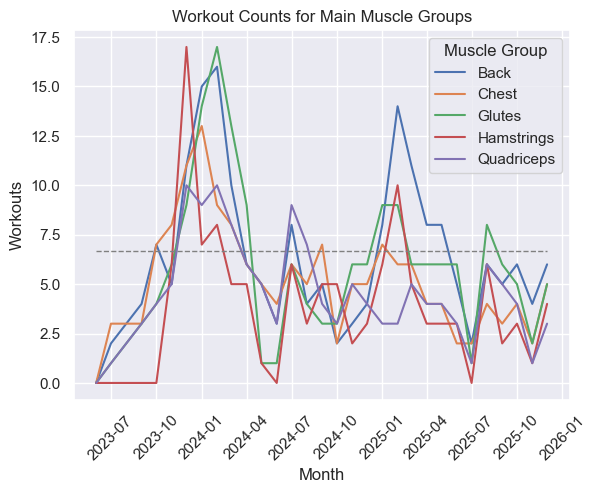

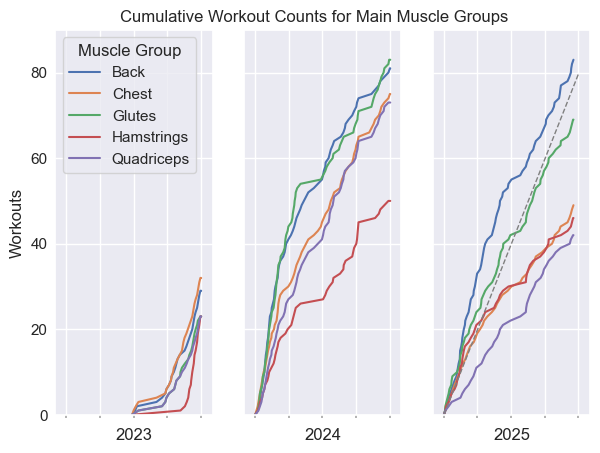

In [751]:
# Workouts with Exercises Targeting Specific Muscle Groups

# prepare data
mask = set_df['workout_type'] == 'lifting'
df = set_df.loc[mask, ['date', 'start_datetime', 'muscle_groups']].explode('muscle_groups').drop_duplicates()
df = df.groupby(['date', 'muscle_groups']).agg(workout_count=('start_datetime', 'nunique')).reset_index()
df = df.pivot(index='date', columns='muscle_groups', values=['workout_count']).reset_index()
df.columns = df.columns.get_level_values(1)  # flatten multiindex
df = df.rename(columns={'': 'date'})  # rename first column
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
df['year'] = df['date'].dt.year

columns = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps']
goal = goals_dict[goal_year]['back workout count']
plot_values(df.loc[:, ['month'] + columns].groupby(['month']).sum().reset_index(), columns=columns,
            labels=[c.capitalize() for c in columns], x_axis='month', ylabel='Workouts',
            title='Workout Counts for Main Muscle Groups', legend_title='Muscle Group', goals=goal/12)
plot_cumulative_lineplot_by_year(df, columns=columns, labels=[c.capitalize() for c in columns],
                                 ylabel='Workouts', legend_title='Muscle Group', goals=goal,
                                 title='Cumulative Workout Counts for Main Muscle Groups')

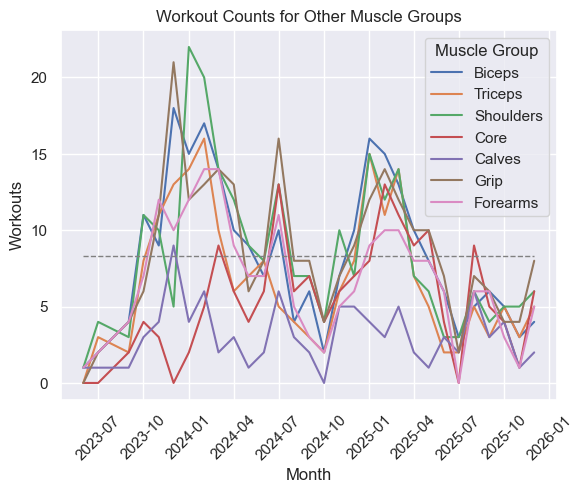

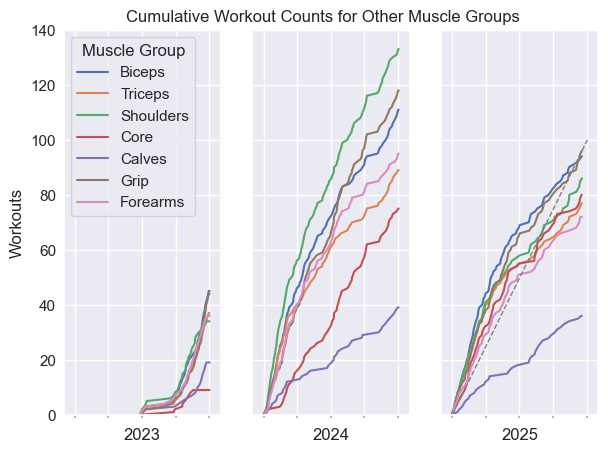

In [752]:
columns = ['biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
goal = goals_dict[goal_year]['biceps workout count']
plot_values(df.loc[:, ['month'] + columns].groupby(['month']).sum().reset_index(), columns=columns,
            labels=[c.capitalize() for c in columns], x_axis='month', ylabel='Workouts',
            title='Workout Counts for Other Muscle Groups', legend_title='Muscle Group', goals=goal/12)
plot_cumulative_lineplot_by_year(df, columns=columns, labels=[c.capitalize() for c in columns],
                                 ylabel='Workouts', legend_title='Muscle Group', goals=goal,
                                 title='Cumulative Workout Counts for Other Muscle Groups')

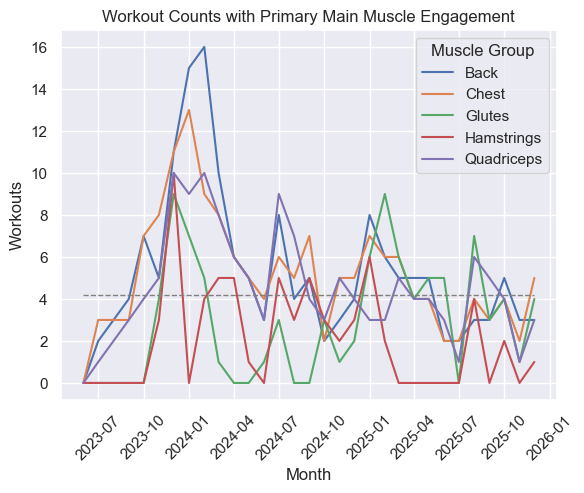

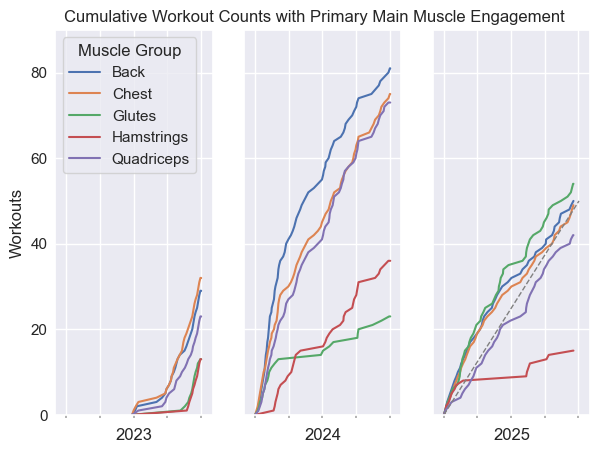

In [753]:
# Workouts with Exercises Primarily Targeting Specific Muscle Groups

# prepare data
mask = (set_df['workout_type'] == 'lifting')
df = set_df.loc[mask, ['date', 'start_datetime', 'primary_muscle_group']].drop_duplicates()
df = df.groupby(['date', 'primary_muscle_group']).agg(workout_count=('start_datetime', 'nunique')).reset_index()
df = df.pivot(index='date', columns='primary_muscle_group', values=['workout_count']).reset_index()
df = df.rename(columns={'workout_count': 'Primary', 'primary_muscle_group': 'muscle_groups'})
df.columns = df.columns.get_level_values(1)  # flatten multiindex
df = df.rename(columns={'': 'date'})  # rename first column
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
df['year'] = df['date'].dt.year

columns = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps']
goal = goals_dict[goal_year]['primary biceps workout count']
plot_values(df.loc[:, ['month'] + columns].groupby(['month']).sum().reset_index(), columns=columns,
            labels=[c.capitalize() for c in columns], x_axis='month', ylabel='Workouts',
            title='Workout Counts with Primary Main Muscle Engagement' , legend_title='Muscle Group', goals=goal/12)
plot_cumulative_lineplot_by_year(df, columns=columns, labels=[c.capitalize() for c in columns],
                                 ylabel='Workouts', legend_title='Muscle Group', goals=goal,
                                 title='Cumulative Workout Counts with Primary Main Muscle Engagement')

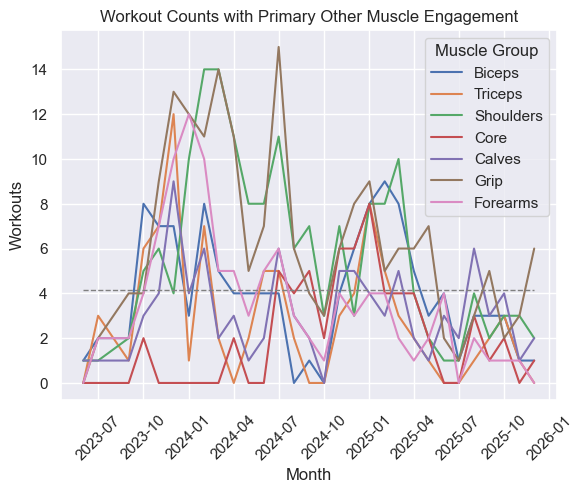

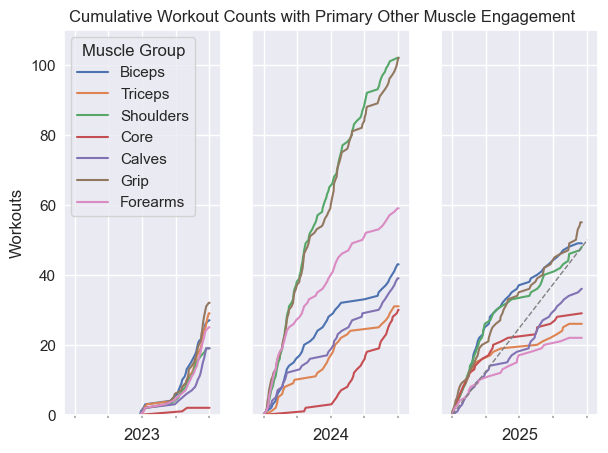

In [754]:
columns = ['biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
goal = goals_dict[goal_year]['primary biceps workout count']
plot_values(df.loc[:, ['month'] + columns].groupby(['month']).sum().reset_index(), columns=columns,
            labels=[c.capitalize() for c in columns], x_axis='month', ylabel='Workouts',
            title='Workout Counts with Primary Other Muscle Engagement' , legend_title='Muscle Group', goals=goal/12)
plot_cumulative_lineplot_by_year(df, columns=columns, labels=[c.capitalize() for c in columns],
                                 ylabel='Workouts', legend_title='Muscle Group', goals=goal,
                                 title='Cumulative Workout Counts with Primary Other Muscle Engagement')

In [755]:
def muscle_group_df(mask, name):
    df = set_df.loc[mask, ['year', 'start_datetime', 'muscle_groups']].explode('muscle_groups').drop_duplicates()
    df = df.groupby(['year', 'muscle_groups']).agg(workout_count=('start_datetime', 'nunique')).reset_index()
    df = df.pivot(index='muscle_groups', columns='year', values=['workout_count']).reset_index()
    df = df.rename(columns={'workout_count': name})
    return df

# prepare data
# all exercises
mask = set_df['workout_type'] == 'lifting'
all_df = muscle_group_df(mask, 'All')
# primary muscle groups
mask = (set_df['workout_type'] == 'lifting')
df = set_df.loc[mask, ['year', 'start_datetime', 'primary_muscle_group']].drop_duplicates()
df = df.groupby(['year', 'primary_muscle_group']).agg(workout_count=('start_datetime', 'nunique')).reset_index()
primary_df = df.pivot(index='primary_muscle_group', columns='year', values=['workout_count']).reset_index()
primary_df = primary_df.rename(columns={'workout_count': 'Primary', 'primary_muscle_group': 'muscle_groups'})
# combine
df = pd.merge(all_df, primary_df, how='left', on=[('muscle_groups', '')]).fillna(0)
muscle_groups = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps',
                 'biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
df = df.loc[df['muscle_groups'].isin(muscle_groups)]
df = df.rename(columns={'muscle_groups': 'Muscle Group'}, level=0)
categories = ['All', 'Primary']
for i, cat in enumerate(categories):
    pos = (i + 1) * (len(df[cat].columns) + 1)
    df.insert(pos, (cat, 'Total'), df[cat].sum(axis=1))
    df[cat] = df[cat].astype(int)
df['Muscle Group'] = pd.Categorical(df['Muscle Group'], categories=muscle_groups, ordered=True)
df = df.sort_values(by=['Muscle Group']).reset_index(drop=True)
df['Muscle Group'] = df['Muscle Group'].str.capitalize()
df.columns.names = [None, None]
for col in df['All'].columns:
    df['Secondary', col] = df['All', col] - df['Primary', col]

vertical_line_cols = ['All', 'Primary', 'Secondary']
caption = 'Workout Count by Primary and Secondary Muscle Engagement'

def workout_count_table_styling(df, vertical_line_cols, caption):

    # add colors and styling
    cmap = sns.light_palette("blue", as_cmap=True)
    df2 = df.style
    for section in categories:
        max_value_in_years = df[section].iloc[:, :-1].values.max()  # max value excluding total sum
        subset = [(section, year) for year in df[section].columns[:-1]]  # exclude the total sum
        df2.background_gradient(cmap=cmap, subset=subset, high=0.8, vmin=0, vmax=max_value_in_years)  # highlight the sum (excluding total)
        df2.background_gradient(cmap=cmap, subset=[(section, 'Total')], high=0.8)  # highlight the total sum 
    df2.set_properties(**{'color': 'black'})  # set all text color to black
    df2.set_table_styles([
        {'selector': 'th.col_heading', 'props': 'text-align: center;'},  # center column headers
        {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.25em;'},  # make headings bigger
        {'selector': 'th.row_heading.level0', 'props': 'border-right: 1px solid black'}, # add vertical line after muscle group
        {'selector': 'tbody', 'props': 'border: 1px solid black'}, # add border around table
        {'selector': 'thead', 'props': 'border: 1px solid black'}, # add border around header
    ], overwrite=False)

    # add horizontal lines
    horizontal_line_positions = [5]
    styles = [{'selector': f'.row{i}', 'props': 'border-top: 1px solid black'} for i in horizontal_line_positions]
    df2.set_table_styles(styles, overwrite=False)

    # add vertical lines
    min_year = df['All'].columns[0]
    styles = {}
    for cat in categories:
        styles[(cat, min_year)] = [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                                {'selector': 'td', 'props': 'border-left: 1px solid black'}]
        styles[(cat, 'Total')] = [{'selector': 'td', 'props': 'border-left: 0.5px dashed black'},
                                {'selector': 'th', 'props': 'border-left: 0.5px dashed black'}]
    df2.set_table_styles(styles, overwrite=False)

    # add caption
    df2 = df2.set_caption(caption)
    df2.set_table_styles([{
            'selector': 'caption',
            'props': [
                ('font-size', '175%'),
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('padding-bottom', '7px'),
            ]
        }], overwrite=False)

    # display dataframe
    if display_styled_df_as_image:
        display_as_image(df2)
    else:
        display(df2)

workout_count_table_styling(df, vertical_line_cols=['All', 'Primary', 'Secondary'],
                            caption='Workout Count by Primary and Secondary Muscle Engagement')

In [756]:
# prepare data
mask = set_df['workout_type'] == 'lifting'
all_df = muscle_group_df(mask, 'All')
mask = (set_df['workout_type'] == 'lifting') & (set_df['muscle_groups'].apply(lambda x: len(x) == 1))
isolation_df = muscle_group_df(mask, 'Isolation')
mask = (set_df['workout_type'] == 'lifting') & (set_df['muscle_groups'].apply(lambda x: len(x) > 1))
compound_df = muscle_group_df(mask, 'Compound')
df = pd.merge(all_df, isolation_df, how='left', on=[('muscle_groups', '')]).fillna(0)
df = pd.merge(df, compound_df, how='left', on=[('muscle_groups', '')]).fillna(0)
muscle_groups = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps',
                 'biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
df = df.loc[df['muscle_groups'].isin(muscle_groups)]
df = df.rename(columns={'muscle_groups': 'Muscle Group'}, level=0)
categories = ['All', 'Isolation', 'Compound']
for i, cat in enumerate(categories):
    pos = (i + 1) * (len(df[cat].columns) + 1)
    df.insert(pos, (cat, 'Total'), df[cat].sum(axis=1))
    df[cat] = df[cat].astype(int)
df['Muscle Group'] = pd.Categorical(df['Muscle Group'], categories=muscle_groups, ordered=True)
df = df.sort_values(by=['Muscle Group']).reset_index(drop=True)
df['Muscle Group'] = df['Muscle Group'].str.capitalize()
df.columns.names = [None, None]

workout_count_table_styling(df, vertical_line_cols=categories,
                            caption='Workout Count by Muscle Group and Compound vs Isolation Exercise')

#### 3.3 Workout Duration

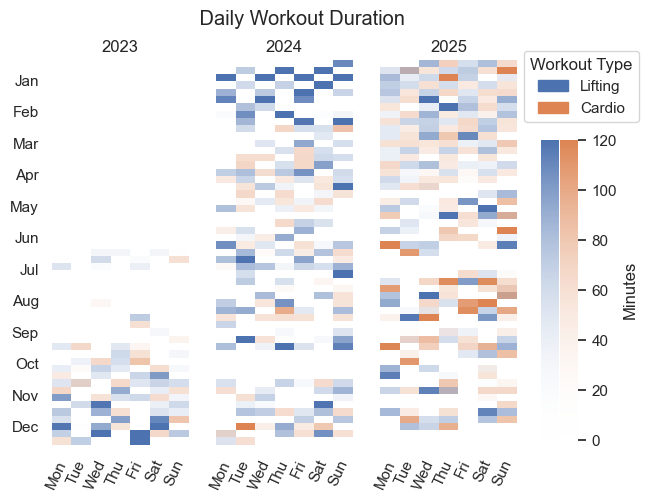

In [757]:
plot_2layer_heatmap_by_year(workout_df,
                            columns=['lifting_duration_minutes', 'cardio_duration_minutes'],
                            labels=['Lifting', 'Cardio'],
                            title='Daily Workout Duration',
                            legend_title='Workout Type',
                            cbar_label='Minutes',
                            cbar_max=120)

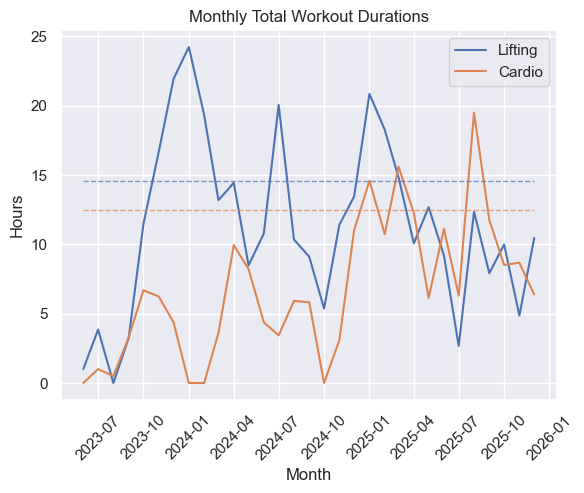

In [758]:
columns = ['lifting_duration_hours', 'cardio_duration_hours']
goals = [goals_dict[goal_year][c] / 12 for c in columns]
plot_values(monthly_workout_df, columns=columns, labels=['Lifting', 'Cardio'],
            ylabel='Hours', title='Monthly Total Workout Durations', goals=goals)

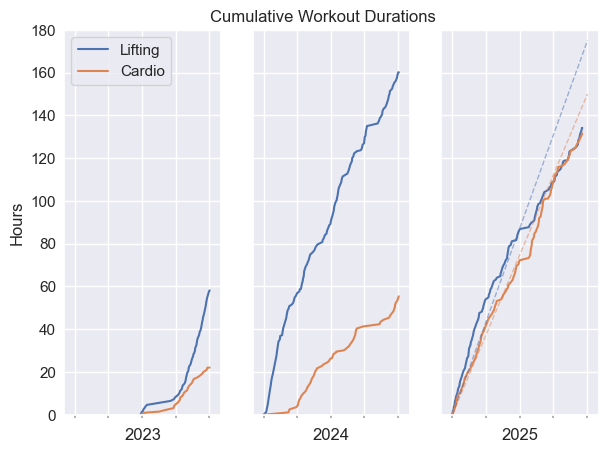

In [759]:
columns = ['lifting_duration_hours', 'cardio_duration_hours']
plot_cumulative_lineplot_by_year(workout_df,
                                 columns=columns,
                                 labels=['Lifting', 'Cardio'],
                                 goals=[goals_dict[goal_year][c] for c in columns],
                                 ylabel='Hours',
                                 title='Cumulative Workout Durations')

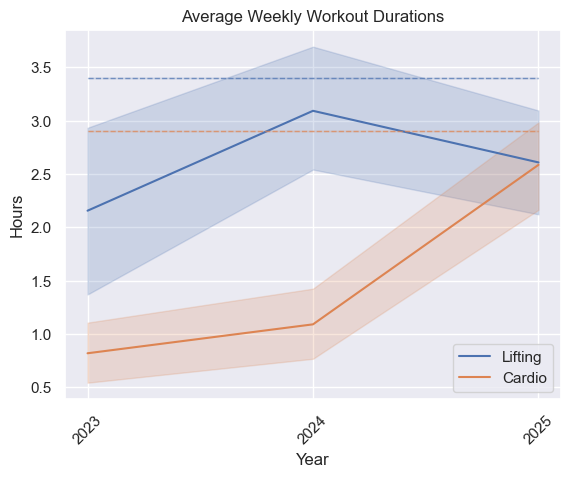

In [760]:
columns = ['lifting_duration_hours', 'cardio_duration_hours']
goals = [goals_dict[goal_year][f'weekly_avg_{c}'] for c in columns]
plot_values(weekly_workout_df, columns, x_axis='year', labels=['Lifting', 'Cardio'],
            ylabel='Hours', title='Average Weekly Workout Durations', goals=goals)

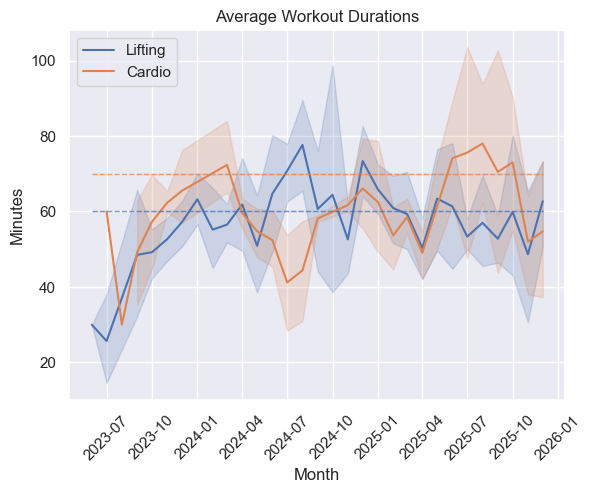

In [761]:
columns = ['lifting_duration_minutes', 'cardio_duration_minutes']
goals = [goals_dict[goal_year][f'avg_{c}'] for c in columns]
plot_values(workout_df, columns=columns, labels=['Lifting', 'Cardio'],
            ylabel='Minutes', title='Average Workout Durations', x_axis='month', goals=goals)

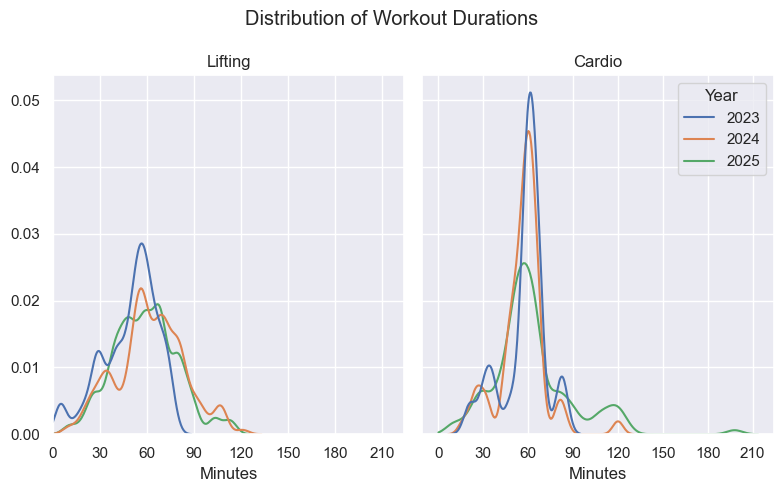

In [762]:
# Distribution of workout durations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

df = pd.DataFrame(workout_df, columns=['workout_type', 'year', 'workout_duration_minutes'])
df_lifting = df[df['workout_type'] == 'lifting']
df_cardio = df[df['workout_type'] == 'cardio']
max_duration = df['workout_duration_minutes'].max()
common_kwargs = {
    'x': 'workout_duration_minutes',
    'hue': 'year',
    'common_norm': False,
    'clip': [0, 1.1 * max_duration],
    'palette': 'deep',
    'bw_adjust': 0.5,
}
sns.kdeplot(ax=axes[0], data=df_lifting, **common_kwargs, legend=False)
sns.kdeplot(ax=axes[1], data=df_cardio, **common_kwargs)
axes[0].set_title('Lifting')
axes[1].set_title('Cardio')
axes[1].get_legend().set_title('Year')
for ax in axes:
    ax.set_xlabel('Minutes')
    ax.set_xticks(range(0, int(ax.get_xlim()[1]), 30))
    ax.set_ylabel(None)
plt.suptitle('Distribution of Workout Durations')
# use common ticks, tick labels, and lim for both plots
use_common_axis(axes[0], axes[1], axis='both')
axes[1].set_yticklabels([])  # remove y-tick labels from second plot
plt.tight_layout()
plt.show()

#### 3.4 Workout Time

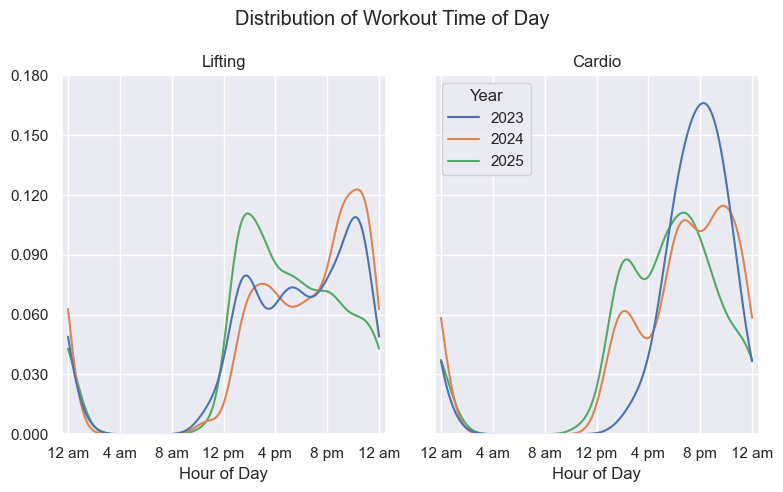

In [763]:
# Distribution of workout time
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

df = pd.DataFrame(workout_df, columns=['workout_type', 'year', 'start_datetime', 'end_datetime'])
# get midpoint between start and end of workout
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df['end_datetime'] = pd.to_datetime(df['end_datetime'])
df['mid_datetime'] = df['start_datetime'] + (df['end_datetime'] - df['start_datetime']) / 2
df['hour_of_day'] = df['mid_datetime'].dt.hour + df['mid_datetime'].dt.minute / 60

# mirror data to create a continuous timeline over midnight
df_plus = df.copy()
df_plus['hour_of_day'] = df_plus['hour_of_day'] + 24
df_minus = df.copy()
df_minus['hour_of_day'] = df_minus['hour_of_day'] - 24
df = pd.concat([df_minus, df, df_plus], ignore_index=True)

df_lifting = df[df['workout_type'] == 'lifting']
df_cardio = df[df['workout_type'] == 'cardio']
common_kwargs = {
    'x': 'hour_of_day',
    'hue': 'year',
    'common_norm': False,
    'clip': [0,24],
    'palette': 'deep',
    'bw_adjust': 0.15,
}
sns.kdeplot(ax=axes[0], data=df_lifting, **common_kwargs, legend=False)
sns.kdeplot(ax=axes[1], data=df_cardio, **common_kwargs)
axes[0].set_title('Lifting')
axes[1].set_title('Cardio')
axes[1].get_legend().set_title('Year')
for ax in axes:
    ax.set_xlabel('Hour of Day')
    ax.set_xlim([-0.5, 24.5])
    ax.set_xticks(range(0, 25, 4))
    ax.set_xticklabels(['12 am', '4 am', '8 am', '12 pm', '4 pm', '8 pm', '12 am'])
    yticks = ax.get_yticks()
    # multiply y-tick labels by 3 to correct for mirrored data
    ax.set_yticks(yticks, labels=[f'{y*3:.3f}' for y in yticks])
    ax.set_ylabel(None)
plt.suptitle('Distribution of Workout Time of Day')
# use common y-axis (ticks, tick labels, lim) for both plots
use_common_axis(axes[0], axes[1], axis='y')
axes[1].set_yticklabels([])  # remove y-tick labels from second plot
plt.tight_layout()
plt.show()

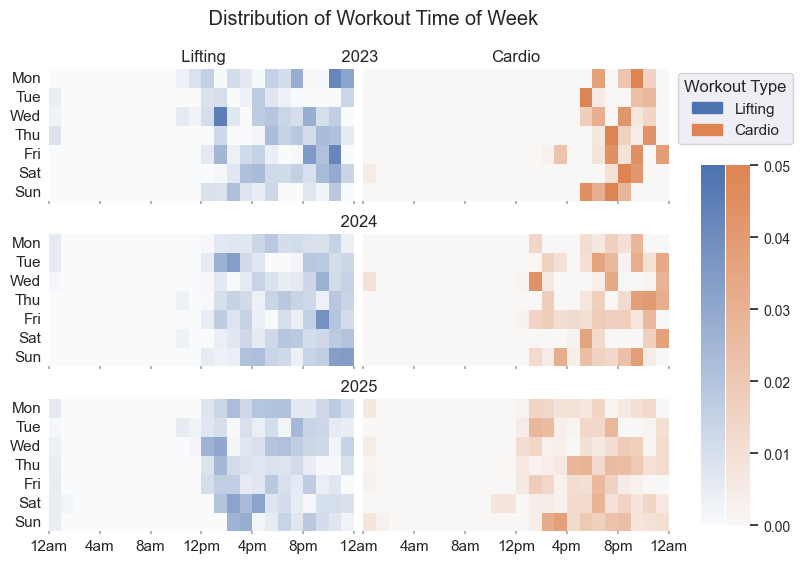

In [764]:
# make custom colormaps
cmap0 = LinearSegmentedColormap.from_list("", ["#f9fafb", "C0"])  # white to blue
cmap1 = LinearSegmentedColormap.from_list("", ["#f9f7f6", "C1"])  # white to orange
cmaps = [cmap0, cmap1]

years = sorted(workout_df['year'].unique().tolist())
n_years = len(years)
fig, axes = plt.subplots(len(years), 2, figsize=(8, 2 * n_years))

workout_types = ['lifting', 'cardio']
for j, workout_type in enumerate(workout_types):
    cmap = cmaps[j]

    # initial data preparation
    df = workout_df.copy()
    df = df.loc[df['workout_type'] == workout_type, :].reset_index(drop=True)  # filter by exercise type
    df['start_datetime'] = pd.to_datetime(df['start_datetime'])
    df['end_datetime'] = pd.to_datetime(df['end_datetime'])
    # get minutes in each hour of the week
    df['hour_array'] = df.apply(lambda row: get_hour_array(row['start_datetime'], row['end_datetime']), axis=1)
    hour_df = pd.DataFrame(df['hour_array'].tolist(), columns=list(range(7 * 24)))
    df = pd.concat([df['year'], hour_df], axis=1)

    # get counts of each day of the week for each year (for normalization)
    day_of_week_totals = get_days_of_week_count_df(workout_df)  # counts of each day of week per year
    days_of_week_map = {'Monday': 'Mon',
                        'Tuesday': 'Tue',
                        'Wednesday': 'Wed',
                        'Thursday': 'Thu',
                        'Friday': 'Fri',
                        'Saturday': 'Sat',
                        'Sunday': 'Sun'}
    day_of_week_totals['day_of_week'] = day_of_week_totals['day_of_week'].map(days_of_week_map)
    day_of_week_totals.drop(['start_date', 'end_date'], axis=1, inplace=True)

    days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    hour_cols = list(range(24))
    df_years = []
    for i, year in enumerate(years):
        # prepare data
        df_year = df[df['year'] == year].copy()
        df_year.drop('year', axis=1, inplace=True)
        df_year = pd.DataFrame(df_year.sum(axis=0).values.reshape(7, 24))  # sum minutes in each hour of week
        days_of_week_df = pd.DataFrame(days_of_week, columns=['day_of_week'])
        df_year = pd.concat([days_of_week_df, df_year], axis=1)
        # normalize by number of that weekday in that year
        day_of_week_totals_year = day_of_week_totals[day_of_week_totals['year'] == year]
        df_year = pd.merge(day_of_week_totals_year, df_year, how='left')
        df_year[hour_cols] = df_year[hour_cols].div(df_year['day_count'], axis=0)  # normalize by day count
        df_year.drop(['day_count', 'year'], axis=1, inplace=True)
        df_year['day_of_week'] = pd.Categorical(df_year['day_of_week'], days_of_week)  # set categorical order
        df_year.sort_values(['day_of_week'], inplace=True)
        df_year.drop('day_of_week', axis=1, inplace=True)
        df_year /= df_year.sum().sum()  # normalize by total minutes
        df_years.append(df_year)

        # plot heatmap
        ax = axes[i][j]
        max_val = 0.05 # max(df_year.max().max() for df_year in df_years)
        heatmap_kws = {'ax': ax, 'cmap': cmap, 'vmin': 0, 'vmax': max_val}
        if i == len(years) - 1:  # add colorbar to last heatmap (on each side)
            if j == 0:
                cbar_ax = fig.add_axes((0.94, 0.12, 0.03, 0.6))
                cbar_kws = {'label': ''}
            else:
                cbar_kws = {'label': '', 'orientation': 'vertical'}
                cbar_ax = fig.add_axes((0.972, 0.12, 0.03, 0.6))
            heatmap = sns.heatmap(df_years[i], **heatmap_kws, cbar=True, cbar_ax=cbar_ax, cbar_kws=cbar_kws)
            cbar = heatmap.collections[0].colorbar
            if cbar is not None:
                cbar.ax.tick_params(labelsize=10)  # adjust cbar label size
                if j == 0: 
                    cbar.set_ticks([])  # remove cbar ticks
        else:
            sns.heatmap(df_years[i], **heatmap_kws, cbar=False)
        
        # add y-tick labels
        if j == 0:
            ax.set_yticks(np.arange(7) + 0.5)
            ax.set_yticklabels(days_of_week, rotation=0)
        else:
            ax.set_yticklabels([])
        # add x-tick labels
        ax.set_xticks(range(0, 25, 4))
        ax.tick_params(which='major', bottom=True, top=False,length=2, color='darkgrey', direction='out')
        if i == len(years) - 1:
            if j == 0:
                ax.set_xticklabels(['12am', '4am', '8am', '12pm', '4pm', '8pm', '  12am'], rotation=0)
            else:
                ax.set_xticklabels(['', '4am', '8am', '12pm', '4pm', '8pm', '12am'], rotation=0)
        # doing some spacing manipulation to get the subtitles centered
        if i == 0:
            if j == 0:
                ax.set_title(34*' ' + f'{workout_types[j].capitalize()}' + 25*' ' + f'{year}')
            else:
                ax.set_title(f'{workout_types[j].capitalize()}')
        elif j == 0:
            ax.set_title(f'{68*" "}{year}')
        ax.set_ylabel(None)
        ax.set_xlabel(None)

# add legend
custom_colors = [cmap(0.999) for cmap in cmaps]
custom_labels = [m.capitalize() for m in workout_types]
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, custom_labels)]
plt.legend(handles=handles, loc=(-2, 1.06), title="Workout Type")

title = 'Distribution of Workout Time of Week'
plt.suptitle(f'         {title}')  # offset title to the right because of the colorbar
plt.subplots_adjust(wspace=0.03, hspace=0.25) # Reduce the spacing between subplots
plt.show() 

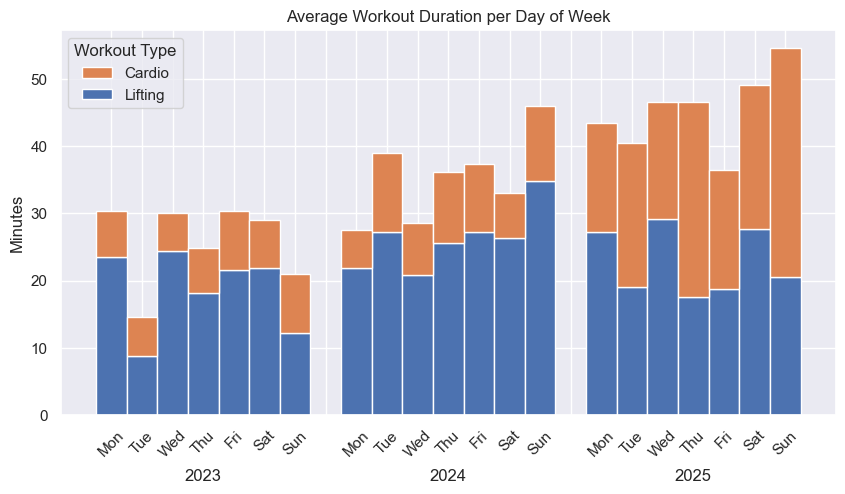

In [765]:
# make dataframe with workout counts and total durations per day of week (per year)
df = workout_df.copy()
df['day_of_week'] = pd.to_datetime(df['date']).dt.day_name()
df = df.groupby(['year', 'day_of_week']) \
    .agg(workout_count=('date', 'count'),
         total_duration_minutes=('workout_duration_minutes', 'sum'),
         cardio_duraton_minutes=('cardio_duration_minutes', 'sum'),
         lifting_duration_minutes=('lifting_duration_minutes', 'sum')) \
    .reset_index()
day_of_week_totals = get_days_of_week_count_df(workout_df)  # counts of each day of week per year
df = pd.merge(day_of_week_totals, df, how='left')
df['avg_duration_minutes'] = df['total_duration_minutes'] / df['day_count']
df['avg_cardio_duration_minutes'] = df['cardio_duraton_minutes'] / df['day_count']
df['avg_lifting_duration_minutes'] = df['lifting_duration_minutes'] / df['day_count']
days_of_week_map = {'Monday': 'Mon',
                    'Tuesday': 'Tue',
                    'Wednesday': 'Wed',
                    'Thursday': 'Thu',
                    'Friday': 'Fri',
                    'Saturday': 'Sat',
                    'Sunday': 'Sun'}
df['day_of_week'] = df['day_of_week'].map(days_of_week_map)
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['day_of_week'] = pd.Categorical(df['day_of_week'], days_of_week)  # set categorical order
df.sort_values(['year', 'day_of_week'], inplace=True)
df = df[['year', 'day_of_week', 'avg_cardio_duration_minutes', 'avg_lifting_duration_minutes']]

plot_stacked_grouped_bar_chart(df=df,
                               x_major_column='year',
                               x_minor_column='day_of_week',
                               stack_columns=['avg_lifting_duration_minutes', 'avg_cardio_duration_minutes'],
                               stack_labels=['Lifting', 'Cardio'],
                               y_label='Minutes',
                               title='Average Workout Duration per Day of Week',
                               legend_title='Workout Type')

#### 3.5 Cardio Variety

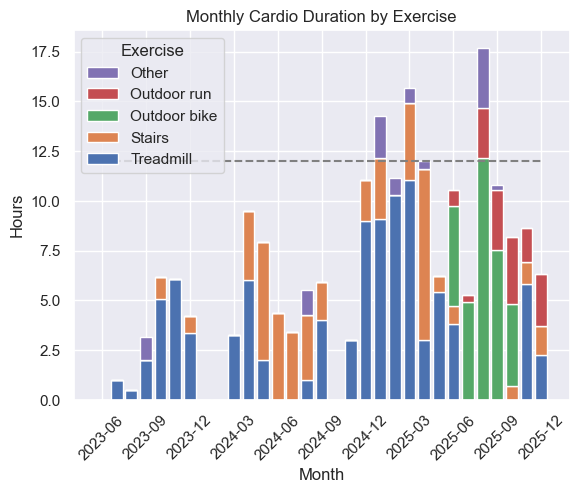

In [766]:
# Monthly Cardio Duration by Exercise

df = pd.DataFrame(monthly_workout_df, columns=['month'] + cardio_duration_columns)

# convert month to string, so that bars are evenly spaced (otherwise Feb is closer to Mar since it's shorter)
df['month'] = df['month'].astype(str).str.slice(stop=7)
df.set_index('month', inplace=True)

colors = sns.color_palette('deep', len(df.columns))
fig, ax = plt.subplots()
bottom_values = np.zeros(len(df.index), dtype=float)
for i, exercise in enumerate(df.columns):
    ax.bar(x=df.index, height=df[exercise], bottom=bottom_values, label=exercise, color=colors[i])
    bottom_values += df[exercise].values

# Add line for monthly duration goal
goal = goals_dict[goal_year]['cardio_duration_hours'] / 12
sns.lineplot(data=df, x='month', y=12, color='gray', linestyle='--')

# rotate and show fewer xtick labels
x = df.index
tick_skips = max(1, len(x) // 8)
ax.set_xticks(x[::tick_skips])
ax.set_xticklabels(x[::tick_skips], rotation=45)

ax.set_xlabel("Month")
ax.set_ylabel("Hours")
ax.set_title("Monthly Cardio Duration by Exercise")
handles, labels = ax.get_legend_handles_labels()  # get current legend details
plt.legend(handles=handles[::-1], labels=['Other'] + most_common_cardio_exercises[::-1], title='Exercise')
plt.show()
# Note that the totals are sometimes less than the previous plot, due to idle time within a workout
# sometimes not being counted here (e.g. when biking outdoors and stopping at a traffic light).

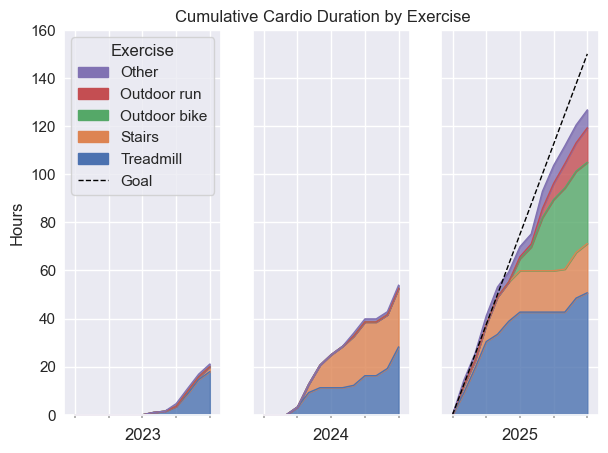

In [767]:
goal = goals_dict[goal_year]['cardio_duration_hours']
years = sorted(monthly_workout_df['year'].unique().tolist())
n_years = len(years)
fig, axes = plt.subplots(1, n_years, figsize=(2.3 * n_years, 5))

# prepare data (create cumulative sums for each year)
dfs = []
month_int_df = pd.DataFrame(range(13), columns=['month_int'])  # extra row for starting the year at 0
for i, year in enumerate(years):
    df = pd.DataFrame(monthly_workout_df, columns=['month', 'year'] + cardio_duration_columns)
    df = df[df['year'] == year].copy()
    df['month_int'] = df['month'].dt.month
    if i == len(years) - 1: # exclude future months in the last year
        max_month = df['month_int'].max()
        month_int_df = pd.DataFrame(range(max_month + 1), columns=['month_int'])
    df.set_index('month_int', inplace=True)
    df = month_int_df.join(df, how='left', on='month_int').fillna(0)
    df.drop(columns=['year', 'month'], inplace=True)
    df.set_index('month_int', inplace=True)
    df = df.cumsum(axis=0).cumsum(axis=1)
    dfs.append(df)
# get max y-values (for consistent y-axis in plots)
y_max = max(df.iloc[-1,-1] for df in dfs)
tick_increment = 20
y_max = max(y_max, goal)
# round up to nearest multiple of 0.5 * tick_increment
y_max = ((2 * y_max) // tick_increment + 1) * tick_increment / 2


# plot stacked area chart
for i, year in enumerate(years):
    ax = axes[i]
    # add initial lines
    sns.lineplot(data=dfs[i], ax=ax, dashes=False, linewidth=1, legend=False)
    # fill area between lines
    for j, line in enumerate(ax.lines):
        x = line.get_xdata()
        if len(x) == 0:
            continue
        if j == 0:
            y_prev = np.zeros(len(x))
        else:
            y_prev = y
        y = line.get_ydata()
        ax.fill_between(x, y_prev, y, color=line.get_color(), alpha=0.8)
    # add goal line to latest year
    if i == len(years) - 1:
        goal = goals_dict[str(year)]['cardio_duration_hours']
        sns.lineplot(x=[0,12], y=[0,goal], ax=ax, linewidth=1, linestyle='--', color='black', alpha=1)
    # set lims, ticks, and labels
    if i == 0:
        ax.set_ylabel('Hours')
    else:
        ax.set_yticklabels([])
    ax.set_yticks(np.arange(0, y_max + tick_increment, tick_increment))
    ax.set_ylim(0, y_max)
    ax.set_xlim(-1, 13)
    ax.set_xticks(np.arange(0, 13, 3))
    ax.set_xticklabels([])
    ax.tick_params(which='major', bottom=True, length=2, color='darkgrey', direction='out')
    ax.set_xlabel(year)            
title = 'Cumulative Cardio Duration by Exercise'
plt.suptitle(title, y=0.92, fontsize=ax.title.get_fontsize())

# manually add legend
labels = ['Other'] + most_common_cardio_exercises[::-1] 
colors = [f'C{i}' for i in range(len(labels))][::-1]
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)]
goal_handle = Line2D([0], [0], color='black', lw=1, label='Goal', linestyle='--', alpha=1)
handles.append(goal_handle)
axes[0].legend(handles=handles, title='Exercise', loc='upper left')

plt.show()

#### 3.6 Cardio Intensity

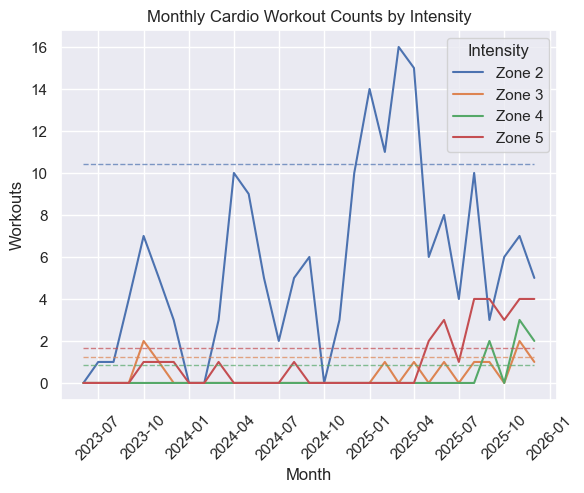

In [768]:
columns = ['zone_2', 'zone_3', 'zone_4', 'zone_5']
labels = [s.capitalize().replace('_', ' ') for s in columns]
goals = [goals_dict[goal_year][c] / 12 for c in columns]
plot_values(monthly_workout_df, columns=columns, labels=labels,
            ylabel='Workouts', title='Monthly Cardio Workout Counts by Intensity', goals=goals,
            legend_title='Intensity')

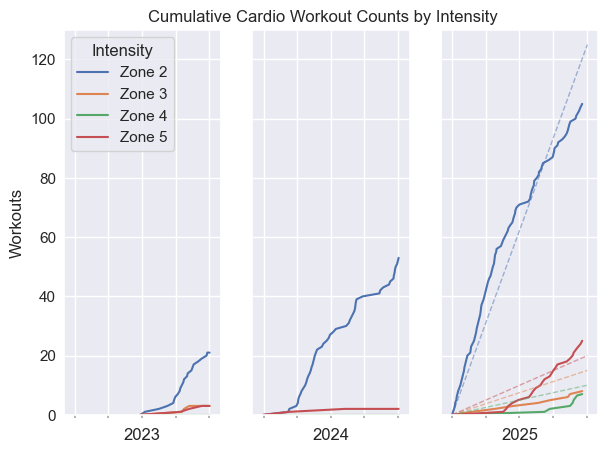

In [769]:
columns = ['zone_2', 'zone_3', 'zone_4', 'zone_5']
goals = [goals_dict[goal_year][c] for c in columns]
plot_cumulative_lineplot_by_year(workout_df,
                                 columns=columns,
                                 labels=[s.capitalize().replace('_', ' ') for s in columns],
                                 goals=goals,
                                 ylabel='Workouts',
                                 title='Cumulative Cardio Workout Counts by Intensity',
                                 legend_title='Intensity')

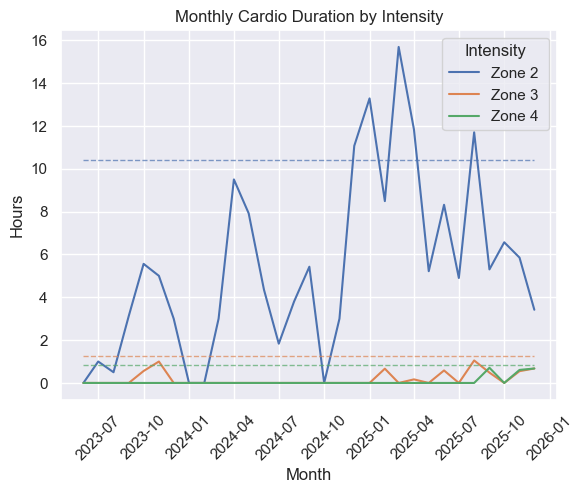

In [770]:
columns = ['zone_2_hours', 'zone_3_hours', 'zone_4_hours']
labels = [s.removesuffix('hours').capitalize().replace('_', ' ') for s in columns]
goals = [goals_dict[goal_year][c] / 12 for c in columns]
plot_values(monthly_workout_df, columns=columns, labels=labels, ylabel='Hours',
            title='Monthly Cardio Duration by Intensity', goals=goals, legend_title='Intensity')

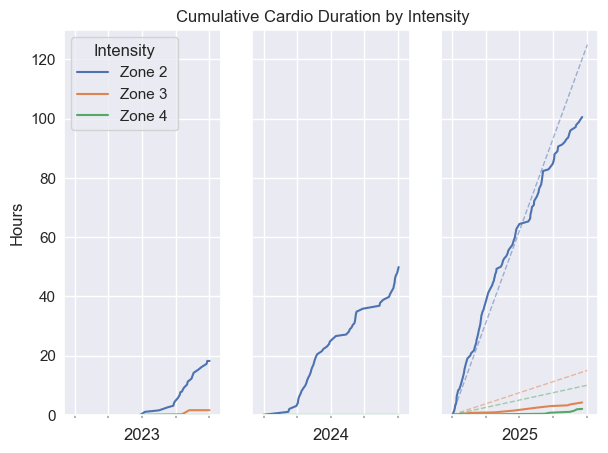

In [771]:
columns = ['zone_2_hours', 'zone_3_hours', 'zone_4_hours']
goals = [goals_dict[goal_year][c] for c in columns]
plot_cumulative_lineplot_by_year(workout_df,
                                 columns=columns,
                                 labels=[s.removesuffix('hours').capitalize().replace('_', ' ') for s in columns],
                                 goals=goals,
                                 ylabel='Hours',
                                 title='Cumulative Cardio Duration by Intensity',
                                 legend_title='Intensity')

#### 3.7 Lifting Variety

In [772]:
# most common exercise for each muscle group
muscle_groups = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps', 'biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
n_exercises_per_muscle_group = 9  # number of exercises to show per muscle group
dfs = []
for muscle_group in muscle_groups:
    df = set_df.loc[set_df['muscle_groups'].apply(lambda arr: len(arr) > 0 and muscle_group == arr[0]), ['year', 'exercise', 'set_count']]
    df = df.groupby(['year', 'exercise']).size().reset_index(name='Set Count')
    exercise_df = set_df[set_df['set_count'] == 1].groupby(['year', 'exercise']).size().reset_index(name='Workout Count')
    df = df.merge(exercise_df, how='left', on=['year', 'exercise'])
    df = df.pivot(index='exercise', columns='year', values=['Workout Count', 'Set Count']).fillna(0).astype(int)
    df.insert(len(df['Workout Count'].columns), ('Workout Count', 'Total'), df['Workout Count'].sum(axis=1))  # total sets across all years
    df['Set Count', 'Total'] = df['Set Count'].sum(axis=1)  # total sets across all years
    df = df[df['Workout Count', 'Total'] >= 5]  # filter out exercises with less than 5 total sets
    df = df.sort_values(('Workout Count', 'Total'), ascending=False)
    df['Muscle Group'] = muscle_group.capitalize()
    df = df.set_index('Muscle Group', append=True).swaplevel()
    df = df.head(n_exercises_per_muscle_group)
    dfs.append(df)
df = pd.concat(dfs, axis=0)
df.index.names = ['Primary Muscle Group', 'Exercise']  # rename index level
df.columns.names = ['', '']  # remove column index name ('year')

# add colors and styling
cmap = sns.light_palette("blue", as_cmap=True)
df2 = df.style
sections = ['Workout Count', 'Set Count']
for section in sections:
    max_value_in_years = df[section].iloc[:, :-1].values.max()  # max value excluding total sum
    subset = [(section, year) for year in df[section].columns[:-1]]  # exclude the total sum
    df2.background_gradient(cmap=cmap, subset=subset, high=0.8, vmin=0, vmax=max_value_in_years)  # highlight the sum (excluding total)
    df2.background_gradient(cmap=cmap, subset=[(section, 'Total')], high=0.8)  # highlight the total sum 
df2.set_properties(**{'color': 'black'})  # set all text color to black
df2.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},  # center column headers
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.25em;'},  # make headings bigger
    {'selector': 'th.row_heading.level0', 'props': 'text-align: center;'},  # center row headers
    {'selector': 'th.row_heading.level0', 'props': 'font-size: 1.25em;'},  # make headings bigger
    {'selector': 'th.row_heading.level0', 'props': 'font-weight: bold;'}, # bold muscle group headers
    {'selector': 'th.row_heading.level1', 'props': 'text-align: left;'},  # left align row headers
    {'selector': 'th.index_name', 'props': 'text-align: center;'},  # center index name
    {'selector': 'th.index_name', 'props': 'font-size: 1.25em;'},  # center index name
    {'selector': 'th.row_heading.level0', 'props': 'border-right: 1px solid black'}, # add vertical line after muscle group
    {'selector': 'th.index_name', 'props': 'border-left: 1px solid black'}, # add vertical line after muscle group header
    {'selector': 'tbody', 'props': 'border: 1px solid black'}, # add border around table
    {'selector': 'thead', 'props': 'border: 1px solid black'}, # add border around header
], overwrite=False)

# add horizontal lines between muscle groups
first_value_row_number = [0]  # get row number of first row of each muscle group
for i in range(1, len(df.index)):
    if df.index[i][0] != df.index[i - 1][0]:
        first_value_row_number.append(i)
styles = [{'selector': f'.row{i}', 'props': 'border-top: 1px solid black'} for i in first_value_row_number]
df2.set_table_styles(styles, overwrite=False)

# add vertical lines to separate sections
min_year = df['Workout Count'].columns[0]
styles = {}
for section in sections:
    styles[(section, min_year)] = [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                                   {'selector': 'td', 'props': 'border-left: 1px solid black'}]
    styles[(section, 'Total')] = [{'selector': 'td', 'props': 'border-left: 0.5px dashed black'},
                                  {'selector': 'th', 'props': 'border-left: 0.5px dashed black'}]
df2.set_table_styles(styles, overwrite=False)

# add caption
df2 = df2.set_caption('Most Common Exercises by Muscle Group')
df2.set_table_styles([{
        'selector': 'caption',
        'props': [
            ('font-size', '200%'),
            ('font-weight', 'bold'),
            ('text-align', 'center'), # Captions are centered by default, but this is explicit
            ('padding-bottom', '7px'),
        ]
    }], overwrite=False)

# display dataframe
if display_styled_df_as_image:
    display_as_image(df2)
else:
    display(df2)

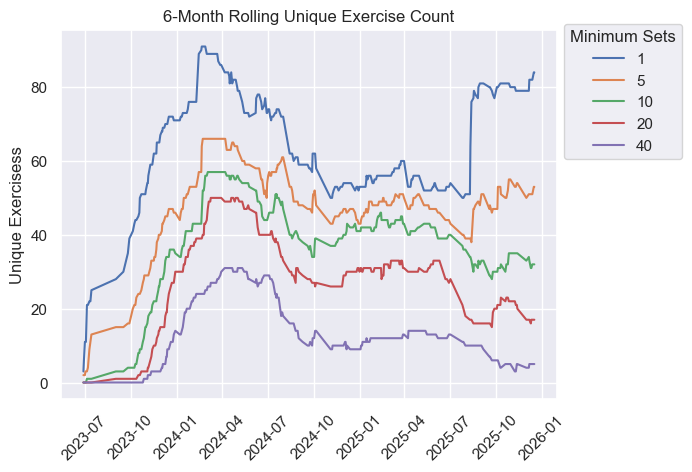

In [773]:
# specify parameters
window_size = 30 * 6  # rolling window size
thresholds = [1, 5, 10, 20, 40]  # exercise count thresholds to track

# initialize variables
rolling_window_list = []
exercise_counts = {}
threshold_counts = {t: 0 for t in thresholds}
muscle_groups_counts = {muscle_group: 0 for muscle_group in tracked_muscle_groups}
df = set_df.loc[set_df['workout_type'] == 'lifting', ['date', 'exercise', 'muscle_groups']].copy()
dates = sorted(df['date'].unique())
prev_date_lb = dates[0] - timedelta(days=window_size)  # initialize previous date lower bound

# compute rolling window for each date
for date in dates:
    
    # add exercise counts for new date
    exercises_counts_add = df.loc[df['date'] == date, 'exercise'].value_counts().to_dict()
    for exercise, count in exercises_counts_add.items():
        # update exercise counts
        old_count = exercise_counts.get(exercise, 0)
        new_count = old_count + count
        exercise_counts[exercise] = new_count
        # update threshold counts
        for threshold in threshold_counts:
            if old_count < threshold <= new_count:
                threshold_counts[threshold] += 1
        # update muscle group counts
        for muscle_group in muscle_groups_dict.get(exercise, []):
            if muscle_group not in muscle_groups_counts:
                continue
            if old_count < 1 <= new_count:
                muscle_groups_counts[muscle_group] += 1

    # remove exercise counts for previous dates
    date_lb = date - timedelta(days=window_size)
    mask = (df['date'] >= prev_date_lb) & (df['date'] < date_lb)
    exercises_counts_remove = df.loc[mask, 'exercise'].value_counts().to_dict()
    for exercise, count in exercises_counts_remove.items():
        # update exercise counts
        old_count = exercise_counts.get(exercise, 0)
        new_count = old_count - count
        exercise_counts[exercise] = new_count
        # update threshold counts
        for threshold in threshold_counts:
            if new_count < threshold <= old_count:
                threshold_counts[threshold] -= 1
        # update muscle group counts
        for muscle_group in muscle_groups_dict.get(exercise, []):
            if muscle_group not in muscle_groups_counts:
                continue
            if new_count < 1 <= old_count:
                muscle_groups_counts[muscle_group] -= 1

    prev_date_lb = date_lb

    # save snapshot of rolling window
    record = {'date': date} | \
             threshold_counts | \
             {'total_sets': sum(exercise_counts.values())} | \
             muscle_groups_counts
    rolling_window_list.append(record)

df = pd.DataFrame(rolling_window_list)

plot_values(df,
            columns=thresholds,
            x_axis='date',
            ylabel='Unique Exercisess',
            title='6-Month Rolling Unique Exercise Count',
            legend_title='Minimum Sets',
            legend_loc=(1.015, 0.65))

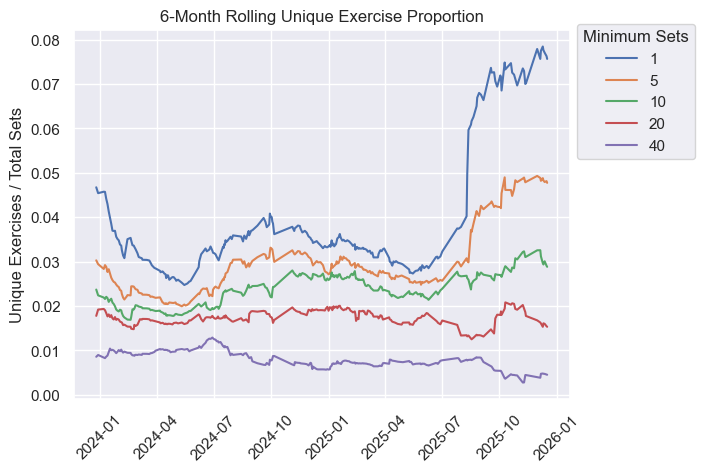

In [774]:
df2 = df[['date', 'total_sets'] + thresholds].copy()
# filter out partial rolling windows to avoid bias
df2 = df2[df2['date'] >= dates[0] + timedelta(days=window_size)]
df2[thresholds] = df2[thresholds].div(df2['total_sets'], axis=0)  # normalize by total sets

plot_values(df2,
            columns=thresholds,
            x_axis='date',
            ylabel='Unique Exercises / Total Sets',
            title='6-Month Rolling Unique Exercise Proportion',
            legend_title='Minimum Sets',
            legend_loc=(1.015, 0.65))

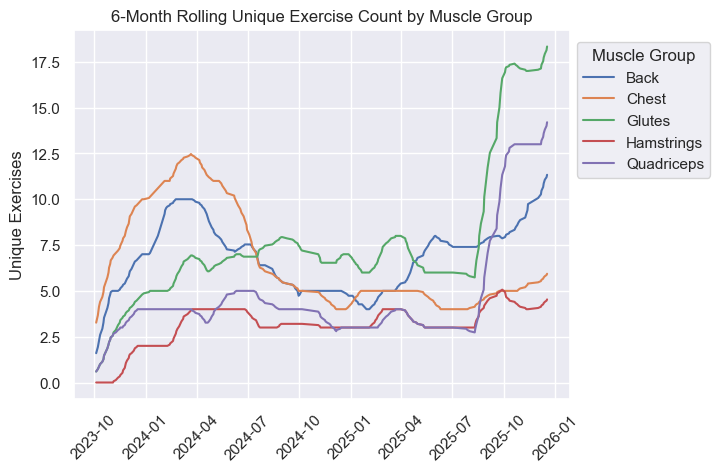

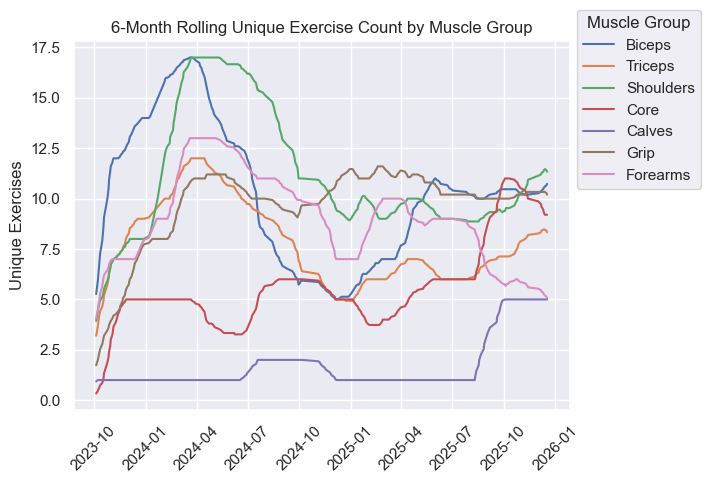

In [775]:
def plot_unique_exercise_count_by_muscle_group(df, muscle_groups):
    """
    Plot rolling window of unique exercise count by muscle group.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe to plot. Must have 'date' and 'muscle_groups' columns.
    muscle_groups : list
        List of muscle groups to plot.
    """
    plot_values(df,
                columns=muscle_groups,
                x_axis='date',
                labels=[f'{mg.capitalize()}' for mg in muscle_groups],
                ylabel='Unique Exercises',
                title='6-Month Rolling Unique Exercise Count by Muscle Group',
                moving_average_window=15,
                legend_title='Muscle Group',
                legend_loc=(1.015, 0.6))

muscle_groups = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps']
plot_unique_exercise_count_by_muscle_group(df, muscle_groups)
muscle_groups = ['biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
plot_unique_exercise_count_by_muscle_group(df, muscle_groups)

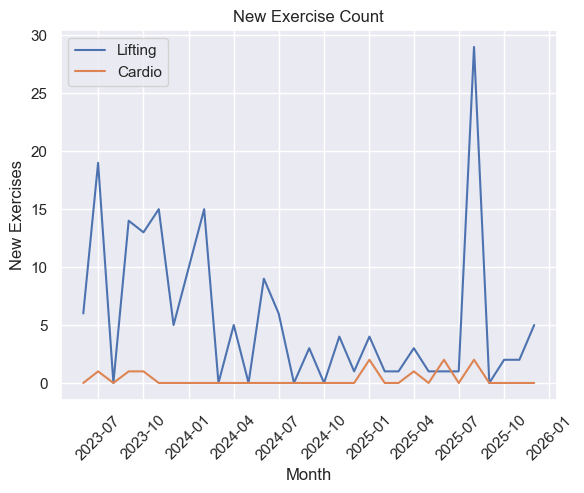

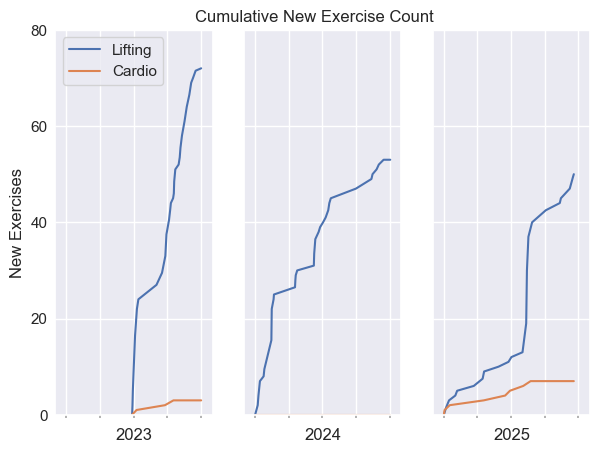

In [ ]:

common_kwargs = {'labels': ['Lifting', 'Cardio'], 'ylabel': 'New Exercises'}
plot_values(monthly_workout_df, columns=['new_exercise_lifting_count', 'new_exercise_cardio_count'],
            title='New Exercise Count', **common_kwargs)
plot_cumulative_lineplot_by_year(set_df, columns=['new_exercise_lifting', 'new_exercise_cardio'],
                                 title='Cumulative New Exercise Count', **common_kwargs)

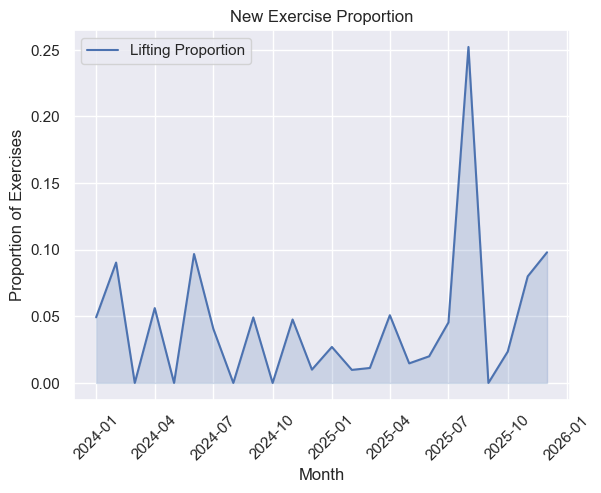

In [832]:
df = monthly_workout_df[monthly_workout_df['year'] > 2023]  # exclude 2023 since everything was new when I just started lifting
plot_values(df, columns=['new_exercise_lifting_proportion'], x_axis='month', ylabel='Proportion of Exercises',
            title='New Exercise Proportion', labels=['Lifting Proportion'], area=True)

#### 3.8 Rep Ranges 

In [779]:
def date_rolling_mean_variance(row, df, column='reps', days=60, muscle_group=None):
    """
    Calculate the rolling mean and variance of a column over a specified number of days.
    Also calculate the variance as the weighted average of the variance of each exercise.

    Parameters
    ----------
    row : Series
        A row from the DataFrame containing 'exercise' and 'date' columns.
    days : int, optional
        The number of days over which to calculate the rolling maximum. Default is 30 day.

    Returns
    -------
    mean : float
        The rolling mean of the column.
    variance : float
        The rolling variance of the column.
    exercise_variance : float
        The variance as the weighted average of the variance of each exercise.
    """
    # mean and variance
    mask = (df['date'] <= row['date']) & \
           (df['date'] >= row['date'] - pd.Timedelta(days=days))
    if muscle_group:
        mask = mask & (df['muscle_groups'].apply(lambda x: x and muscle_group in x))
    mean = df[mask][column].mean()
    variance = df[mask][column].var()

    # weighted average of exercise variances
    exercises = df[mask]['exercise'].unique()
    variances = []
    weights = []
    for exercise in exercises:
        exercise_mask = (df['exercise'] == exercise) & mask
        weight = exercise_mask.sum()
        if weight < 2:
            continue
        weights.append(weight)
        variances.append(df[exercise_mask][column].var())
    if weights:
        exercise_variance = np.average(variances, weights=weights)
    else:
        exercise_variance = np.nan
    return mean, variance, exercise_variance

mask = (set_df['workout_type'] == 'lifting') & (set_df['reps'].str.isnumeric())
df = set_df.loc[mask, ['date', 'exercise', 'reps', 'muscle_groups']].copy()
df['reps'] = df['reps'].astype(int)
# remove outliers (only large outliers)
q1 = df['reps'].quantile(0.25)
q3 = df['reps'].quantile(0.75)
iqr = q3 - q1
ub = max(q3 + 3 * iqr, df['reps'].quantile(0.95))
mask = df['reps'] <= ub
df = df.loc[mask]

# calculate rolling mean and variance
window_size = 90
dates = sorted(df['date'].unique())
df_dates = pd.DataFrame({'date': dates})  # just need to compute once for each date
df_dates = df_dates[df_dates['date'] >= min(dates) + timedelta(days=window_size)] # exclude partial windows
df_dates[['mean', 'variance', 'exercise_variance']] = df_dates.apply(
    lambda row: date_rolling_mean_variance(row, df, days=window_size), axis=1, result_type='expand')
# calculate rolling mean and variance by muscle group
for muscle_group in tracked_muscle_groups:
    new_cols = [f'mean_{muscle_group}', f'variance_{muscle_group}', f'exercise_variance_{muscle_group}']
    df_dates[new_cols] = df_dates.apply(
        lambda row: date_rolling_mean_variance(row, df, days=window_size, muscle_group=muscle_group),
        axis=1, result_type='expand')
df = df_dates

# TODO?: Possible future optimizations:
    # (possibly faster) Use {exercise: [reps]} dictionary to pass over data once, then compute exercise variance
    # use 2 pointers to compute rolling window (messy)

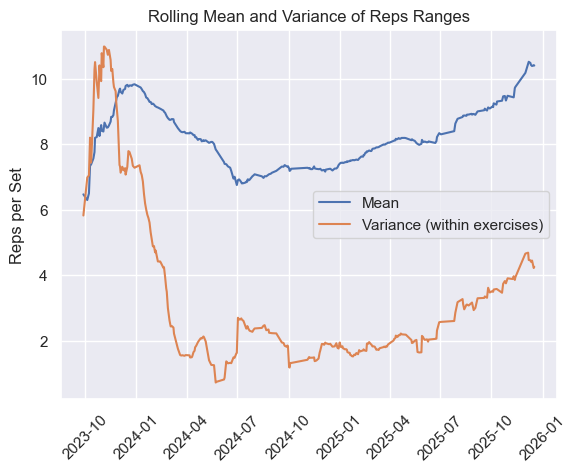

In [780]:
plot_values(df, columns=['mean', 'exercise_variance'], x_axis='date',
                  ylabel='Reps per Set', title='Rolling Mean and Variance of Reps Ranges',
                  labels=['Mean', 'Variance (within exercises)'])

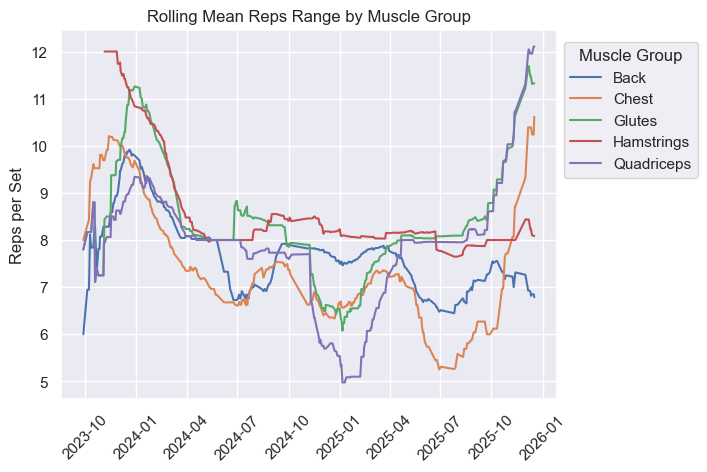

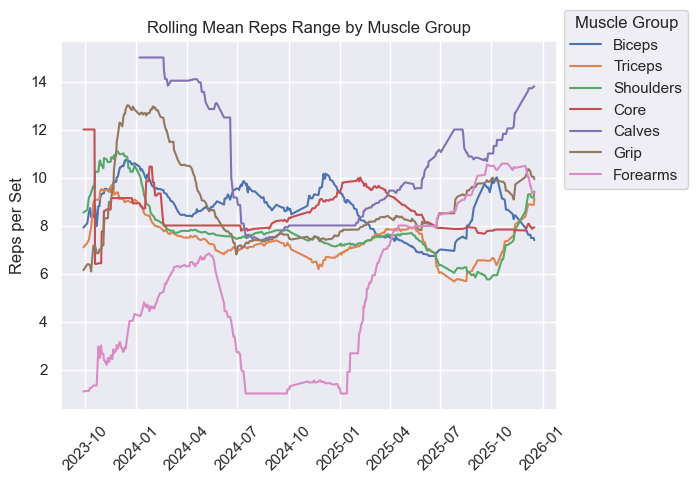

In [781]:
muscle_groups = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps']
plot_values(df,
            columns=[f'mean_{m}' for m in muscle_groups],
            x_axis='date',
            ylabel='Reps per Set',
            title='Rolling Mean Reps Range by Muscle Group',
            labels=[f'{m.capitalize()}' for m in muscle_groups],
            legend_title='Muscle Group',
            legend_loc=(1.015, 0.6))
muscle_groups = ['biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
plot_values(df,
            columns=[f'mean_{m}' for m in muscle_groups],
            x_axis='date',
            ylabel='Reps per Set',
            title='Rolling Mean Reps Range by Muscle Group',
            labels=[f'{m.capitalize()}' for m in muscle_groups],
            legend_title='Muscle Group',
            legend_loc=(1.015, 0.6))

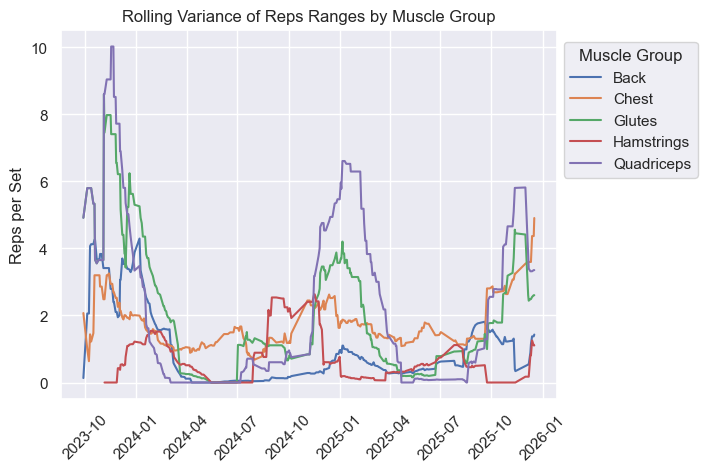

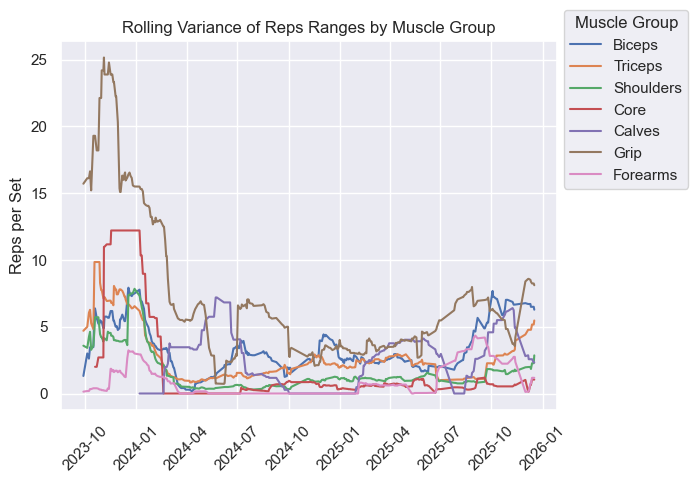

In [782]:
muscle_groups = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps']
plot_values(df,
            columns=[f'exercise_variance_{m}' for m in muscle_groups],
            x_axis='date',
            ylabel='Reps per Set',
            title='Rolling Variance of Reps Ranges by Muscle Group',
            labels=[f'{m.capitalize()}' for m in muscle_groups],
            legend_title='Muscle Group',
            legend_loc=(1.015, 0.6))
muscle_groups = ['biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
plot_values(df,
            columns=[f'exercise_variance_{m}' for m in muscle_groups],
            x_axis='date',
            ylabel='Reps per Set',
            title='Rolling Variance of Reps Ranges by Muscle Group',
            labels=[f'{m.capitalize()}' for m in muscle_groups],
            legend_title='Muscle Group',
            legend_loc=(1.015, 0.6))

In [783]:
n = 50  # number of top exercises to keep in the table

# prepare data
exercises = muscle_groups_dict.keys()
mask = (set_df['workout_type'] == 'lifting') & \
       (set_df['reps'].str.isnumeric()) & \
       (set_df['exercise'].isin(exercises))  # for sorting
df = set_df.loc[mask, ['date', 'exercise', 'reps']].copy()
df['reps'] = df['reps'].astype(int)
df['year'] = pd.to_datetime(df['date']).dt.year
df['exercise'] = pd.Categorical(df['exercise'], categories=exercises, ordered=True)  # sort by dict order later
df.drop('date', axis=1, inplace=True)
# remove outliers (only large outliers)
q1 = df['reps'].quantile(0.25)
q3 = df['reps'].quantile(0.75)
iqr = q3 - q1
ub = max(q3 + 3 * iqr, df['reps'].quantile(0.95))
mask = df['reps'] <= ub
df = df.loc[mask]
# calculate mean, variance, and total sets
df = df.groupby(['year', 'exercise'], observed=True).agg({'reps': ['mean', 'var', 'count']})
df.columns = df.columns.droplevel(0)
df.reset_index(inplace=True)
df = df.pivot(index='exercise', columns='year')
df['count'] = df['count'].fillna(0).astype(int)
df[('count', 'Total')] = df['count'].sum(axis=1)  # total sets per exercise
# get top n exercises with the most sets in the most recent year
max_year = df['mean'].columns.max()
required_sets = df[('count', max_year)].sort_values(ascending=False).iloc[n-1]
df = df[df[('count', max_year)] >= required_sets]
if len(df) > n:  # if there are too many exercises (ties), remove the extras
    ties = df[df[('count', max_year)] == required_sets]
    df = df.drop(ties.index[n - len(df):])
df = df.sort_values('exercise').reset_index(drop=False)
columns = {'exercise': 'Exercise', 'mean': 'Mean', 'var': 'Variance', 'count': 'Set Count'}
df.rename(columns=columns, inplace=True, level=None)
df.columns.names = ['', '']  # remove multiindex name ('year')

# Get cell coloring for a dataframe row
def get_row_colors(row, thresholds_tuples):
    row_colors = [''] * len(row)  # initialize with empty strings
    for column, threshold_dict in thresholds_tuples:
        value = row[column]
        idx = list(row.index).index(column)
        if np.isnan(value):
            row_colors[idx] += f"background-color: #f0f0f3; color: black"  # very light gray
            continue
        for color, threshold in threshold_dict.items():
            if value < threshold:
                row_colors[idx] += f"{color}; color: black"
                break
    # make the 'exercise' cell color the same as the 'Variance' cell for the latest year
    n_years = (len(row_colors) - 2) // 3  # number of years (-2 to exclude exercise and total reps columns)
    row_colors[0] = row_colors[2 * n_years]
    return row_colors

# specify colors (or CSS in general) and thresholds for data in different columns
thresholds_tuples = [  # each dict must be sorted by value in ascending order
    ('Variance', {'background-color: #FFC4C4': 0.5,       # light red
                  'background-color: #F7F5A2': 1.5,       # light yellow
                  'background-color: #BFE0BF': np.inf})]  # light green

# add 2nd-level index values to thresholds_tuples (required for add color to multi-level indexed dataframe)
new_thresholds_tuples = []
for column, threshold_dict in thresholds_tuples:
    if type(df[column]) == pd.core.frame.DataFrame:
        for sub_column in df[column].columns:
            new_thresholds_tuples.append(((column, sub_column), threshold_dict))
    else:
        new_thresholds_tuples.append((column, threshold_dict))
thresholds_tuples = new_thresholds_tuples

# add colors
cmap = sns.light_palette("blue", as_cmap=True)
df2 = df.style.apply(lambda row: get_row_colors(row, thresholds_tuples), axis=1)  # add colors to a dataframe

max_value_in_years = df['Set Count'].iloc[:, :-1].values.max()  # max value excluding total sum
print(max_value_in_years)
subset = [('Set Count', year) for year in df['Set Count'].columns[:-1]]  # exclude the total sum
df2.background_gradient(cmap=cmap, subset='Mean', high=0.8)  # highlight the mean
df2.background_gradient(cmap=cmap, subset=subset, high=0.8, vmin=0, vmax=max_value_in_years)  # highlight the sum (excluding total)
df2.background_gradient(cmap=cmap, subset=[('Set Count', 'Total')], high=0.8)  # highlight the total sum 
df2.highlight_null('#f0f0f3')  # very light gray, same as cmap(0)
df2.set_properties(**{'color': 'black'})  # set all text color to black
df2.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},  # center headers
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.5em;'},  # make headings bigger
    {'selector': 'thead', 'props': 'border: 1px solid black'}, # add border around header
    {'selector': 'tbody', 'props': 'border: 1px solid black'}, # add border around table
], overwrite=False)
df2 = df2.set_caption("Rep Range by Exercise")
df2.set_table_styles([{
        'selector': 'caption',
        'props': [
            ('font-size', '200%'),
            ('font-weight', 'bold'),
            ('text-align', 'center'), # Captions are centered by default, but this is explicit
            ('padding-bottom', '7px'),
        ]
    }], overwrite=False)

# add vertical lines to separate sections
min_year = df['Mean'].columns.min()
df2.set_table_styles({
    ('Exercise', ''): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                       {'selector': 'td', 'props': 'border-left: 1px solid black'}],
    ('Mean', min_year): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                         {'selector': 'td', 'props': 'border-left: 1px solid black'}],
    ('Variance', min_year): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                             {'selector': 'td', 'props': 'border-left: 1px solid black'}],
    ('Set Count', min_year): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                              {'selector': 'td', 'props': 'border-left: 1px solid black'}],
    ('Set Count', 'Total'): [{'selector': 'td', 'props': 'border-left: 0.5px dashed black'},
                             {'selector': 'th', 'props': 'border-left: 0.5px dashed black'}],
}, overwrite=False)

# add horizontal lines to every 10th row
styles = [{'selector': f'.row{i}', 'props': 'border-top: 1px solid black'} for i in range(0, len(df), 10)]
df2.set_table_styles(styles, overwrite=False)

# round values to 2 decimal places
round_dict = {(c1, c2): '{:.2f}' for c1, c2 in df.columns if c1 in ['Mean', 'Variance']}
df2 = df2.format(formatter=round_dict)

# display dataframe
if display_styled_df_as_image:
    display_as_image(df2)
else:
    display(df2)

324


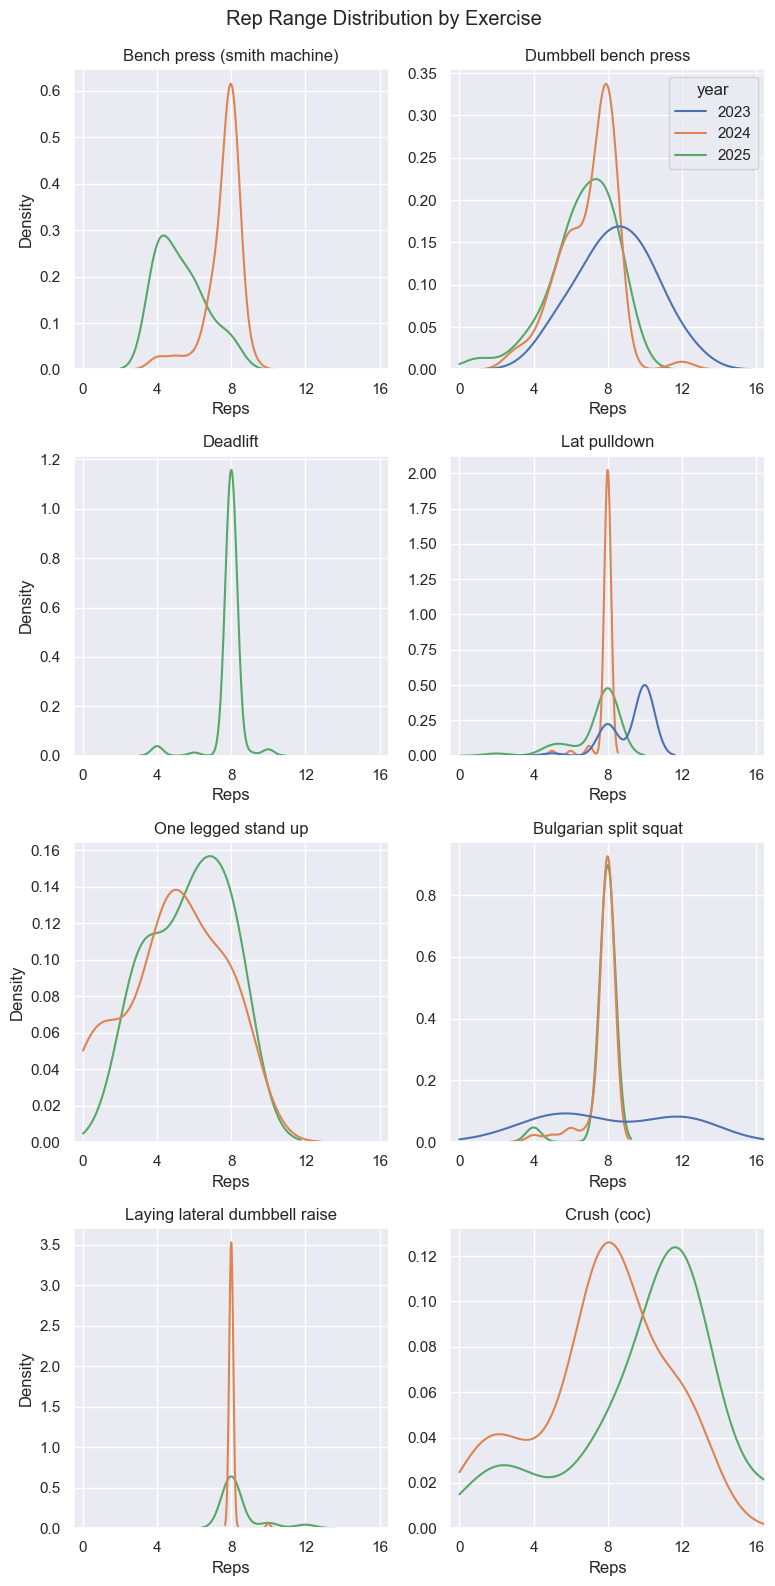

In [784]:
exercises = ['Bench press (smith machine)', 'Dumbbell bench press', 'Deadlift',
             'Lat pulldown', 'One legged stand up', 'Bulgarian split squat',
             'Laying lateral dumbbell raise', 'Crush (coc)']

# prepare data
mask = (set_df['workout_type'] == 'lifting') & \
       (set_df['reps'].str.isnumeric()) & \
       (set_df['exercise'].isin(exercises))
df = set_df.loc[mask, ['date', 'exercise', 'reps']].copy()
df['reps'] = df['reps'].astype(int)
df['year'] = pd.to_datetime(df['date']).dt.year
df.drop('date', axis=1, inplace=True)

years = sorted(df['year'].unique().tolist())
custom_palette = {year: f'C{i}' for i, year in enumerate(years)}

nrows = (len(exercises) + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(8, 4*nrows))

common_kwargs = {
    'x': 'reps',
    'hue': 'year',
    'common_norm': False,
    'clip': [0,24],
    'palette': custom_palette,
    'bw_adjust': 1,
}

for i, exercise in enumerate(exercises):
    m, n = divmod(i, 2)
    ax = axes[m, n]

    exercise_df = df.loc[df['exercise'] == exercise]
    sns.kdeplot(ax=ax, data=exercise_df, **common_kwargs, legend=i==1)

    ax.set_title(exercise)
    ax.set_xlim(-0.5, 16.5)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.set_xlabel('Reps')
    if n == 0:
        ax.set_ylabel('Density')
    else:
        ax.set_ylabel(None)
    

plt.suptitle(f'Rep Range Distribution by Exercise', y=0.99)  # add spaces to center title
plt.tight_layout()

#### 3.9 Rest

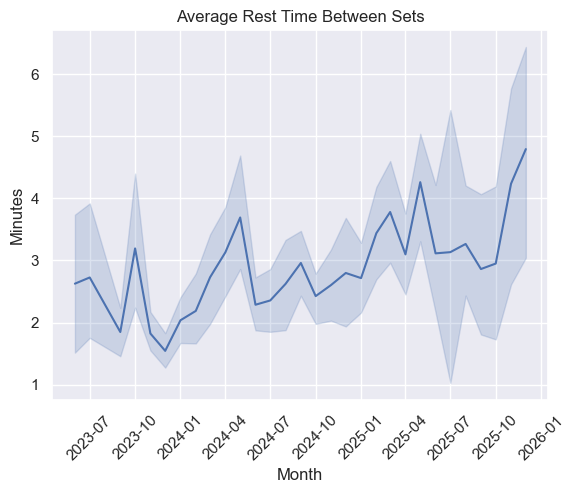

In [785]:
plot_values(workout_df, columns='rest_time_minutes_per_set', ylabel='Minutes',
            title='Average Rest Time Between Sets', legend=False)
# Note: the CI is based on workout averages since I don't have individual set rest times

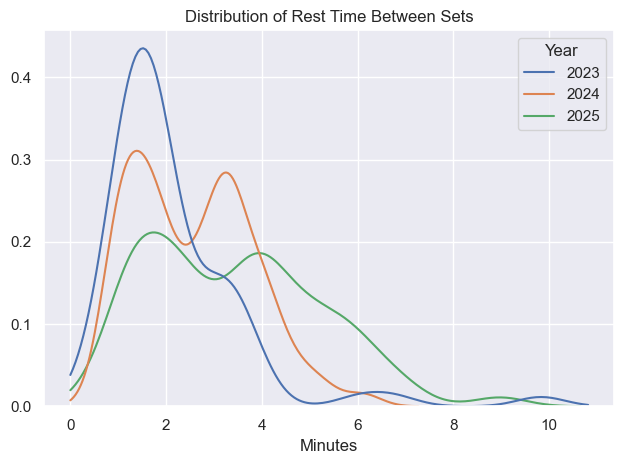

In [786]:
distribution_plot_by_year(workout_df, column='rest_time_minutes_per_set', xlabel='Minutes',
                          title='Distribution of Rest Time Between Sets')

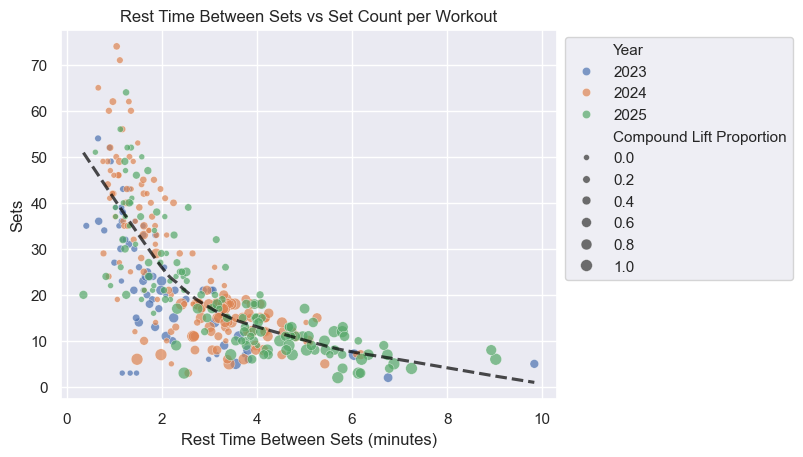

In [787]:
scatterplot_by_year(workout_df, x='rest_time_minutes_per_set', y='set_count',
                    size='compound_lift_set_proportion', size_label='Compound Lift Proportion',
                    title='Rest Time Between Sets vs Set Count per Workout',
                    x_label='Rest Time Between Sets (minutes)', y_label='Sets')

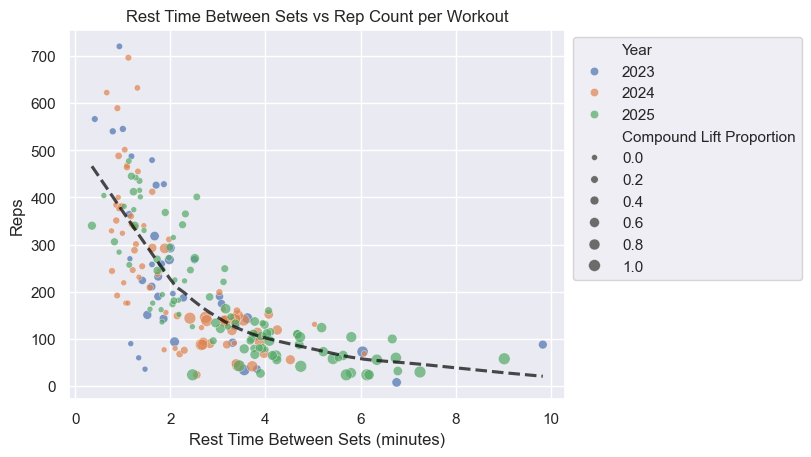

In [788]:
scatterplot_by_year(workout_df, x='rest_time_minutes_per_set', y='reps',
                    size='compound_lift_set_proportion', size_label='Compound Lift Proportion',
                    title='Rest Time Between Sets vs Rep Count per Workout',
                    x_label='Rest Time Between Sets (minutes)', y_label='Reps')

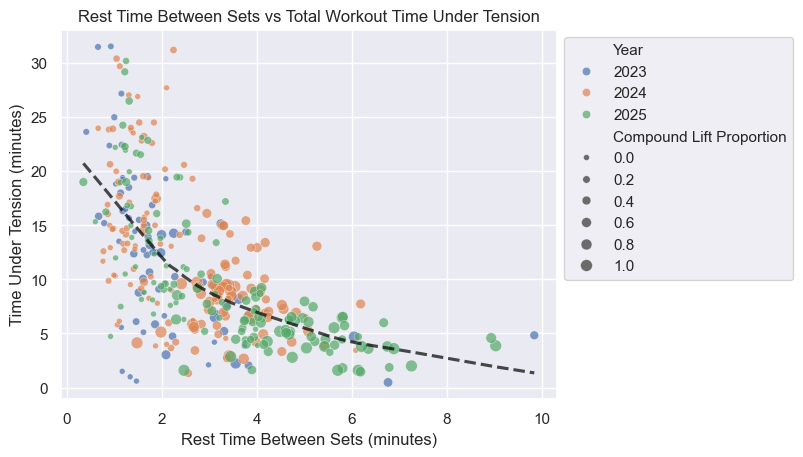

In [789]:
scatterplot_by_year(workout_df, x='rest_time_minutes_per_set', y='time_under_tension_minutes',
                    size='compound_lift_set_proportion', size_label='Compound Lift Proportion',
                    title='Rest Time Between Sets vs Total Workout Time Under Tension',
                    x_label='Rest Time Between Sets (minutes)', y_label='Time Under Tension (minutes)')

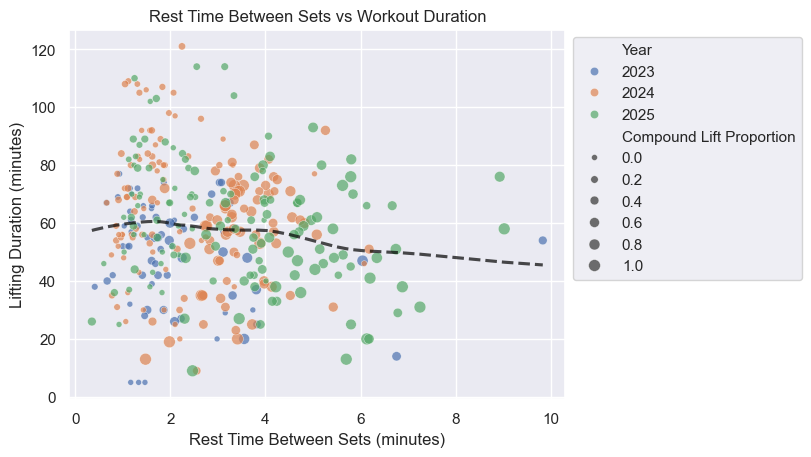

In [790]:
scatterplot_by_year(workout_df, x='rest_time_minutes_per_set', y='lifting_duration_minutes',
                    size='compound_lift_set_proportion', size_label='Compound Lift Proportion',
                    title='Rest Time Between Sets vs Workout Duration',
                    x_label='Rest Time Between Sets (minutes)', y_label='Lifting Duration (minutes)')

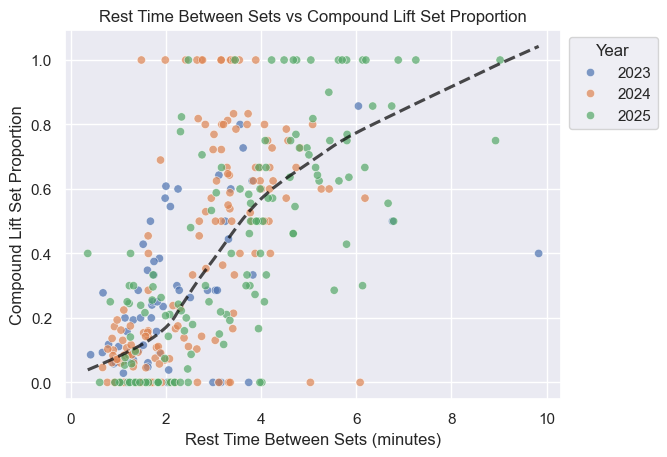

In [791]:
scatterplot_by_year(workout_df, x='rest_time_minutes_per_set', y='compound_lift_set_proportion',
                    title='Rest Time Between Sets vs Compound Lift Set Proportion',
                    x_label='Rest Time Between Sets (minutes)', y_label='Compound Lift Set Proportion')

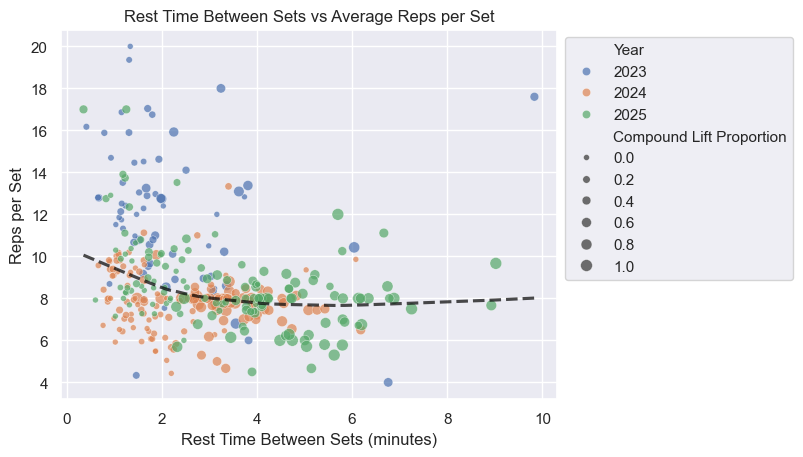

In [792]:
# remove outliers
columns = ['rest_time_minutes_per_set', 'average_rep_range', 'year', 'compound_lift_set_proportion']
df = workout_df[columns].copy()
df = df[df['average_rep_range'] < df['average_rep_range'].quantile(0.99)]
scatterplot_by_year(df, x='rest_time_minutes_per_set', y='average_rep_range',
                    size='compound_lift_set_proportion', size_label='Compound Lift Proportion',
                    title='Rest Time Between Sets vs Average Reps per Set',
                    x_label='Rest Time Between Sets (minutes)', y_label='Reps per Set')

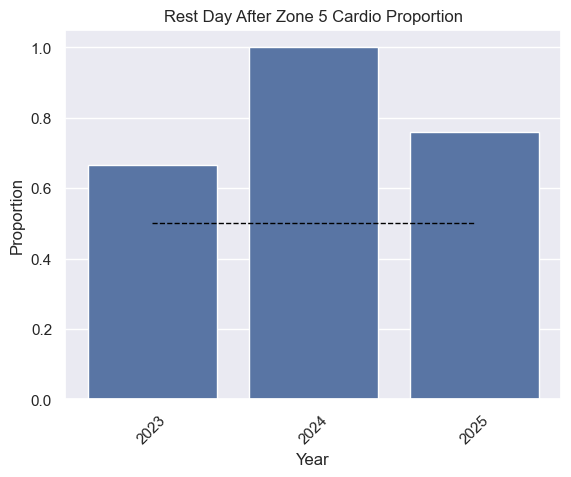

In [793]:
# The proportion of zone 5 cardio days that are followed by a rest day
column = 'rest_day_after_zone_5_rate'
goal = goals_dict[goal_year][column]
plot_values(yearly_workout_df, columns=[column], x_axis='year', legend=False, ylabel='Proportion',
                    title='Rest Day After Zone 5 Cardio Proportion', goals=goal, plot_type='bar')

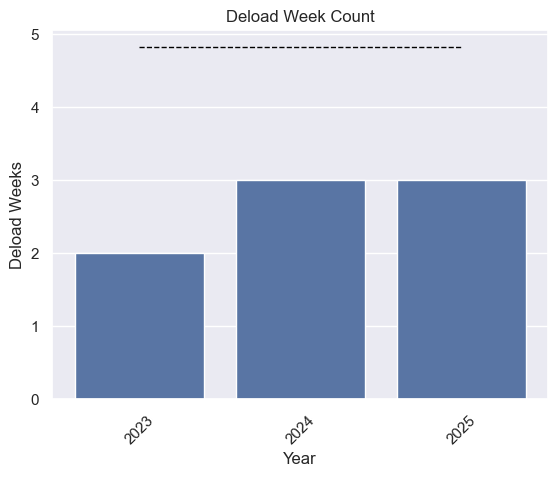

In [794]:
column = 'deload_count'
goal = goals_dict[goal_year][column] * year_proportion
plot_values(yearly_workout_df, columns=[column], x_axis='year', legend=False, ylabel='Deload Weeks',
                    title='Deload Week Count', goals=goal, plot_type='bar')

#### 3.10 Exercise Order

In [795]:
def exercise_order_table(field, horizontal_line_every_n_rows=None, caption=None, caption_size='200%'):
    """
    Create a styled dataframe showing the average exercise order position and workout count
    for each value in the specified field (e.g., primary muscle group, exercise).
    
    Parameters
    ----------
    field : str
        The field to group by (e.g., 'primary_muscle_group', 'exercise').
    horizontal_line_every_n_rows : int, optional
        If specified, adds a horizontal line every n rows for better readability.
    caption : str, optional
        If specified, adds a caption to the table.
    caption_size : str, optional
        The font size of the caption (e.g., '150%', '200%'). Default is '200%'.
    Returns
    -------
    pd.io.formats.style.Styler
        The styled dataframe.
    """

    # prepare data
    mask = set_df['workout_type'] == 'lifting'
    exercise_df = set_df.loc[mask, ['year', 'start_datetime', field, 'exercise_count']].drop_duplicates()
    if field == 'primary_muscle_group':
        muscle_groups = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps',
                        'biceps','triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
        exercise_df = exercise_df[exercise_df['primary_muscle_group'].isin(muscle_groups)]
        exercise_df['primary_muscle_group'] = exercise_df['primary_muscle_group'].str.capitalize()
    df = exercise_df.groupby(['year', field]) \
                    .agg(avg_position=('exercise_count', 'mean'), workout_count=('start_datetime', 'nunique')) \
                    .reset_index()
    df = df.pivot(index=field, columns='year', values=['avg_position', 'workout_count']).reset_index()
    df.insert(len(df['avg_position'].columns) + 1, ('avg_position', 'Overall'),
            exercise_df.groupby(field)['exercise_count'].mean().values)
    df['workout_count', 'Total'] = df['workout_count'].sum(axis=1)
    df = df[df['workout_count', 'Total'] >= 15]  # filter out values with less than 15 workouts
    df = df.sort_values(('avg_position', 'Overall')).reset_index(drop=True)
    df['workout_count'] = df['workout_count'].fillna(0).astype(int)
    df['avg_position'] = df['avg_position'].round(2)
    new_field_name = field.replace('_', ' ').title()
    df.rename(columns={field: new_field_name, 'workout_count': 'Workout Count', 'avg_position': 'Average Position'}, inplace=True)
    df.columns.names = ['', '']  # remove multiindex name ('year')

    # add colors
    cmap = sns.light_palette("blue", as_cmap=True)
    df2 = df.style
    max_value = df['Average Position'].max().max()
    subset = [('Average Position', j) for j in df['Average Position'].columns]
    df2.background_gradient(cmap=cmap, subset=subset, high=0.8, vmin=0, vmax=max_value)
    max_value_in_years = df['Workout Count'].iloc[:, :-1].values.max()  # max value excluding total sum
    subset = [('Workout Count', j) for j in df['Workout Count'].columns[:-1]]
    df2.background_gradient(cmap=cmap, subset=subset, high=0.8, vmin=0, vmax=max_value_in_years)  # highlight the sum (excluding total)
    df2.background_gradient(cmap=cmap, subset=[('Workout Count', 'Total')], high=0.8)  # highlight the total sum 
    df2.highlight_null('#f0f0f3')  # very light gray, same as cmap(0)
    df2.set_properties(**{'color': 'black'})  # set all text color to black

    # add table styling
    df2.set_table_styles([
        {'selector': 'th.col_heading', 'props': 'text-align: center;'},  # center column headers
        {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.25em;'},  # make headings bigger
        {'selector': 'th.row_heading.level0', 'props': 'border-right: 1px solid black'}, # add vertical line after index
        {'selector': 'tbody', 'props': 'border: 1px solid black'}, # add border around table
        {'selector': 'thead', 'props': 'border: 1px solid black'}, # add border around header
    ], overwrite=False)

    # add horizontal lines to every nth row
    if horizontal_line_every_n_rows:
        styles = [{'selector': f'.row{i}', 'props': 'border-top: 1px solid black'} for i in range(0, len(df), horizontal_line_every_n_rows)]
        df2.set_table_styles(styles, overwrite=False)

    # add vertical lines to separate sections
    min_year = df['Average Position'].columns[0]
    df2.set_table_styles({
        ('Average Position', min_year): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                                        {'selector': 'td', 'props': 'border-left: 1px solid black'}],
        ('Average Position', 'Overall'): [{'selector': 'td', 'props': 'border-left: 0.5px dashed black'},
                                        {'selector': 'th', 'props': 'border-left: 0.5px dashed black'}],
        ('Workout Count', min_year): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                                    {'selector': 'td', 'props': 'border-left: 1px solid black'}],
        ('Workout Count', 'Total'): [{'selector': 'td', 'props': 'border-left: 0.5px dashed black'},
                                    {'selector': 'th', 'props': 'border-left: 0.5px dashed black'}],
        }, overwrite=False)

    # add caption
    if caption:
        df2 = df2.set_caption(caption)
        df2.set_table_styles([{
                'selector': 'caption',
                'props': [
                    ('font-size', caption_size),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'), # Captions are centered by default, but this is explicit
                    ('padding-bottom', '7px'),
                ]
            }], overwrite=False)

    # round values in output
    round_dict = {('Average Position', c): '{:.2f}' for c in df['Average Position'].columns} | \
                    {('Workout Count', c): '{:.0f}' for c in df['Workout Count'].columns}
    df2 = df2.format(formatter=round_dict)

    # display dataframe
    if display_styled_df_as_image:
        display_as_image(df2)
    else:
        display(df2)

def prepare_exercise_order_plot_data(field):
    """
    Prepare data for exercise order plot.

    Parameters
    ----------
    field : str
        The field to prepare data for (e.g., 'exercise', 'primary_muscle_group' or 'compound_lift').

    Returns
    -------
    df : pandas.DataFrame
        The prepared DataFrame for plotting.
    """
    mask = (set_df['workout_type'] == 'lifting')
    df = set_df.loc[mask, ['date', 'start_datetime', 'exercise_count', field]].copy()
    df = df.drop_duplicates()
    if field == 'primary_muscle_group':
        muscle_groups = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps',
                        'biceps','triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
        df = df[df['primary_muscle_group'].isin(muscle_groups)]
    df = pd.crosstab(index=[df['date'], df['exercise_count']],
                     columns=df[field],
                     values=df['exercise_count'],
                     aggfunc='sum')
    df.reset_index(inplace=True)
    df['quarter'] = df['date'].dt.to_period('Q').dt.to_timestamp()
    df['year'] = df['date'].dt.year
    if field == 'compound_lift':
        df = df.rename(columns={True: 'Compound Lift', False: 'Isolation Exercise'})
    return df

In [796]:
exercise_order_table(field='exercise', horizontal_line_every_n_rows=10, caption='Exercise Order within Workouts')

In [797]:
exercise_order_table(field='primary_muscle_group', horizontal_line_every_n_rows=4, caption='Primary Muscle Group Order within Workouts')

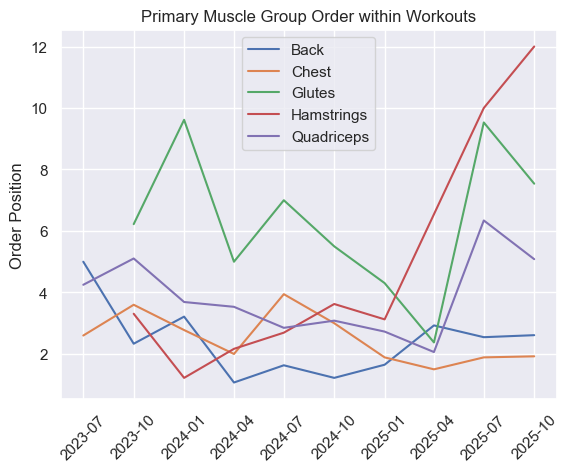

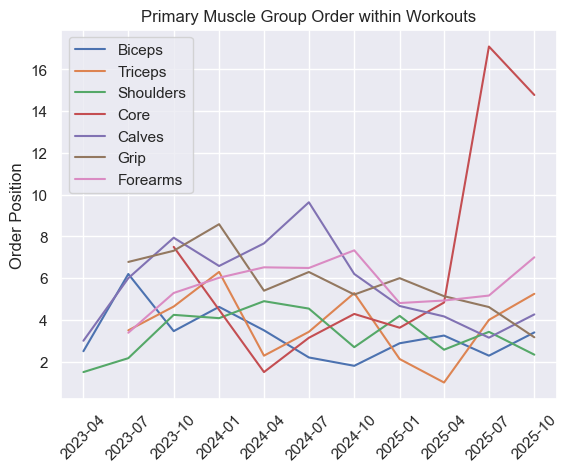

In [798]:
df = prepare_exercise_order_plot_data(field='primary_muscle_group')
common_kwargs = {'df': df, 'x_axis': 'quarter', 'xlabel': None, 'ylabel': 'Order Position',
                 'title': 'Primary Muscle Group Order within Workouts', 'plot_kwargs': {'errorbar': None}}
columns = ['back', 'chest', 'glutes', 'hamstrings', 'quadriceps']
plot_values(columns=columns, labels=[c.capitalize() for c in columns], **common_kwargs)
columns = ['biceps', 'triceps', 'shoulders', 'core', 'calves', 'grip', 'forearms']
plot_values(columns=columns, labels=[c.capitalize() for c in columns], **common_kwargs)

In [799]:
exercise_order_table(field='compound_lift', caption='Compound Lift vs Isolation Exercise Order within Workouts', caption_size='150%')

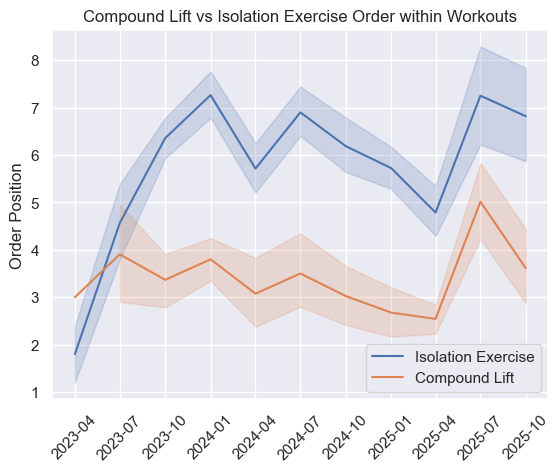

In [800]:
df = prepare_exercise_order_plot_data(field='compound_lift')
columns = ['Isolation Exercise', 'Compound Lift']
plot_values(df, columns=columns, x_axis='quarter', xlabel=None, ylabel='Order Position',
            title='Compound Lift vs Isolation Exercise Order within Workouts')

## 4. Plot Workout Performance

In [801]:
# Helper functions
def date_rolling_max(row, df, column='1RM', days=30):
    """
    Calculate the rolling maximum of a column for an exercise up to a given date over a specified
    number of days to smooth out the data.

    Parameters
    ----------
    row : Series
        A row from the DataFrame containing 'exercise' and 'date' columns.
    days : int, optional
        The number of days over which to calculate the rolling maximum. Default is 30 day.
    """
    # TODO?: Might optimize this by applying to the whole dataframe column at once
    mask = (df['exercise'] == row['exercise']) & \
           (df['date'] <= row['date']) & \
           (df['date'] >= row['date'] - pd.Timedelta(days=days))
    return df[mask][column].max()

def label_to_marker_size(label, sizes, size_norm):
    """
    Map label number to marker size in a scatterplot legend.
    
    Parameters
    ----------
    label : float
        Label of the legend entry.
    sizes : tuple
        Tuple of minimum and maximum marker sizes. Passed to sns.scatterplot.
    size_norm : tuple
        Tuple of minimum and maximum label values. Passed to sns.scatterplot.
    
    Returns
    -------
    marker_size : float
        Marker size corresponding to the label.
    """
    label = float(label)
    if label < size_norm[0]:
        marker_size2 = sizes[0]
    elif label > size_norm[1]:
        marker_size2 = sizes[1]
    else:
        marker_size2 = sizes[0] + (sizes[1] - sizes[0]) * (label - size_norm[0]) / (size_norm[1] - size_norm[0])
    marker_size = marker_size2 ** 0.5
    return marker_size

In [802]:
def plot_1rm(set_df, exercises, title=None, smooth_days=30, plot_goals=True):
    """
    Plot 1RM for each exercise over time.
    
    Parameters
    ----------
    set_df : DataFrame
        DataFrame containing the sets data.
    exercises : list
        List of exercises to plot.
    title : str, optional
        Title for the plot.
    smooth_days : int, optional
        Number of days over which to calculate the rolling maximum to smooth out the data.
    """
    df = set_df[set_df['exercise'].isin(exercises)]  # filter on exercises
    df = df.groupby(['exercise', 'date']).agg({'1RM': 'max'}).sort_values(by='date').reset_index()
    df['1RM'] = df.apply(date_rolling_max, df=df, days=smooth_days, axis=1)  # smooth using rolling max
    # make categorical to sort exercises by input order
    df['exercise'] = pd.Categorical(df['exercise'], categories=exercises)
    df = df.sort_values(by=['exercise', 'date']).reset_index(drop=True)
    ax = sns.lineplot(data=df, x='date', y='1RM', hue='exercise', dashes=False)
    # Add lines for monthly goals
    if plot_goals:
        goals = [goals_dict[goal_year].get(f'{c} 1RM') for c in exercises]
        colors = [line.get_color() for line in ax.lines]
        for i, g in enumerate(goals):
            if g:
                sns.lineplot(data=df, x='date', y=g, color=colors[i], linewidth=1, alpha=0.7, linestyle='--')
    plt.xticks(rotation=45)
    plt.title(label=title)
    plt.ylabel('lbs')
    plt.xlabel('')
    legend = ax.legend(loc=(1.015, 0.75))
    legend.get_frame().set_alpha(0.5)
    plt.show()

def plot_unilateral_1rm(set_df, exercises, title=None, smooth_days=30, plot_goals=True):
    """
    Plot unilateral 1RM for each exercise over time.
    
    Parameters
    ----------
    set_df : DataFrame
        DataFrame containing the sets data.
    exercises : list
        List of exercises to plot.
    title : str, optional
        Title for the plot.
    """
    df = set_df[set_df['exercise'].isin(exercises)]  # filter on exercises
    df = df.groupby(['date', 'exercise', 'side']).agg({'1RM': 'max'}).sort_index().reset_index()
    df['exercise'] = df['exercise'] + ' (' + df['side'] + ')'
    df['1RM'] = df.apply(date_rolling_max, df=df, days=smooth_days, axis=1)  # smooth using rolling max
    # ensure that exercises are plotting in input order
    exercise_order = []
    for e in exercises:
        exercise_order.append(e + ' (L)')
        exercise_order.append(e + ' (R)')
    # make categorical to sort exercises by input order
    df['exercise'] = pd.Categorical(df['exercise'], categories=exercise_order)
    df = df.sort_values(by=['exercise', 'date']).reset_index(drop=True)
    ax = sns.lineplot(data=df, x='date', y='1RM', hue='exercise', dashes=False)
    # Add lines for monthly goals
    if plot_goals:
        goals = []
        for e in exercises:
            goals.append(goals_dict[goal_year].get(f'{e} (L) 1RM'))
            goals.append(goals_dict[goal_year].get(f'{e} (R) 1RM'))
        colors = [line.get_color() for line in ax.lines]
        for i, g in enumerate(goals):
            if g:
                sns.lineplot(data=df, x='date', y=g, color=colors[i], linewidth=1, alpha=0.7, linestyle='--')
    plt.xticks(rotation=45)
    plt.title(label=title)
    plt.ylabel('lbs')
    plt.xlabel('')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.show()

def plot_max_reps(set_df, exercises, title=None, smooth_days=30, plot_goals=True, duration=False):
    """
    Plot max reps for each exercise over time, mainly for bodyweight exercises.
    
    Parameters
    ----------
    set_df : DataFrame
        DataFrame containing the sets data.
    exercises : list
        List of exercises to plot.
    title : str, optional
        Title for the plot.
    smooth_days : int, optional
        Number of days to smooth the data using rolling max.
    plot_goals : bool, optional
        Whether to plot the monthly goals.
    duration : bool, optional
        Whether to plot the max duration instead of max reps.
    """    
    y_axis = 'rep_duration_seconds' if duration else 'reps'
    df = set_df[set_df['exercise'].isin(exercises)]  # filter on exercises
    df = df[df['weight'].isin(["", 0]) | df['weight'].isnull()] # filter on bodyweight (i.e. no weight used)
    df.loc[:,y_axis] = df[y_axis].astype(float)
    df = df.groupby(['date', 'exercise']).agg({y_axis: 'max'}).sort_index().reset_index()
    # smooth using rolling max
    df[y_axis] = df.apply(date_rolling_max, df=df, column=y_axis, days=smooth_days, axis=1)
    # make categorical to sort exercises by input order
    df['exercise'] = pd.Categorical(df['exercise'], categories=exercises)
    df = df.sort_values(by=['exercise', 'date']).reset_index(drop=True)
    ax = sns.lineplot(data=df, x='date', y=y_axis, hue='exercise', dashes=False)
    # Add lines for monthly goals
    if plot_goals:
        field_suffix = 'max duration (seconds)' if duration else 'max reps'
        goals = [goals_dict[goal_year].get(f'{c} {field_suffix}') for c in exercises]
        colors = [line.get_color() for line in ax.lines]
        for i, g in enumerate(goals):
            if g:
                sns.lineplot(data=df, x='date', y=g, color=colors[i], linewidth=1, alpha=0.7, linestyle='--')
    plt.xticks(rotation=45)
    plt.title(label=title or '')
    plt.xlabel('')
    plt.ylabel('Seconds' if duration else 'Reps')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.show()

#### Main Compound Lifts

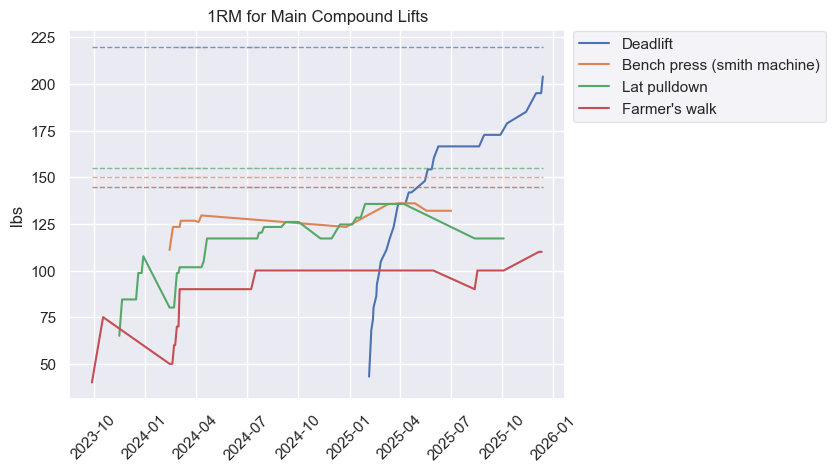

In [803]:
exercises = ['Deadlift', 'Bench press (smith machine)', 'Lat pulldown', "Farmer's walk"]
# TODO: add squats in the future
plot_1rm(set_df, exercises, title='1RM for Main Compound Lifts')
# Note: Farmer's walk is showing weight used, not 1RM

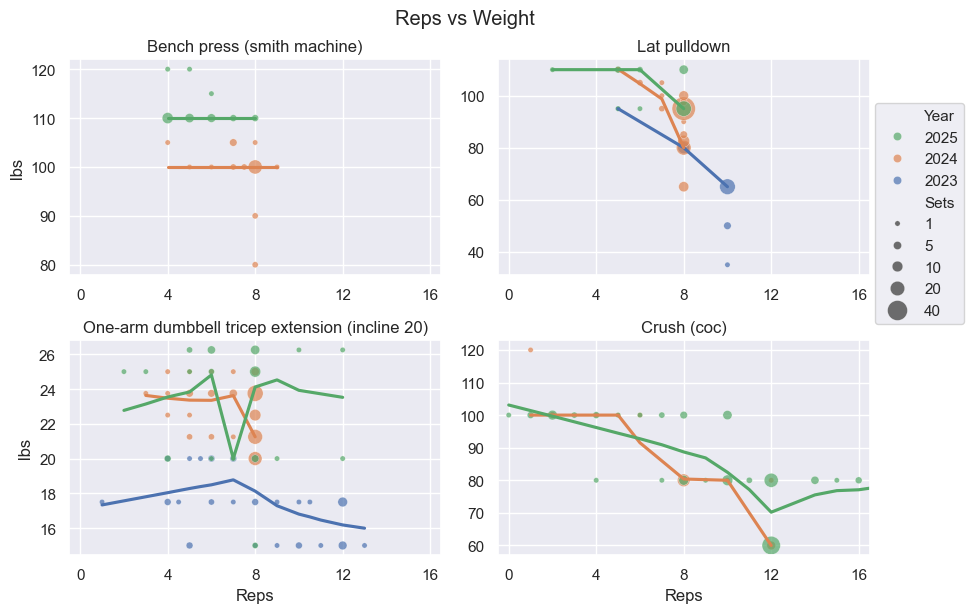

In [804]:
exercises = ['Bench press (smith machine)', 'Lat pulldown', 'One-arm dumbbell tricep extension (incline 20)',
             'Crush (coc)']
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# data preparation
mask = (set_df['workout_type'] == 'lifting') & (set_df['exercise'].isin(exercises))
columns = ['date', 'exercise', 'weight', 'reps']
df = set_df.loc[mask, columns].copy()
df['year'] = pd.to_datetime(df['date']).dt.year
df.drop('date', axis=1, inplace=True)
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')  # convert to numeric
df['reps'] = pd.to_numeric(df['reps'], errors='coerce')
years = sorted(df['year'].unique().tolist())
custom_palette = {year: f'C{i}' for i, year in enumerate(years)}
grouped_df = df.groupby(['year', 'exercise', 'weight', 'reps']).size().reset_index(name='Sets')
max_sets = 80  # set counts beyond this don't increase the scatterplot marker size
# plot scatter plots and regression lines
for i, exercise in enumerate(exercises):
    m, n = divmod(i, 2)
    ax = axes[m, n]
    sizes = (10, 400)  # min and max marker sizes
    size_norm = (0, max_sets)  # label numbers associated with min and max marker sizes
    sns.scatterplot(data=grouped_df[grouped_df['exercise'] == exercise],
                        ax=ax, x='reps', y='weight', hue='year',
                        size='Sets', sizes=sizes, size_norm=size_norm,
                        palette=custom_palette, alpha=0.7, legend=(i==1))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # suppress warning from regplot fully fitting to the data
        for j, year in enumerate(years):
            mask = (df['year'] == year) & (df['exercise'] == exercise)
            sns.regplot(data=df[mask], ax=ax, x='reps', y='weight', scatter=False, color=f'C{j}', lowess=True)
    ax.set_xlim(-0.5, 16.5)
    ax.set_title(exercise)
    if m == 1:
        ax.set_xlabel('Reps')
    else:
        ax.set_xlabel(None)
    if n == 0:
        ax.set_ylabel('lbs')
    else:
        ax.set_ylabel(None)
    ax.set_xticks([0, 4, 8, 12, 16])
plt.tight_layout()
fig.suptitle(f'{10*' '}Reps vs Weight', y=1.02)  # add spaces to center title
# reverse years in legend, and specify marker sizes for legend (so it applies well to all plots)
ax = axes[0,1]  # the only axis with a legend
new_labels = [1, 5, 10, 20, 40]  # length must be <= the number of marker size handles in the legend (usually 5)
handles, labels = ax.get_legend_handles_labels()
i = labels.index('Sets')
labels = ['Year'] + labels[1:i][::-1] + ['Sets'] + new_labels
handles = [handles[0]] + handles[1:i][::-1] + handles[i:]
for j in range(i+1, len(labels)):
    marker_size = label_to_marker_size(labels[j], sizes, size_norm)
    handles[j].set_markersize(marker_size)  # set marker size for legend_label()
ax.legend(handles=handles, labels=labels, loc=(1.015, -0.23))
plt.show()

#### Chest

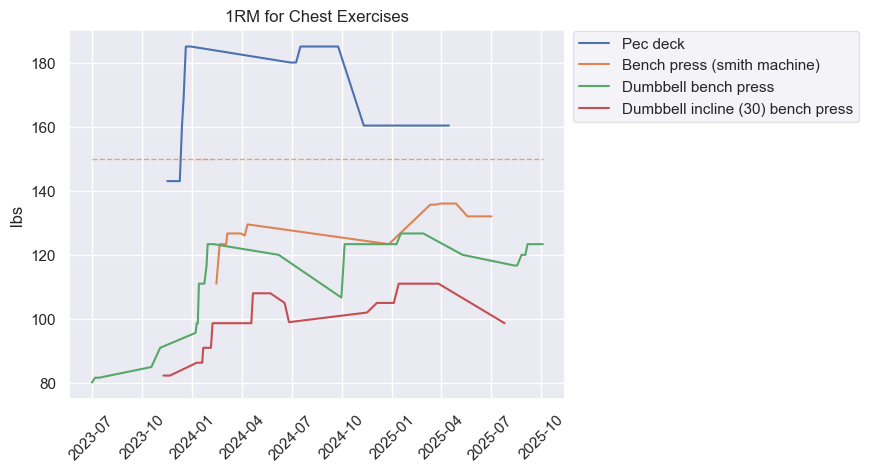

In [805]:
exercises = ['Pec deck', 'Bench press (smith machine)', 'Dumbbell bench press',
             'Dumbbell incline (30) bench press']
plot_1rm(set_df, exercises, title='1RM for Chest Exercises')

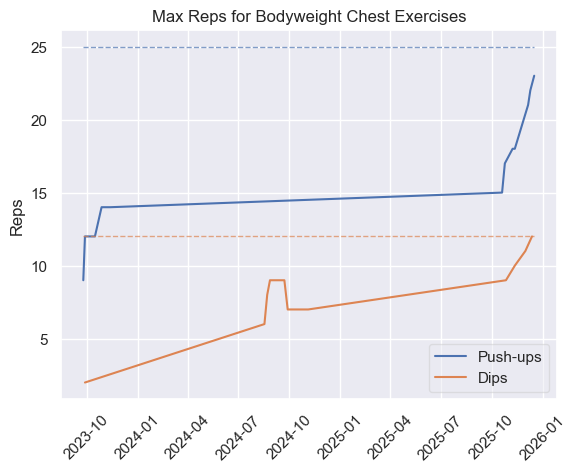

In [806]:
plot_max_reps(set_df, exercises=['Push-ups', 'Dips'], title='Max Reps for Bodyweight Chest Exercises')

#### Back

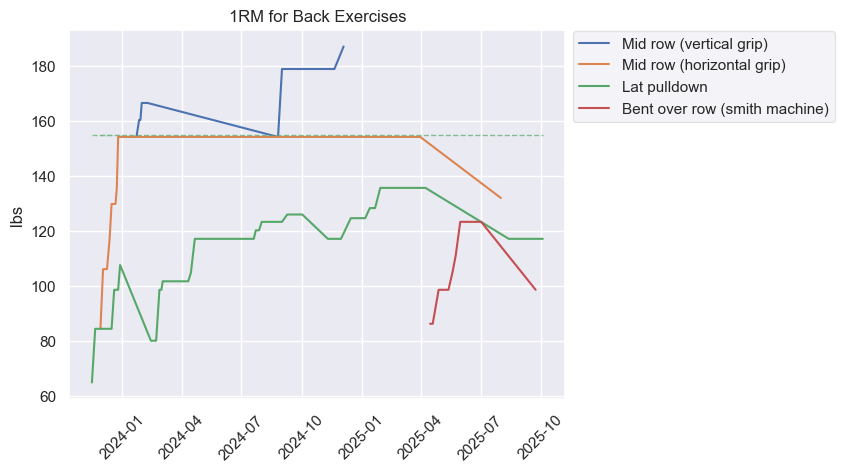

In [807]:
exercises = ['Mid row (vertical grip)', 'Mid row (horizontal grip)', 'Lat pulldown',
             'Bent over row (smith machine)']
plot_1rm(set_df, exercises, title='1RM for Back Exercises')

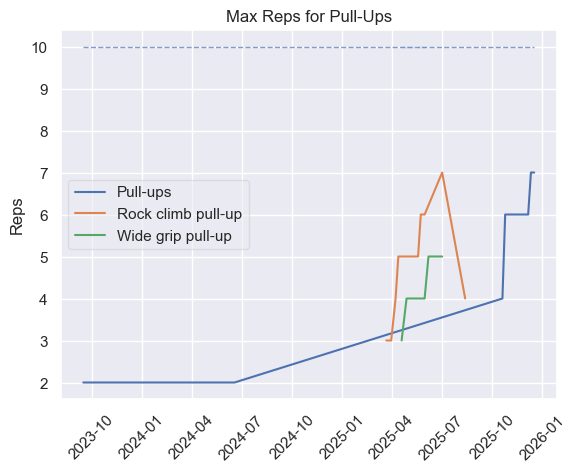

In [808]:
exercises = ['Pull-ups', 'Rock climb pull-up', 'Wide grip pull-up']  # 'Neutral grip pull-up'
plot_max_reps(set_df, exercises, title='Max Reps for Pull-Ups')

#### Legs

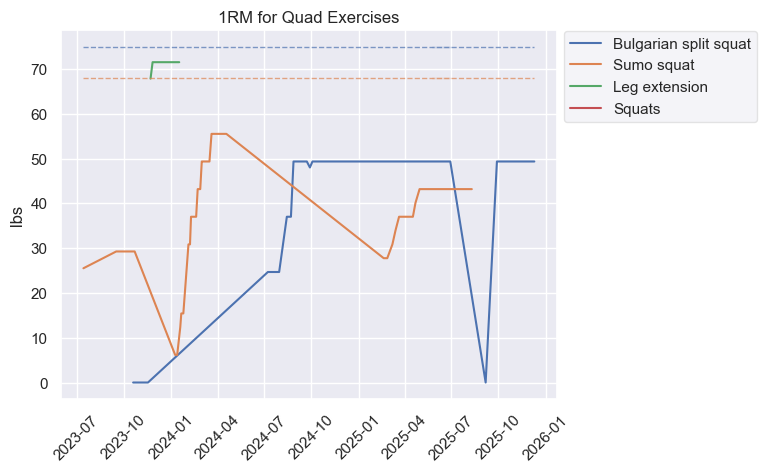

In [809]:
exercises = ['Bulgarian split squat', 'Sumo squat', 'Leg extension', 'Squats']
plot_1rm(set_df, exercises, title='1RM for Quad Exercises')

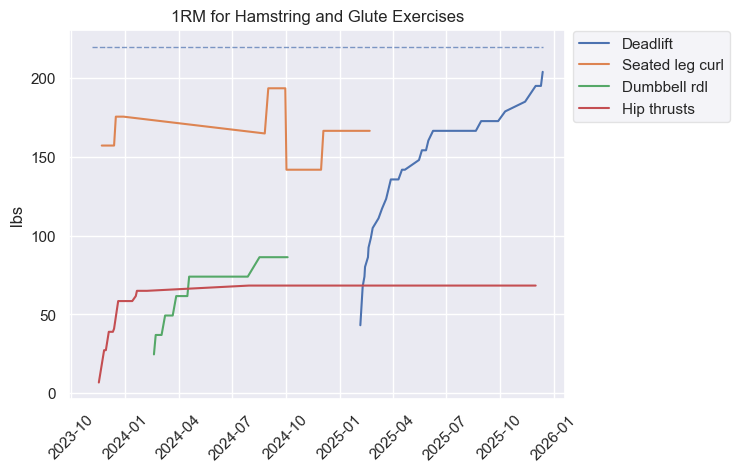

In [810]:
exercises = ['Deadlift', 'Seated leg curl', 'Dumbbell rdl', 'Hip thrusts'] # 'Hip thrusts (single leg)'
plot_1rm(set_df, exercises, title='1RM for Hamstring and Glute Exercises')

#### Shoulders

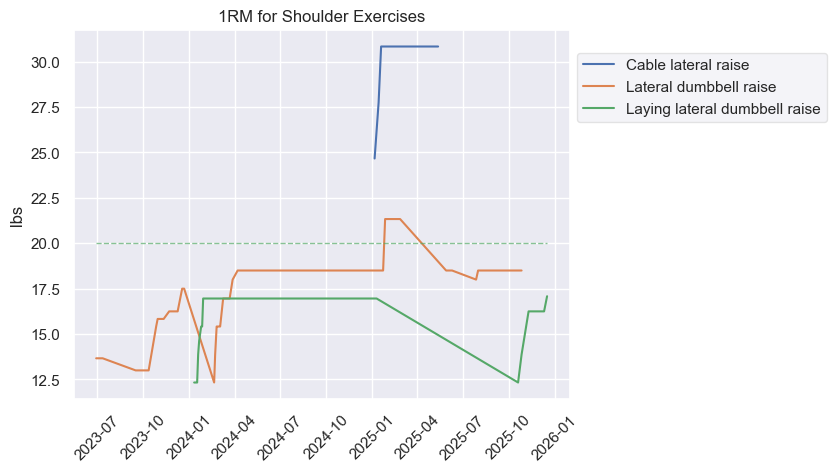

In [811]:
exercises = ['Cable lateral raise', 'Lateral dumbbell raise', 'Laying lateral dumbbell raise']
# TODO: add 'Seated dumbbell shoulder press' in future
plot_1rm(set_df, exercises, title='1RM for Shoulder Exercises')

#### Biceps

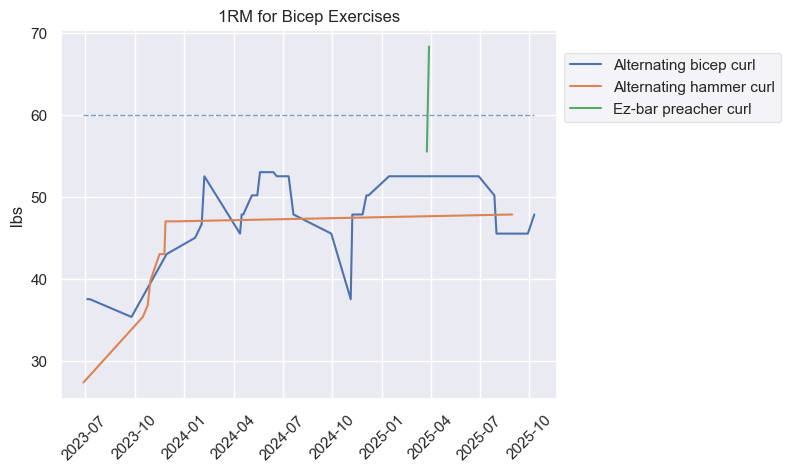

In [812]:
exercises = ['Alternating bicep curl', 'Alternating hammer curl', 'Ez-bar preacher curl']
plot_1rm(set_df, exercises, title='1RM for Bicep Exercises')

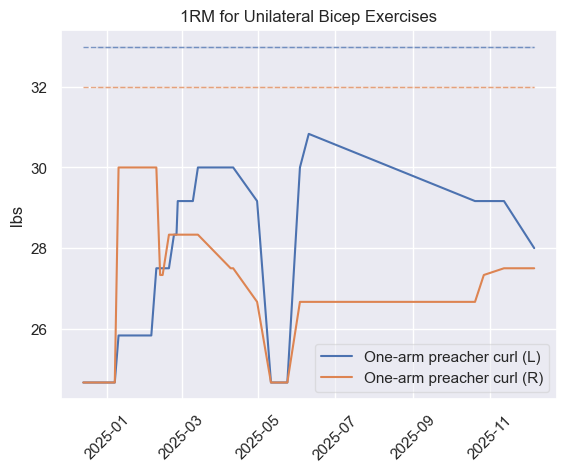

In [813]:
plot_unilateral_1rm(set_df, exercises=['One-arm preacher curl'], title='1RM for Unilateral Bicep Exercises')

#### Triceps


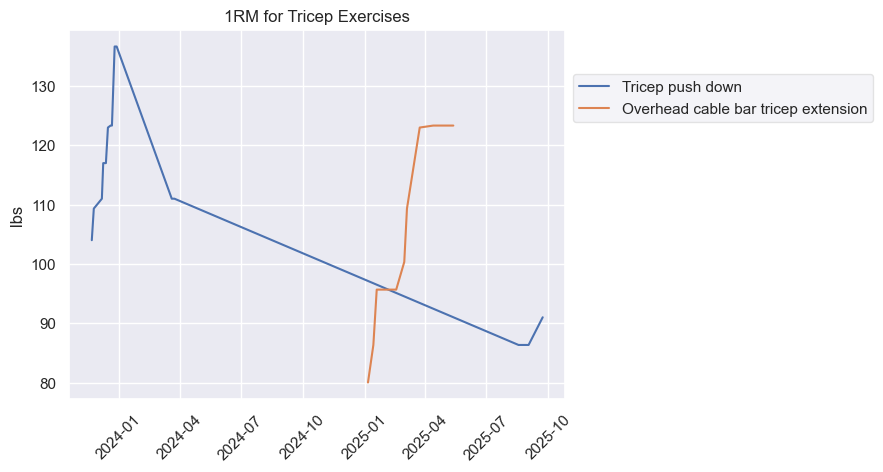

In [814]:
exercises = ['Tricep push down', 'Overhead cable bar tricep extension']
plot_1rm(set_df, exercises, title='1RM for Tricep Exercises')

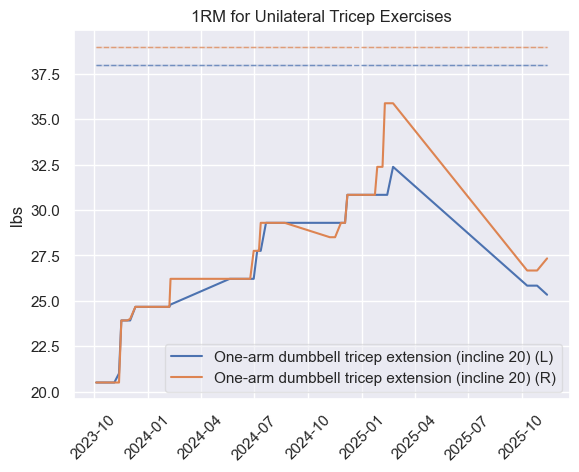

In [815]:
exercises = ['One-arm dumbbell tricep extension (incline 20)']
plot_unilateral_1rm(set_df, exercises, title='1RM for Unilateral Tricep Exercises')

#### Forearms

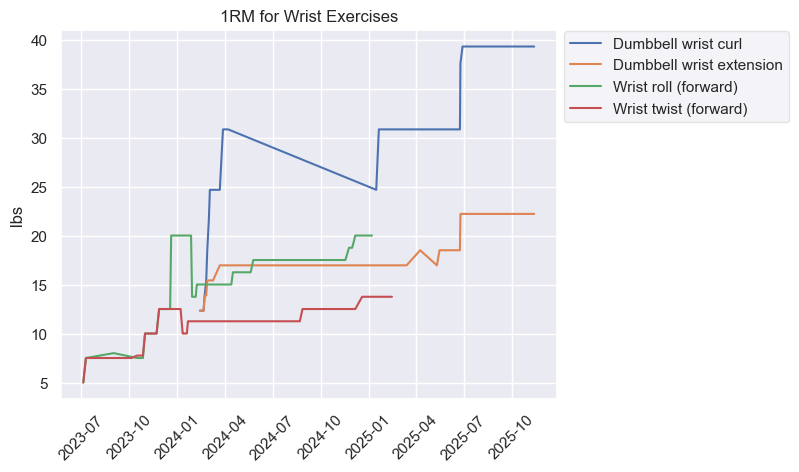

In [816]:
exercises = ['Dumbbell wrist curl', 'Dumbbell wrist extension', 'Wrist roll (forward)', 'Wrist twist (forward)']
plot_1rm(set_df, exercises, title='1RM for Wrist Exercises')

#### Grip

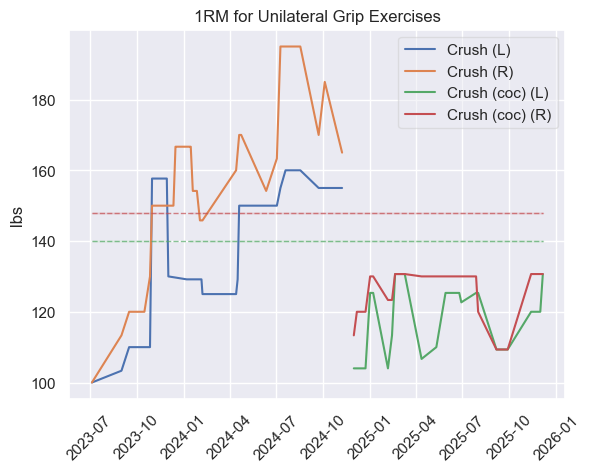

In [817]:
plot_unilateral_1rm(set_df, exercises=['Crush','Crush (coc)'], title='1RM for Unilateral Grip Exercises')

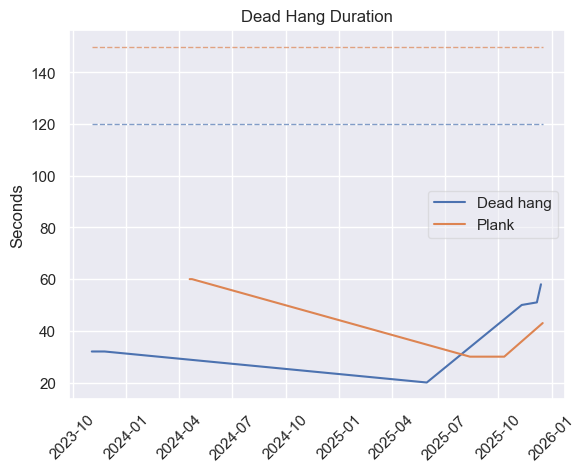

In [818]:
plot_max_reps(set_df, exercises=['Dead hang', 'Plank'], title='Dead Hang Duration', duration=True)

#### Treadmill Zone 2

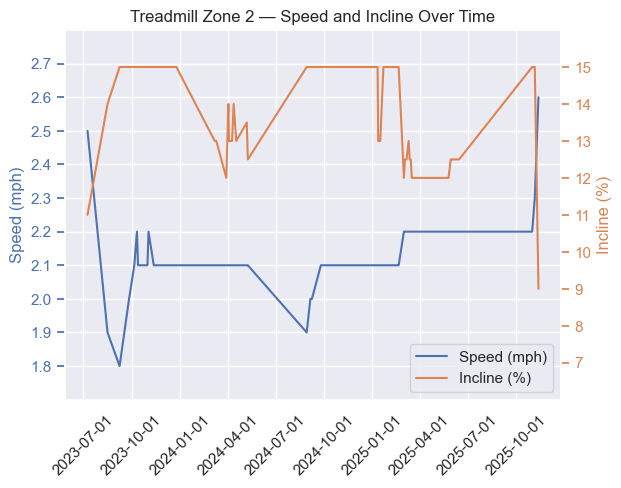

In [819]:
# plot incline and speed for Zone 2 walking up hill on treadmill

# prepare data
mask = (set_df['exercise'] == 'Treadmill') & \
       (set_df['weight'] == 'Zone 2') & \
       (set_df['treadmill incline (%)'] > 7)
df = set_df[mask][['date', 'treadmill incline (%)', 'treadmill speed (mph)']]
df.rename(columns={'treadmill incline (%)': 'Incline (%)',
                   'treadmill speed (mph)': 'Speed (mph)'}, inplace=True)

# plot with two y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot speed on left y-axis (blue)
sns.lineplot(data=df, x='date', y='Speed (mph)', ax=ax1, color='C0', label='Speed (mph)', dashes=False)
ax1.set_ylabel('Speed (mph)', color='C0')  # blue
y_lb = 1.8
y_ub = 2.8
ax1.set_yticks(np.arange(y_lb, y_ub, 0.1))
ax1.set_ylim((y_lb - 0.1, y_ub))
ax1.tick_params(axis='y', colors='C0')
ax1.set_xticks(ax1.get_xticks())  # just here to suppress warning on the next line
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_xlabel('')

# plot incline on right y-axis (orange)
ax2 = sns.lineplot(data=df, x='date', y='Incline (%)', ax=ax2, color='C1', label='Incline (%)', dashes=False)
ax2.set_ylabel('Incline (%)', color='C1')
ax2.set_yticks(range(7, 16, 1))
ax2.set_ylim((6, 16))
ax2.tick_params(axis='y', colors='C1')
ax2.grid(False)  # Disable grid on the second y-axis to avoid overlap

# add title and legend
plt.title(label='Treadmill Zone 2 — Speed and Incline Over Time')
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')
ax2.legend().remove()  # Remove the second legend to avoid duplication

plt.show()
# TODO: might remove this chart if it gets too erratic with changes to speed and incline

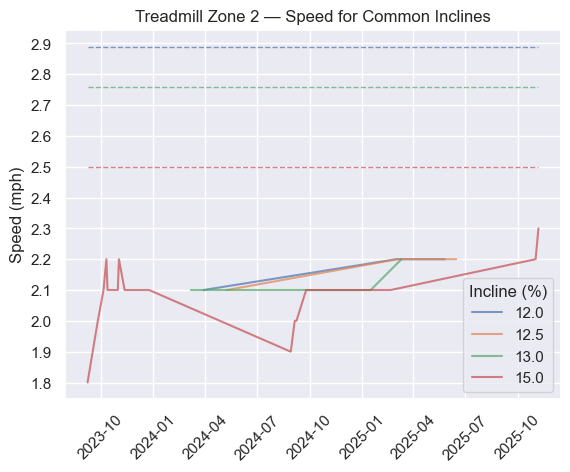

In [820]:
# plot speed vs date for common inclines

# prepare data
num_inclines = 4
most_common_inclines = sorted(set_df['treadmill incline (%)'].value_counts().index[:num_inclines].to_list())
most_common_inclines = [int(i) if i.is_integer() else float(i) for i in most_common_inclines]
mask = (set_df['exercise'] == 'Treadmill') & \
       (set_df['weight'] == 'Zone 2') & \
       (set_df['treadmill incline (%)'].isin(most_common_inclines))
df = set_df[mask][['date', 'treadmill incline (%)', 'treadmill speed (mph)']]
df.rename(columns={'treadmill incline (%)': 'Incline (%)',
                   'treadmill speed (mph)': 'Speed (mph)'}, inplace=True)
df['Incline (%)'] = pd.Categorical(df['Incline (%)'], categories=most_common_inclines)
df = df.sort_values(by=['Incline (%)', 'date']).reset_index(drop=True)

# plot speed vs date for each incline
ax = sns.lineplot(data=df, x='date', y='Speed (mph)', hue='Incline (%)', palette='deep',
                  alpha=0.7, dashes=False)

# add goal lines
goals = [goals_dict[goal_year].get(f'Treadmill Zone 2 incline {i}% max speed') for i in most_common_inclines]
colors = [line.get_color() for line in ax.lines]
for i, g in enumerate(goals):
    if g:
        sns.lineplot(data=df, x='date', y=g, color=colors[i], linewidth=1, alpha=0.7, linestyle='--')

ax.yaxis.set_major_locator(MultipleLocator(0.1))  # Ensure ticks are at least 0.1 apart
plt.title(label='Treadmill Zone 2 — Speed for Common Inclines')
plt.legend(title='Incline (%)')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()

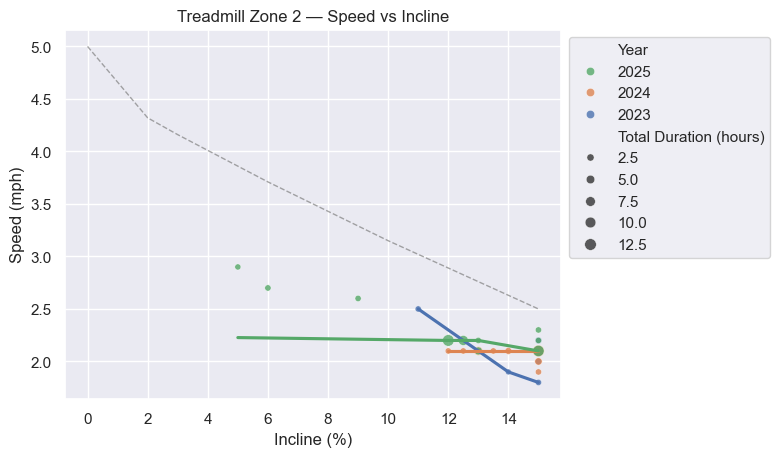

In [821]:
# plot incline vs speed for Zone 2 treadmill

# prepare data
mask = (set_df['exercise'] == 'Treadmill') & \
       (set_df['weight'] == 'Zone 2') & \
        set_df['treadmill speed (mph)'].notna()
columns = ['date', 'treadmill incline (%)', 'treadmill speed (mph)', 'rep_duration_minutes']
df = set_df.loc[mask, columns].copy()
df['year'] = pd.to_datetime(df['date']).dt.year
df = df[df['rep_duration_minutes'] > 15]  # filter out short runs
grouped_df = df.groupby(['treadmill incline (%)', 'treadmill speed (mph)', 'year']) \
               .agg(rep_duration_minutes=('rep_duration_minutes', 'sum')).reset_index()
grouped_df['rep_duration_hours'] = grouped_df['rep_duration_minutes'] / 60

# plot scatter plot and regression lines
ax = sns.scatterplot(data=grouped_df, x='treadmill incline (%)', y='treadmill speed (mph)',
                hue='year', palette='deep', alpha=0.8, size='rep_duration_hours')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # suppress warning from regplot fully fitting to the data
    for i, year in enumerate(sorted(grouped_df['year'].unique())):
        sns.regplot(data=df[df['year'] == year], x='treadmill incline (%)', y='treadmill speed (mph)',
                    scatter=False, color=f'C{i}', lowess=True)

# Add line for monthly goals
goals = [goals_dict[goal_year].get(f'Treadmill Zone 2 incline {i}% max speed') for i in range(16)]
colors = [line.get_color() for line in ax.lines]
sns.lineplot(x=range(16), y=goals, color='grey', linewidth=1, alpha=0.7, linestyle='--')

# ensure y ticks are at least 0.1 apart
major_tick_size = round((ax.get_yticks()[1] - ax.get_yticks()[0]).item(), 3)
if major_tick_size < 0.1:
    ax.yaxis.set_major_locator(MultipleLocator(0.1))

# reverse years in legend
handles, labels = ax.get_legend_handles_labels()
i = labels.index('rep_duration_hours')
labels = ['Year'] + labels[1:i][::-1] + ['Total Duration (hours)'] + labels[i+1:]
handles = [handles[0]] + handles[1:i][::-1] + handles[i:]
plt.legend(bbox_to_anchor=(1,1), loc='upper left', handles=handles, labels=labels)

plt.xlabel('Incline (%)')
plt.ylabel('Speed (mph)')
plt.title('Treadmill Zone 2 — Speed vs Incline')
plt.show()